In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

In [3]:
def extract_values(obj, key):
    """Recursively pull values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Return all matching values in an object."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)

        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
                
        return arr

    results = extract(obj, arr, key)
    return results

def column_info(row):
    expr = row["FilterExprNorm"].values[0]
    print(expr)
    d = json.loads(expr)
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    num_cols = len(col_names)

In [16]:
FN = "combined-0J-2021-05-22.ss.csv"
INP_FIELD = "NormInput"
DEDUP_FIELDS = [INP_FIELD, "FilterExprNorm"]
#DEDUP_FIELDS = []
#INP_FIELD = "HashTagInput"

In [17]:
df = pd.read_csv(FN, sep="|")

In [18]:
df = df.rename(columns={"#Field:JobGUID":"jobid"})

In [19]:
# For some analysis, we may not want to drop duplicates here.
#df = df.drop_duplicates(["jobid", INP_FIELD])

In [20]:
df.keys()
# check across different NormInputs ---> do distributions / selectivities remain stable across
# cases
# full schema vs not;

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount'],
      dtype='object')

In [21]:
#print(len(df))

# Duplicate and then execute ---> we could group these together, but probably won't make a big difference in the stats we collect

In [22]:
df = df.drop_duplicates(DEDUP_FIELDS)

In [23]:
df["Selectivity"] = df.apply(lambda x: min(x["RowCount"] / x["InputCardinality"], 1.0) ,axis=1)

In [24]:
def is_num(val):
    try:
        float(val)
        return True
    except:
        return False

def get_discrete_type(vals):
    if len(vals) == 0:
        return ""
    
    val = str(vals[0])
    val = val.replace("@", "")
    val = val.replace("\"", "")
    val = val.replace("\'", "")
    
    if val.lower() == "null" or val.lower() == "none" \
        or val.lower() == "na" or "empty" in val.lower() \
        or val == "":
        return "null"
    
    elif is_num(val) or "System.Date" in val:
        return "num"
    
    elif val.lower() == "true" or val.lower() == "false":
        return "bool"
    
    else:
        #print(val)
        return "string"

In [25]:
import re

def is_int(num):
    try:
        int(num)
        return True
    except:
        return False

import dateutil.parser as dp
def get_cont_dtype(val):
    if val.lower()[-1] == "d" or val.lower()[-1] == "f":
        val = val[0:-1]
        
    if "date" in val.lower():
        #print(val)
        #valdate = int(val[val.find("(")+1:val.lower().find("l")])
        t = val[val.find("/*")+2:val.find("*/")]
        #print(t)
        #t = '1984-06-02T19:05:00.000Z'
        parsed_t = dp.parse(t)
        t_in_seconds = parsed_t.timestamp()
        #print(t_in_seconds)
        return "date", t_in_seconds
    
    elif is_int(val):
        val = int(val)
        return "int", val
    elif is_num(val):
        val = float(val)
        return "float", val
    elif "proto" in val.lower():
        return "protobuf", None
    else:
        if "-" in val:
            allvals = val.split("-")
            if len(allvals) == 3:
                return "date2", None
            else:
                return "str", None
        else:
            return "str", None
'''
< : 1/0
> : 1/0 
(can be both);
< term: None or L number
> term: 
difference: None OR < minus > term

What if multiple non contiguous ranges?? ---> 1/0 
What if multiple columns with different ranges? ---> 1/0

float vs long vs int vs date vs str;

How will we tell whether moving window style filters OR sth else?
'''
def parse_cont_vals(ops, vals, col_names):
    
    # values to return: one for each column
    ## type: range, lt, gt
    ## dtype:
    ## range: None, or actual value
    ret = {}
    
    cont_idxs = []
    
    cur_comb_op = ""
    for oi, op in enumerate(ops):
        if op == "And" or op == "Or":
            cur_comb_op = op
        
        if ">" in op or "<" in op:
            cont_idxs.append(oi)
            col = col_names[oi]
            
            col = col_names[oi]
            val = vals[oi]
            if isinstance(val, list):
                if len(val) == 0:
                    continue
                assert len(val) == 1
                val = val[0]
            
            val = val.replace("@", "")
            val = val.replace("\"", "")
            val = val.replace("\'", "")
            dtype, pval = get_cont_dtype(val)
            
            if col not in ret:
                ret[col] = {}
            ret[col]["dtype"] = dtype
            if pval is not None and ">" in op:
                ret[col]["gt"] = pval
            elif pval is not None and "<" in op:
                ret[col]["lt"] = pval
            
            ret[col]["comb_op"] = cur_comb_op
    
    for col in ret:
        if "comb_op" in ret[col] and ret[col]["comb_op"] == "Or":
            ctype = "discont"
        
        elif "lt" in ret[col] and "gt" in ret[col]:
            ctype = "range"
            #assert ret[col]["comb_op"] == "And"
            if "comb_op" not in ret[col]:
                print(vals)
                print(ops)

            elif ret[col]["comb_op"] != "And":
                print(vals)
                print(ops)
            
        elif "lt" in ret[col]:
            ctype = "lt"
        elif "gt" in ret[col]:
            ctype = "gt"
        else:
            ctype = "other"
        
        if "lt" in ret[col] and "gt" in ret[col]:
            crange = ret[col]["lt"] - ret[col]["gt"]
            
            #if ret[col]["dtype"] == "date":
                #days = crange / 86400.0
                #ret[col]["range_days"] = days
#             if crange < 0:
#                 print(ret[col]["lt"], ret[col]["gt"])
#                 print(crange)
#                 print(vals)
#                 print(ops)
#                 print(ret[col]["comb_op"])
#                 print("**************")
                #assert crange >= 0.0
            if crange < 0:
                assert ret[col]["comb_op"] == "Or"
            else:
                ret[col]["range"] = crange
        
        ret[col]["cont_type"] = ctype

    return ret

In [26]:
cur_row = None

inp_to_filter_cols = defaultdict(set)
inp_to_pcols = defaultdict(set)
inp_to_all_cols = defaultdict(set)

inp_to_ops = defaultdict(set)
inp_to_num_cols = defaultdict(list)

inp_to_discrete_consts = defaultdict(dict)
inp_to_continuous_consts = defaultdict(dict)
inp_to_op_kind = defaultdict(dict)
inp_to_in_consts = defaultdict(dict)

inp_to_like_consts = defaultdict(dict)

num_ops_all = []
num_filter_cols_all = []
num_cols_all = []
num_cols_sel = []
num_unique_ops_all = []
num_pcols = []

like_ops = []
like_lens = []

discrete_ops = []
discrete_eqs = []
discrete_noneqs = []
discrete_types = []
discrete_types_all = []
types_all = []

nullchecks = []

cont_ops = []
cont_dates = []
cont_others = []

cont_types = []
cont_dtypes = []
cont_ranges = []
cont_cols = []

complex_ops = []
complex_ops_num = []

udf_ops = []
in_ops = []
equal_dates = []
num_discrete_consts = []

num_err = 0

for idx, row in df.iterrows():
    cur_row = row
    expr = row["FilterExprNorm"]
    inpcols_all = row["inputColumns"]
    inp_sel = row["inputSelected"]
    inp = row[INP_FIELD]
    try:
        d = json.loads(expr)
    except:
        num_err += 1 
        num_ops_all.append(-1)
        #num_unique_cols_all.append(-1)
        num_filter_cols_all.append(-1)
        num_unique_ops_all.append(-1)
        num_cols_all.append(-1)
        num_cols_sel.append(-1)
        num_pcols.append(-1)
        like_ops.append(-1)
        discrete_ops.append(-1)
        discrete_eqs.append(-1)
        discrete_noneqs.append(-1)
        cont_ops.append(-1)
        cont_dates.append(-1)
        cont_others.append(-1)
        udf_ops.append(-1)
        in_ops.append(-1)
        equal_dates.append(-1)
        complex_ops.append(-1)
        complex_ops_num.append(-1)
        #discrete_consts.append(-1)
        discrete_types.append(-1)
        discrete_types_all.append(-1)
        num_discrete_consts.append(-1)
        nullchecks.append(-1)
        types_all.append(-1)
        cont_types.append(-1)
        cont_dtypes.append(-1)
        cont_ranges.append(-1)
        like_lens.append(-1)
        cont_cols.append(-1)
        continue
        
    # parse d FOR cosntant values
    filter_values = extract_values(d, "values")
    ops = extract_values(d, "expOperator")
    children = extract_values(d, "children")
    
    likeop = 0
    likelen = 0
    
    udfop = 0
    inop = 0
    discreteop = 0
    discreteeq = 0
    discretenoneq = 0
    contop = 0
    contdate = 0
    contother = 0
    equaldate = 0
    num_discrete_const = 0
    
    complexpred = 0
    complexpredlen = 0
    unknown = 0
    
    nullcheck = 0
    
    typeall = ""
    discrete_type = ""
    discrete_type_all = ""
    
    cont_type = ""
    cont_dtype = ""
    contrange = 0.0
    num_cont_cols = 0
    
    for fi, fvs in enumerate(filter_values):
        if ops[fi] == "Or":
            # probably IN
            if "IN" in inp_to_op_kind[inp]:
                inp_to_op_kind[inp]["IN"] += 1
            else:
                inp_to_op_kind[inp]["IN"] = 1
            inop = 1
    
            # TODO: can be a mix of >= and =; handle case.
            
            child_vals = extract_values(children[fi], "values")
            #print(child_vals)
            child_vals = [c[0] for c in child_vals if (len(c) > 0 \
                                    and "System.DateTime" not in c[0])]
            num_discrete_const = len(child_vals)
            child_vals.sort()
            child_vals = str(child_vals)
            if child_vals in inp_to_in_consts[inp]:
                inp_to_in_consts[inp][child_vals] += 1
            else:
                inp_to_in_consts[inp][child_vals] = 1           
            continue
        
        # TODO: And + =,!= combination on same column?
        if ops[fi] == "And":
            continue

        # TODO: complex predicates
        if "&&" in ops[fi] or "##" in ops[fi]:
            # complex predicates that are hard to parse
            # TODO: can add threshold on length of these
            complexpred = 1
            complexpredlen = len(ops[fi])
            typeall += "complex,"
            continue
        
        if "??" in ops[fi]:
            #print(ops[fi])
            nullcheck = 1
            typeall += "??,"
            continue
            
        if "hasvalue" in ops[fi].lower():
            #print(ops[fi])
            #print(fvs)
            nullcheck = 1
            typeall += "hasvalue,"
            continue
            
        if "null" in ops[fi].lower():
            #print(ops[fi])
            #print(fvs)
            nullcheck = 1
            typeall += "null,"
            continue
        
        if "like" in ops[fi].lower() or "starts" in ops[fi].lower() \
            or "contains" in ops[fi].lower() or "endswith" in ops[fi].lower():
            if "LIKE" in inp_to_op_kind[inp]:
                inp_to_op_kind[inp]["LIKE"] += 1
            else:
                inp_to_op_kind[inp]["LIKE"] = 1
            likeop = 1
            assert len(fvs) == 0
            typeall += "like,"
            
            curop = ops[fi].lower()
            if "contains" in curop:
                curop = curop[curop.find("contains"):]
                opval = curop[curop.rfind("(")+1:-2]
            elif "like" in curop:
                curop = curop[curop.find("like"):]
                opval = curop[curop.find("\"")+1:curop.rfind("\"")]
                #print(opval)
            elif "starts" in curop:
                #print("*******")
                #print(curop)
                curop = curop[curop.find("starts"):]
                opval = curop[curop.find("\"")+1:curop.rfind("\"")]
            elif "ends" in curop:
                curop = curop[curop.find("ends"):curop.find("h")]
                opval = curop[curop.find("\"")+1:curop.rfind("\"")]
            else:
                assert False
                
            if opval in inp_to_like_consts[inp]:
                inp_to_like_consts[inp][opval] += 1
            else:
                inp_to_like_consts[inp][opval] = 1
            
            likelen = len(opval)
            continue
            
        if "(" in ops[fi] and ")" in ops[fi]:
            # FIXME: sth better.
            udfop = 1
            #print(ops[fi])
            continue
        
        if ops[fi] == "=" or ops[fi] == "!=":
            datetimeop = False
            discrete_type = get_discrete_type(fvs)
            discrete_type_all += discrete_type + ","
            typeall += discrete_type + ","
            
            for const in fvs:
                if "System.DateTime" in const:
                    datetimeop = True
                    break
            
            if not datetimeop:
                curfilterdict = inp_to_discrete_consts
                discreteop = 1
                if num_discrete_const == 0:
                    num_discrete_const = 1
                    child_vals = str(fvs)
                    if child_vals in inp_to_in_consts[inp]:
                        inp_to_in_consts[inp][child_vals] += 1
                    else:
                        inp_to_in_consts[inp][child_vals] = 1
            else:
                equaldate = 1
                #assert ">" in ops[fi] or "<" in ops[fi]
                curfilterdict = inp_to_continuous_consts
                
            if ops[fi] == "=":
                discreteeq = 1
            elif ops[fi] == "!=":
                discretenoneq = 1
                
        elif ">" in ops[fi] or "<" in ops[fi]:
            contop = 1
            #assert ">" in ops[fi] or "<" in ops[fi]
            curfilterdict = inp_to_continuous_consts
            
            #print(fvs)
            
            if len(fvs) != 0:
                if "System.Date" in fvs[0]:
                    contdate = 1
                else:
                    contother = 1
            else:
                continue
        else:
            print(ops[fi])
            unknown = 1
            continue
        
        for const in fvs:
            if const in curfilterdict[inp]:
                curfilterdict[inp][const] += 1
            else:
                curfilterdict[inp][const] = 1
    
    like_ops.append(likeop)
    like_lens.append(likelen)
    
    discrete_ops.append(discreteop)
    discrete_eqs.append(discreteeq)
    discrete_noneqs.append(discretenoneq)
    nullchecks.append(nullcheck)
    
    cont_ops.append(contop)
    cont_dates.append(contdate)
    cont_others.append(contother)
    
    udf_ops.append(udfop)
    in_ops.append(inop)
    equal_dates.append(equaldate)
    num_discrete_consts.append(num_discrete_const)
    discrete_types.append(discrete_type)
    discrete_types_all.append(discrete_type_all)
    
    complex_ops.append(complexpred)
    complex_ops_num.append(complexpredlen)
    
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    
    for fi, fvs in enumerate(filter_values):
        if ">" in ops[fi] or "<" in ops[fi]:
            contdata = parse_cont_vals(ops, filter_values, col_names)
            num_cont_cols = len(contdata)
            for col,curcdata in contdata.items():
                cont_dtype = curcdata["dtype"]
                cont_type = curcdata["cont_type"]
                typeall += cont_type + ","
                if "range" in curcdata:
                    contrange = curcdata["range"]
                    #print(contrange)
            break
    
    types_all.append(typeall)
    cont_types.append(cont_type)
    cont_dtypes.append(cont_dtype)
    cont_ranges.append(contrange)
    cont_cols.append(num_cont_cols)
    
    allcollist = inpcols_all.split("#HASH#")
    for col in allcollist:
        inp_to_all_cols[inp].add(col)
    
    pcols = row["PartitioningColumn"]
    if isinstance(pcols, float):
        curpcols = 0
    else:
        pcols = pcols.split(",")
        curpcols = 0
        for pcol in pcols:
            pcol = pcol.replace(":ASC", "")
            pcol = pcol.replace(":DESC", "")
            inp_to_pcols[inp].add(pcol)
            curpcols += 1
    

    
    #num_cols = len(set(col_names))
    #print(num_cols)
    seen_cols = []
    seen_ops = []
    num_unique_cols = 0
    num_unique_ops = 0
    num_operators = 0
    
    # TODO: loop over col_ops and find the appropriate String.equals etc. kind of commands
    assert len(col_ops) == len(col_names)
    
    for j, col in enumerate(col_names):
        if col == "":
            colop = col_ops[j]      
            if colop.lower() == "and" or colop.lower() == "or":
                continue
            # TODO: if is_like_op(colop): then parse like colname etc.
            # other cases: etc.
            parsedcol = col
        else:
            parsedcol = col[0:col.find(":")]
            
        num_operators += 1
        inp_to_filter_cols[inp].add(parsedcol)
        inp_to_ops[inp].add(col_names[j] + col_ops[j])
        
        if col not in seen_cols:
            num_unique_cols += 1
        if col_ops[j] not in seen_ops:
            num_unique_ops += 1
    
        seen_cols.append(col)
        seen_ops.append(col_ops[j])
    
#     if num_unique_cols == 0:
#         print(d)

#     if num_unique_cols == 0 and discrete_type == "bool":
#         print(d)
#         print(ops)
#         print("*******")
    
    #inp_to_num_cols[col].append(inpcols_all.count("#"))
    num_cols_all.append(inpcols_all.count("#") + 1)
    num_cols_sel.append(inp_sel.count("#")+1)
    
    num_ops_all.append(num_operators)
    num_filter_cols_all.append(num_unique_cols)
    num_unique_ops_all.append(num_unique_ops)
    num_pcols.append(curpcols)

print("final num decode errors: ", num_err)

Census_IsVirtualDevice.Value
final num decode errors:  152


In [27]:
df["num_ops"] = num_ops_all
df["num_unique_ops"] = num_unique_ops_all
df["unique_filter_cols"] = num_filter_cols_all 
df["num_cols_all"] = num_cols_all
df["num_cols_sel"] = num_cols_sel
df["num_pcols"] = num_pcols

df["like_ops"] = like_ops
df["like_lens"] = like_lens

df["discrete_ops"] = discrete_ops
df["discrete_eqs"] = discrete_eqs
df["discrete_noneqs"] = discrete_noneqs
df["discrete_type"] = discrete_types
df["discrete_types_all"] = discrete_types_all

df["null_checks"] = nullchecks

df["cont_ops"] = cont_ops
df["cont_dates"] = cont_dates
df["cont_others"] = cont_others
df["cont_type"] = cont_types
df["cont_dtype"] = cont_dtypes
df["cont_range"] = cont_ranges
df["cont_cols"] = cont_cols

df["types_all"] = types_all

df["complex_ops"] = complex_ops
df["complex_ops_num"] = complex_ops_num

df["udf_ops"] = udf_ops
df["in_ops"] = in_ops
df["equal_dates"] = equal_dates
df["num_discrete_consts"] = num_discrete_consts

In [40]:
inpdiscdata = defaultdict(list)
COLS_TO_COPY = ["Selectivity", "ExclusiveTime"]

for idx, row in df.iterrows():
    
    if row["discrete_ops"] == 0:
        continue 
    if row["cont_ops"] != 0:
        continue    
    if row["like_ops"] != 0:
        continue  
    if row["in_ops"] != 0:
        continue     
    if row["complex_ops"] != 0:
        continue
    if row["null_checks"] != 0:
        continue
        
    types_all = row["types_all"]
    if types_all.count(",") > 1:
        continue
    
    if row["discrete_type"] == "null":
        continue
    
    expr = row["FilterExprNorm"]
    d = json.loads(expr)
    filter_values = extract_values(d, "values")
    col_names = extract_values(d, "name")
    
    for fi, fvs in enumerate(filter_values):
        if len(fvs) == 0:
            continue
        assert len(fvs) == 1
        assert fvs[0] != "null"
        
        disctype = get_discrete_type(fvs)
        
        inpdiscdata["input"].append(row[INP_FIELD])
        inpdiscdata["col"].append(col_names[fi])
        inpdiscdata["const"].append(fvs[0])
        inpdiscdata["disctype"].append(disctype)
        
        for ck in COLS_TO_COPY:
            inpdiscdata[ck].append(row[ck])  

In [41]:
print(len(inpdiscdata["input"]))
discdf = pd.DataFrame(inpdiscdata)
print(discdf["input"].describe())
print(discdf["const"].describe())

750
count                                                   750
unique                                                  443
top       adl://sandbox-cX.azuredatalakestore.net/users/...
freq                                                     29
Name: input, dtype: object
count     750
unique    432
top         1
freq       46
Name: const, dtype: object


In [42]:
print(discdf["Selectivity"].describe())

count    7.500000e+02
mean     1.700258e-01
std      3.114926e-01
min      0.000000e+00
25%      1.415329e-07
50%      3.169539e-03
75%      1.681692e-01
max      1.000000e+00
Name: Selectivity, dtype: float64


In [46]:
discinps = discdf.groupby(["input","col"])["const"].nunique().reset_index().sort_values(by="const", 
                                                                    ascending=False)
discinps = discinps[discinps["const"] >= 2]
discinps = discinps.drop_duplicates("input")
inpnames = discinps["input"].values
print(len(inpnames))

58


In [44]:
# df2 = discdf[discdf.input.isin(inpnames)]
# df2["const"].values

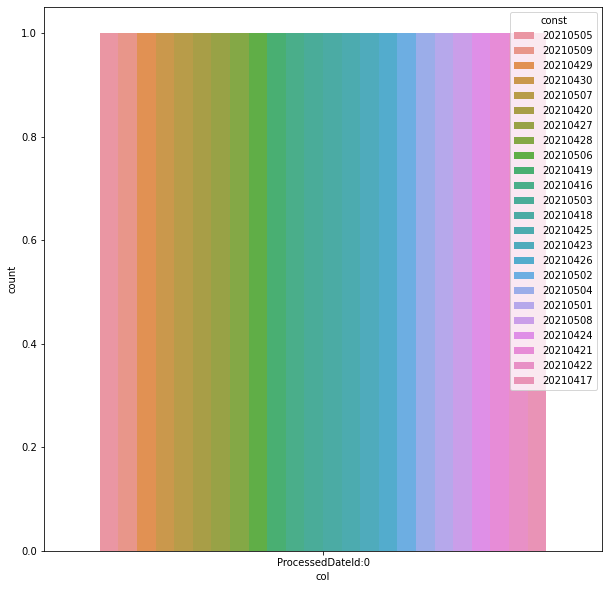

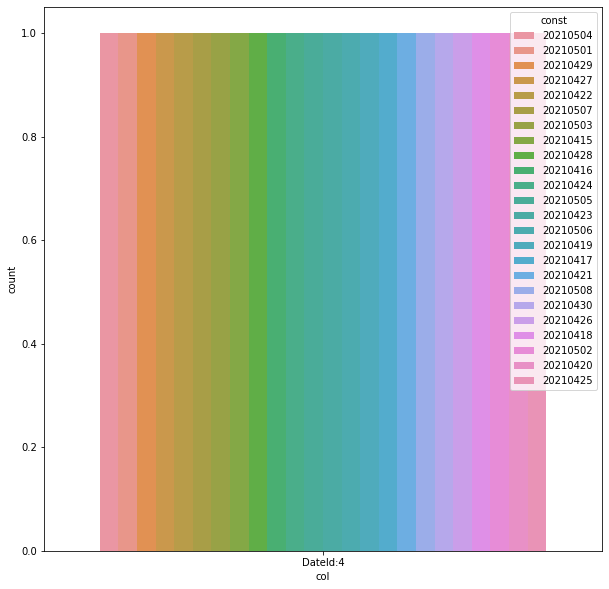

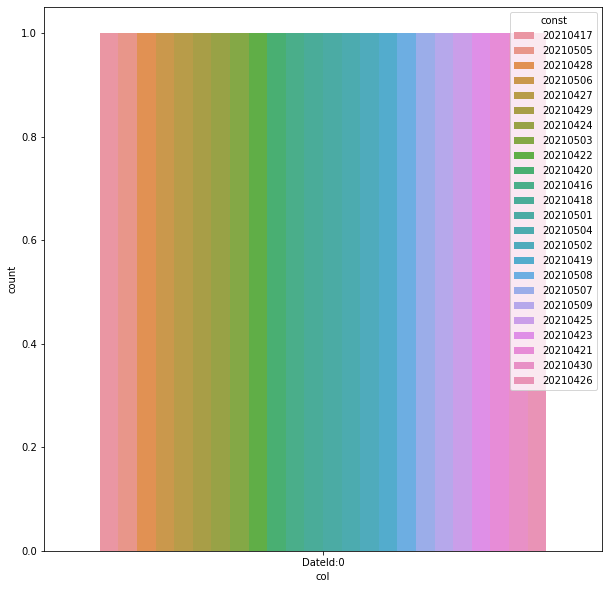

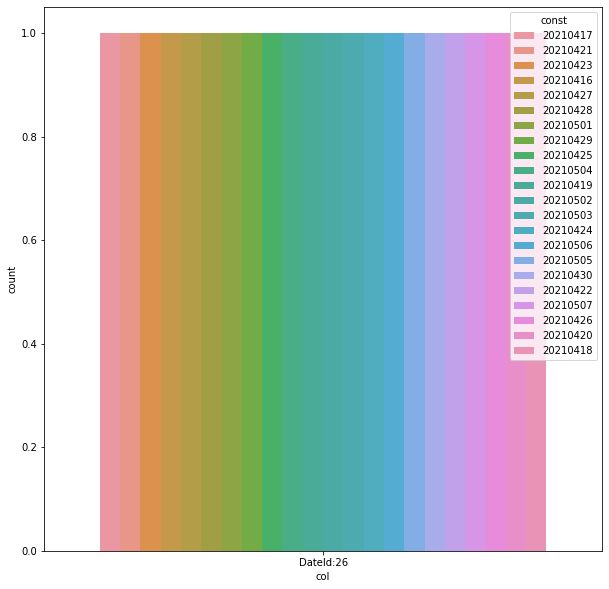

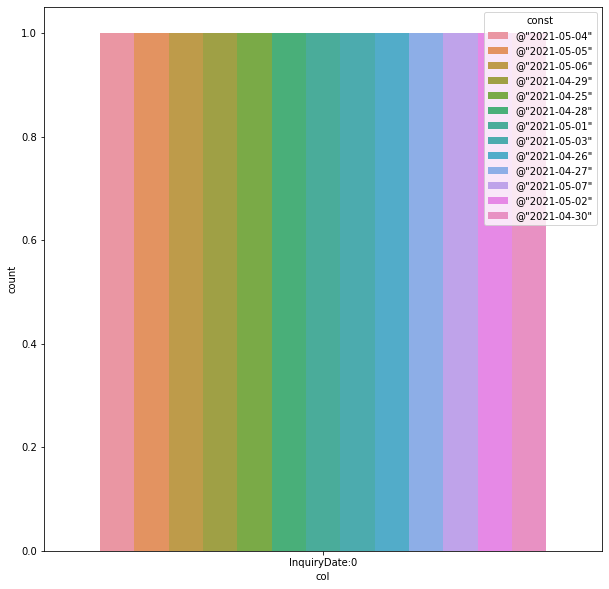

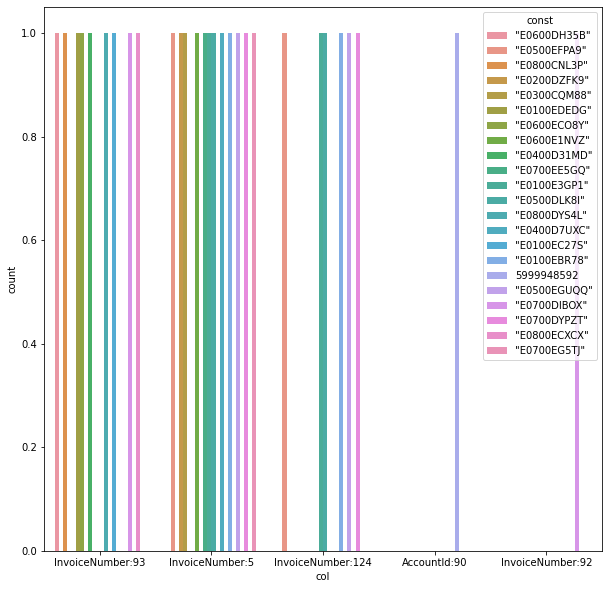

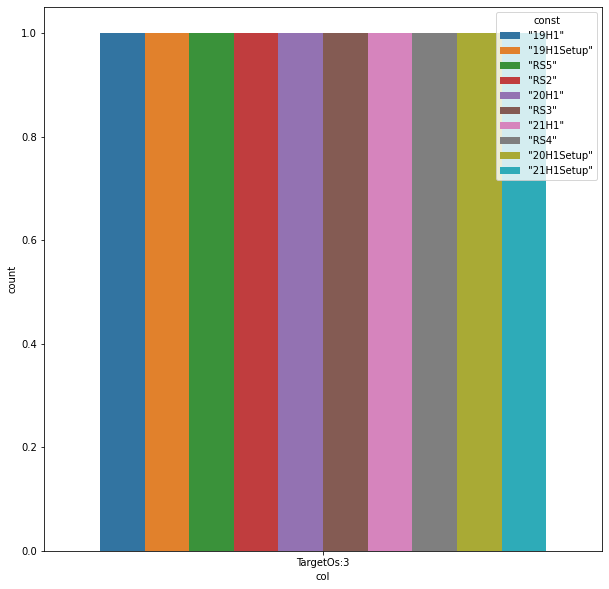

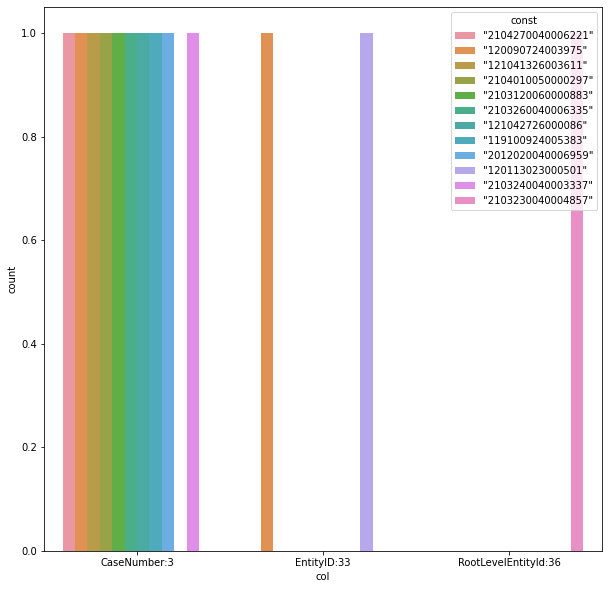

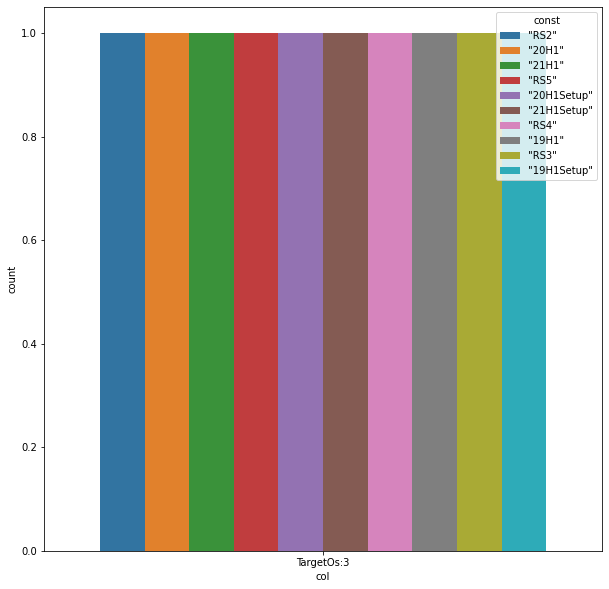

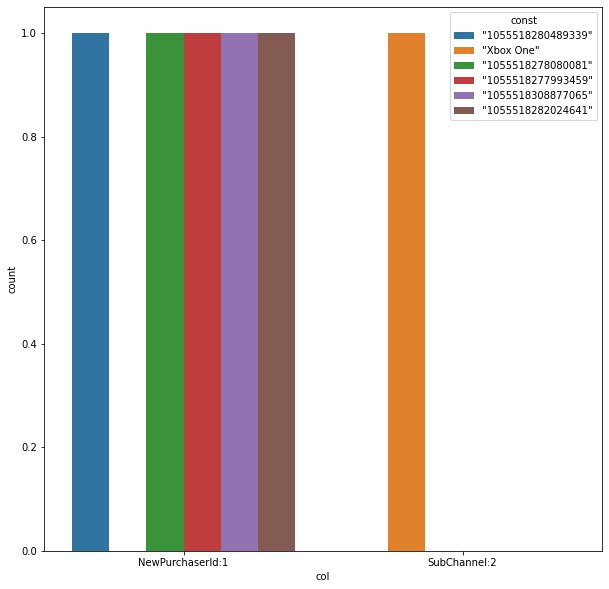

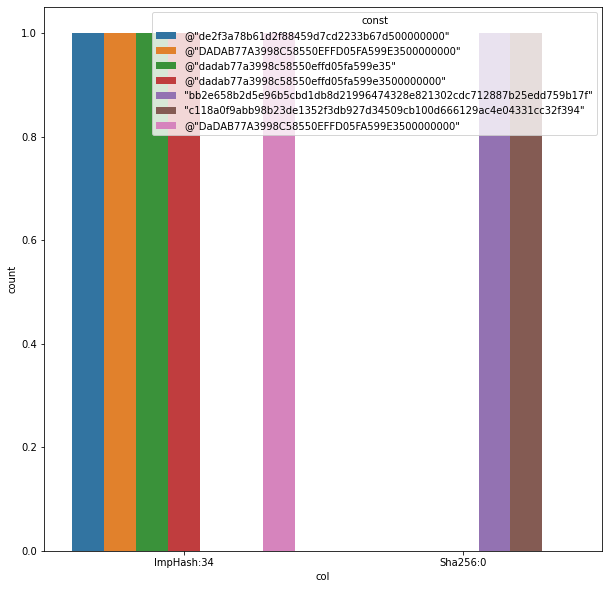

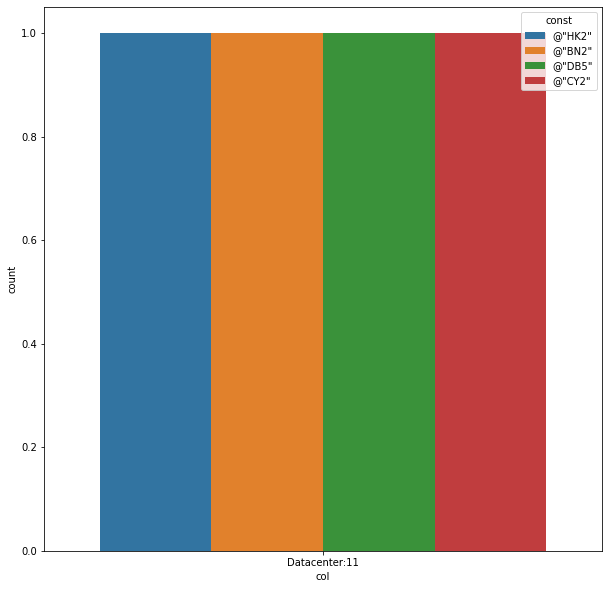

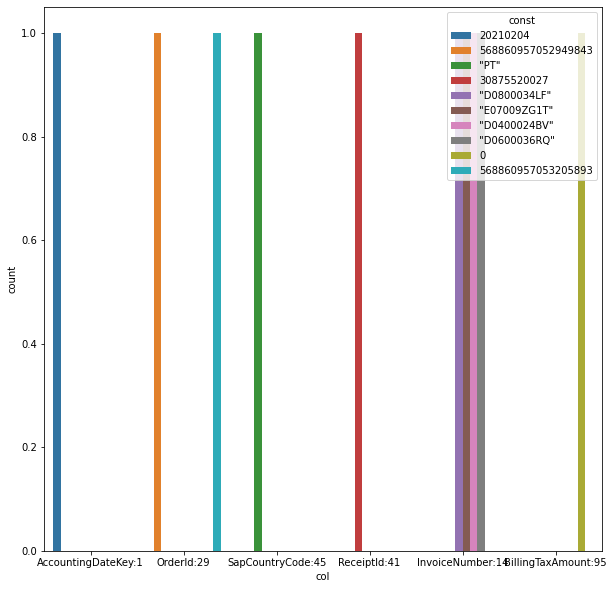

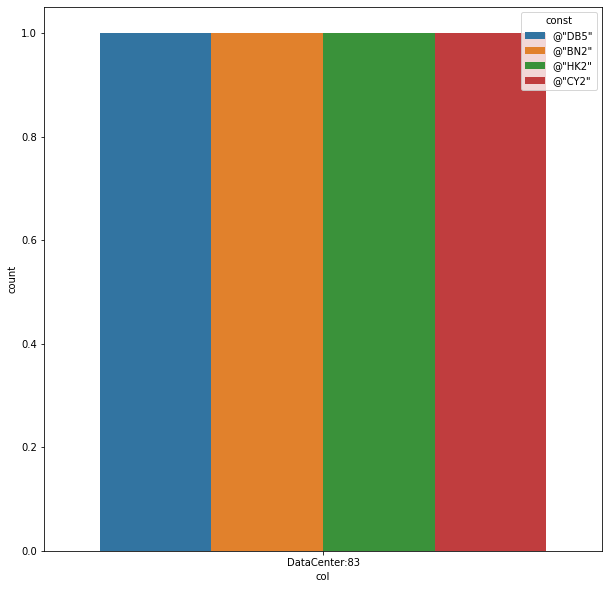

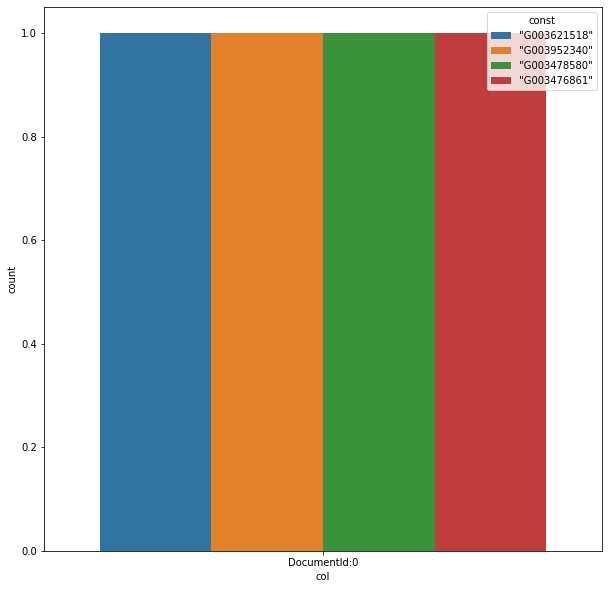

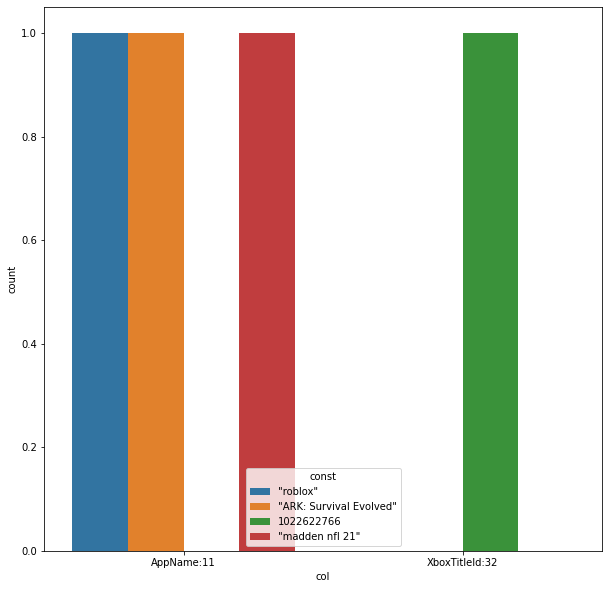

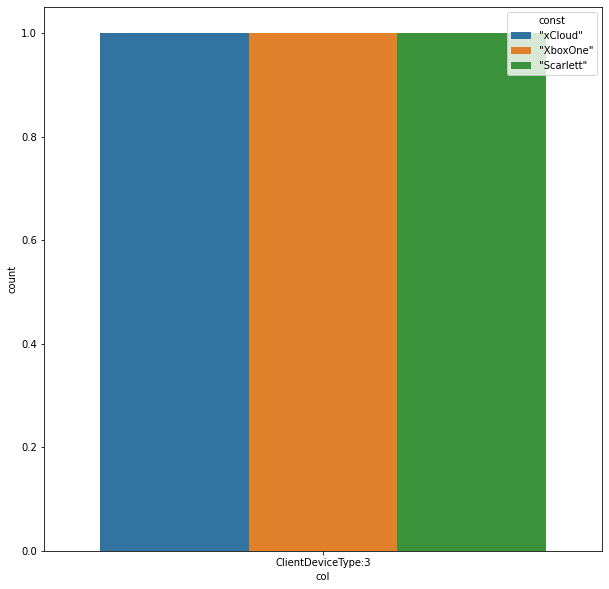

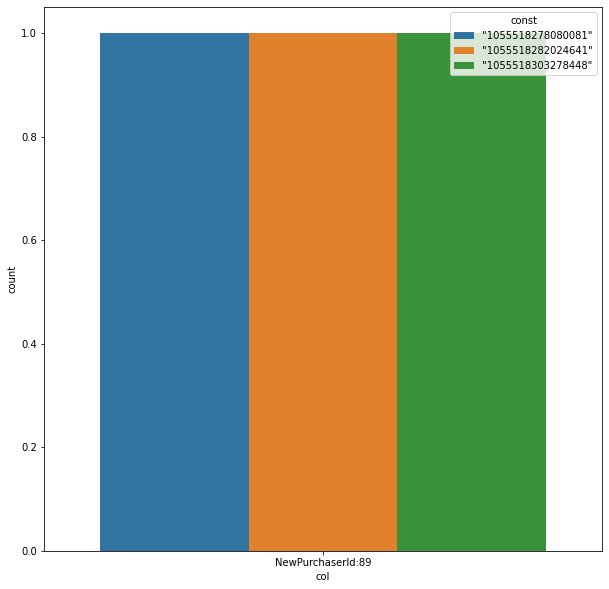

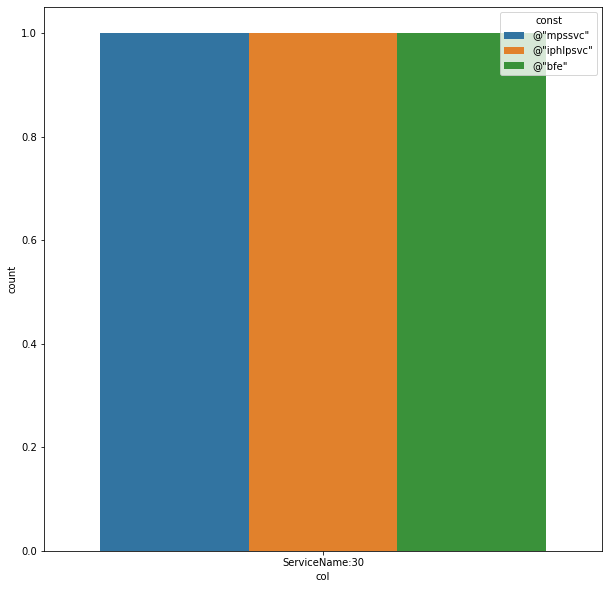

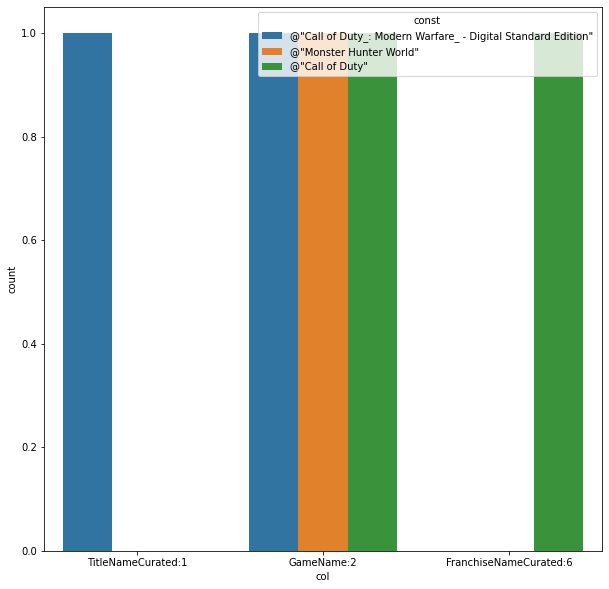

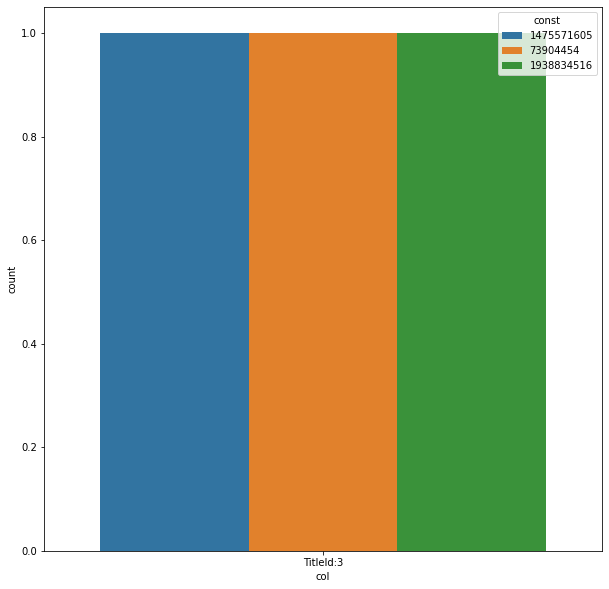

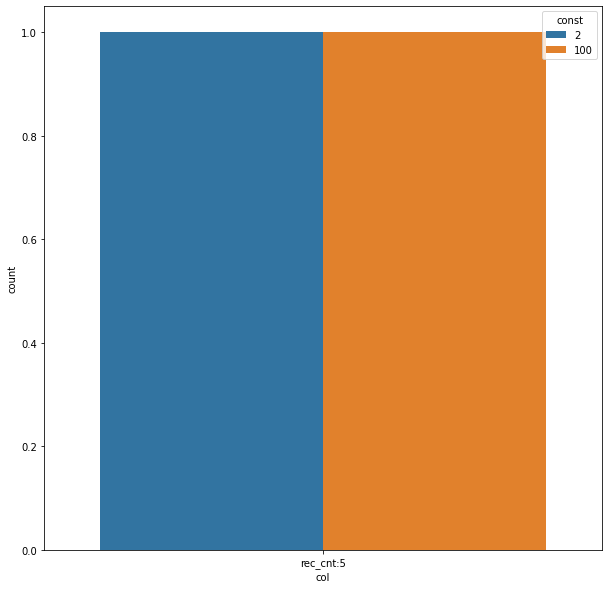

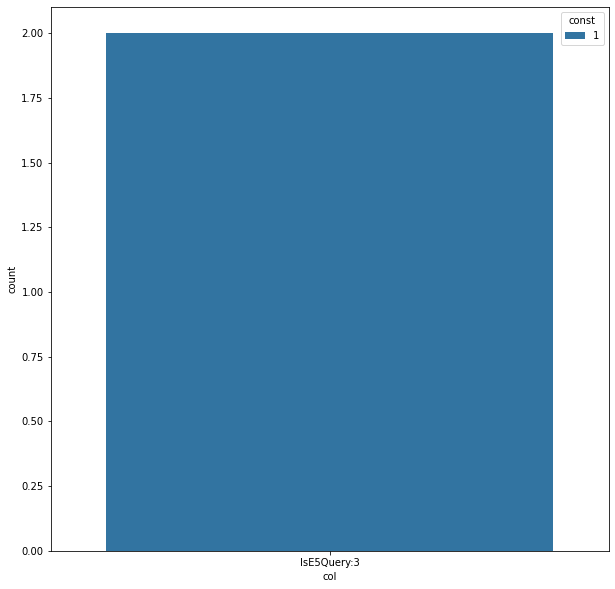

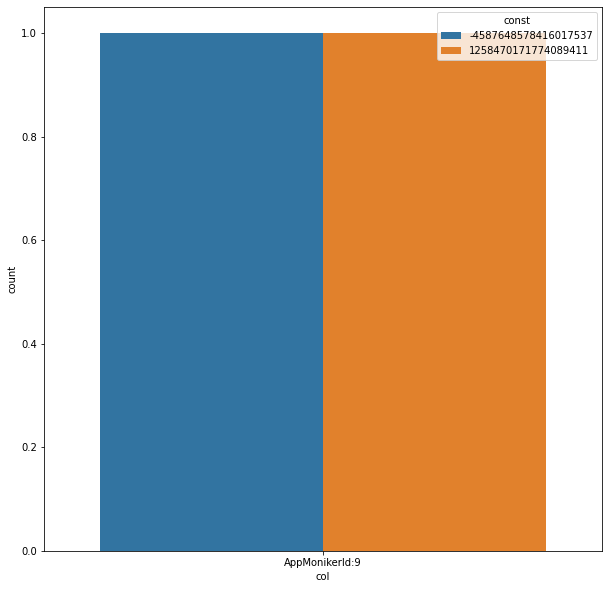

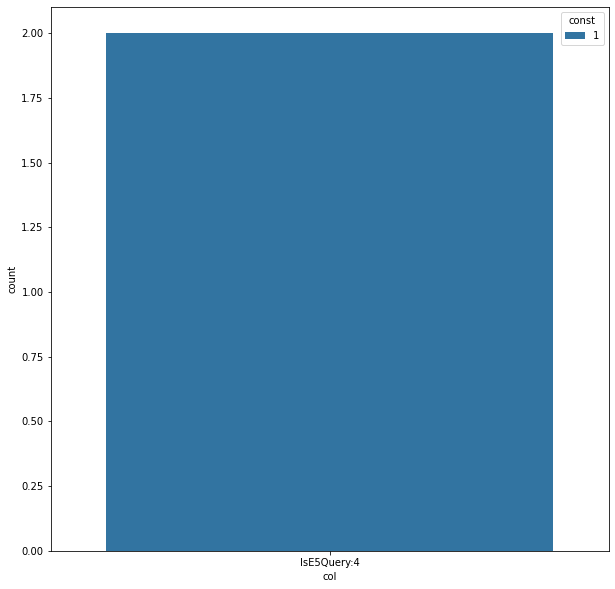

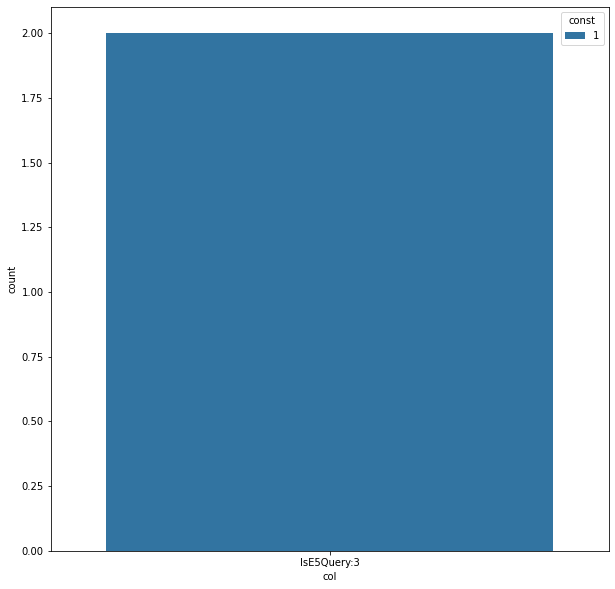

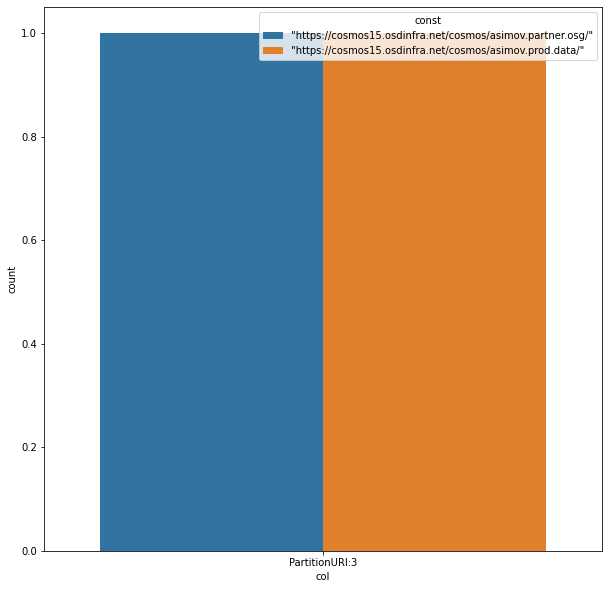

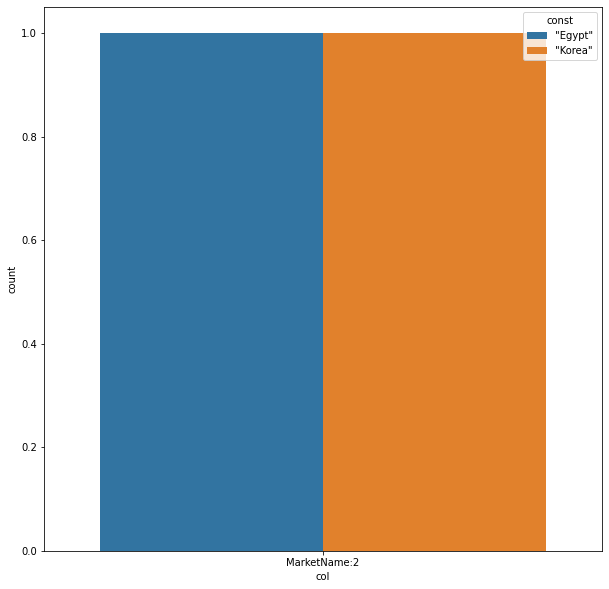

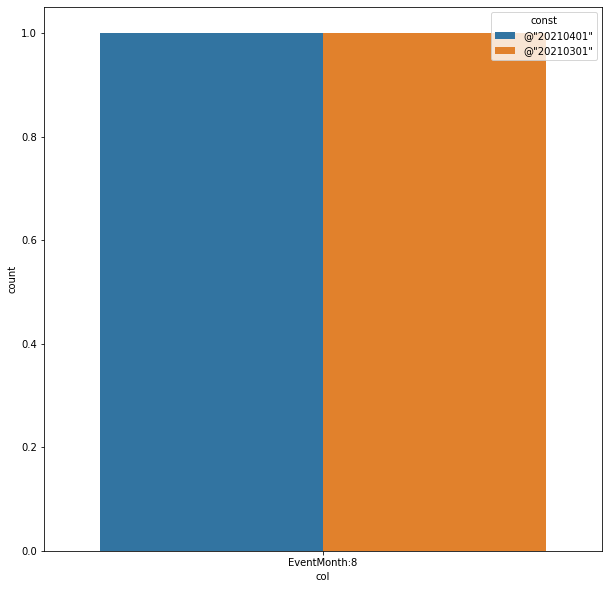

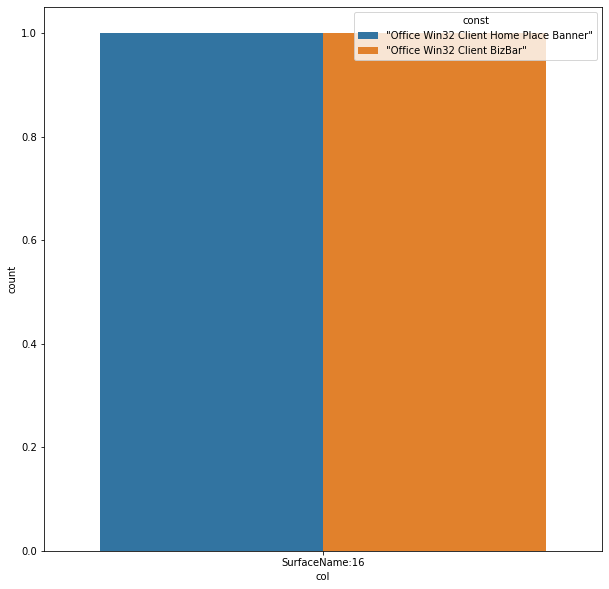

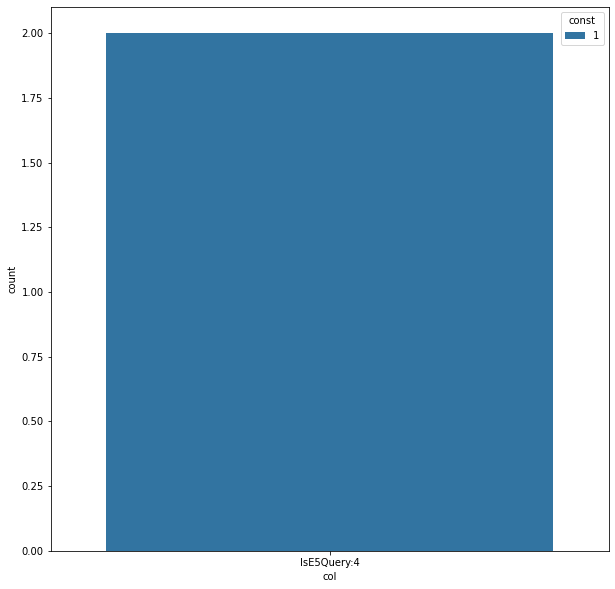

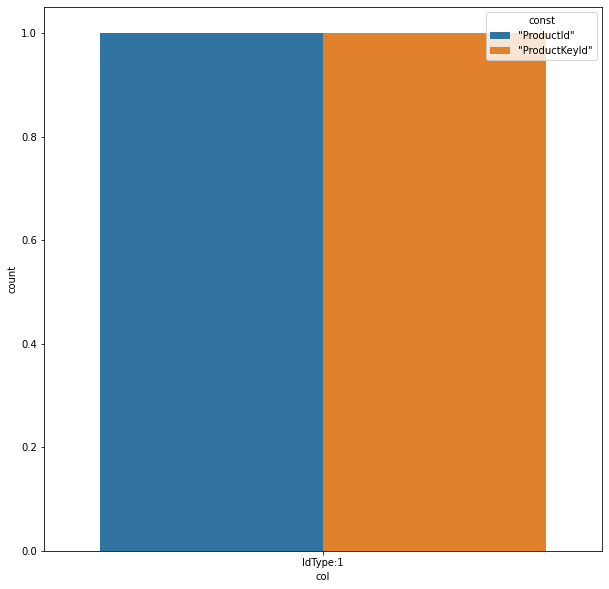

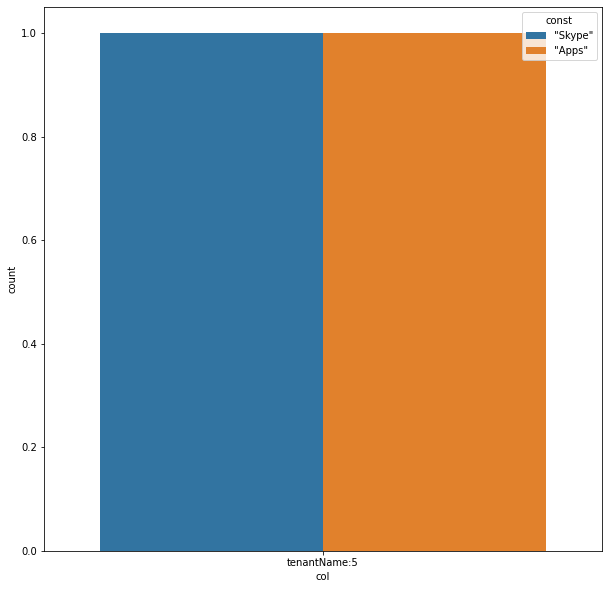

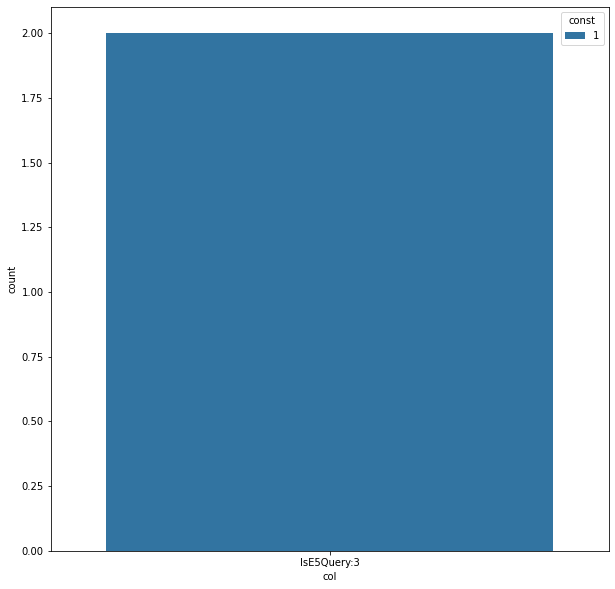

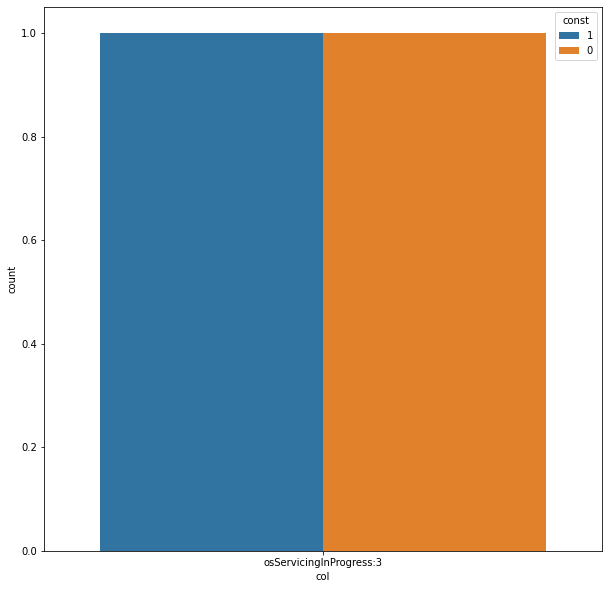

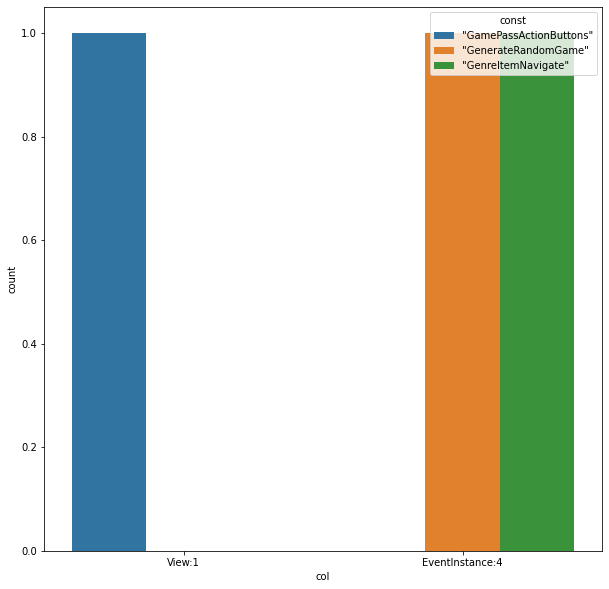

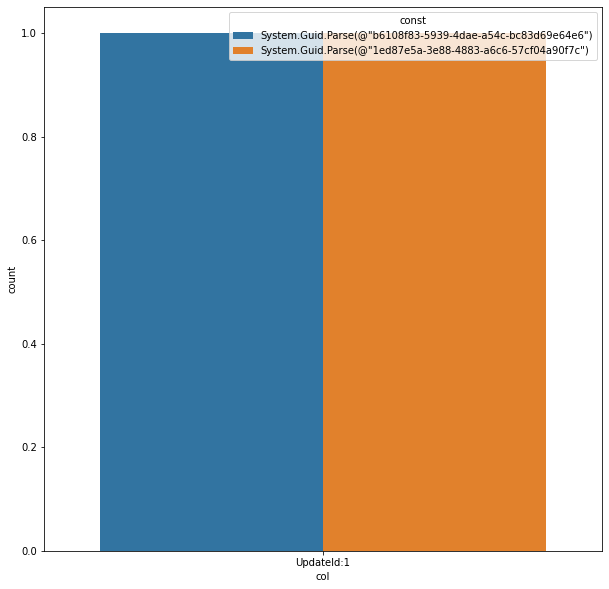

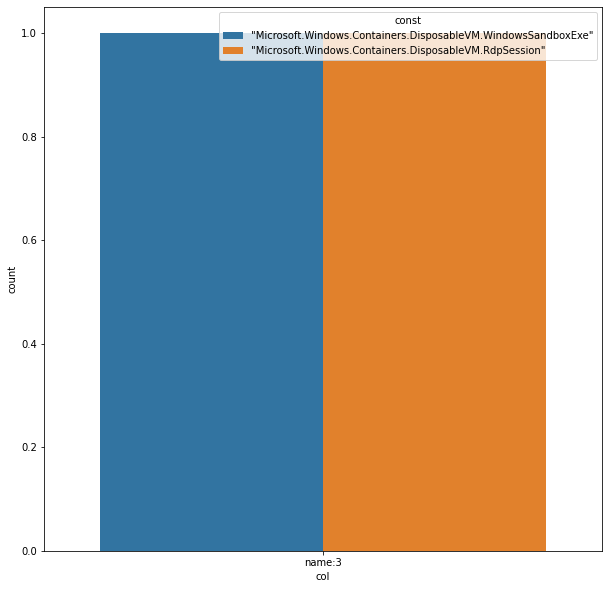

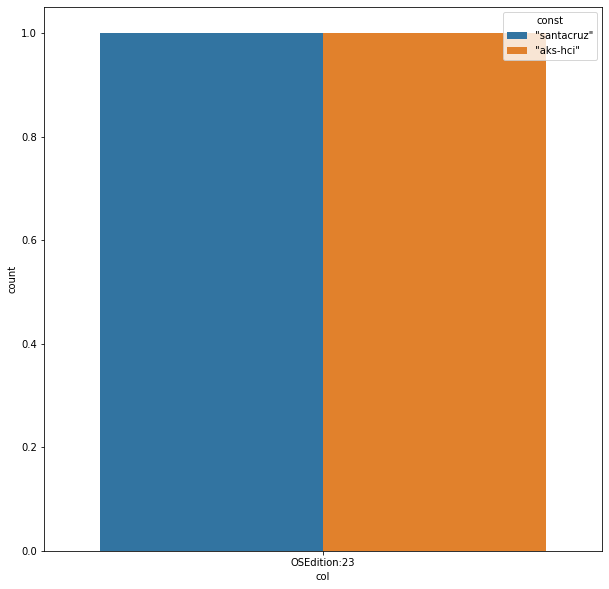

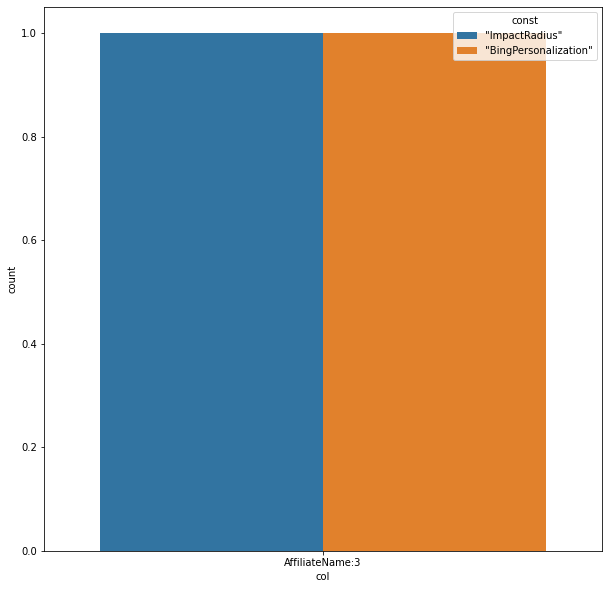

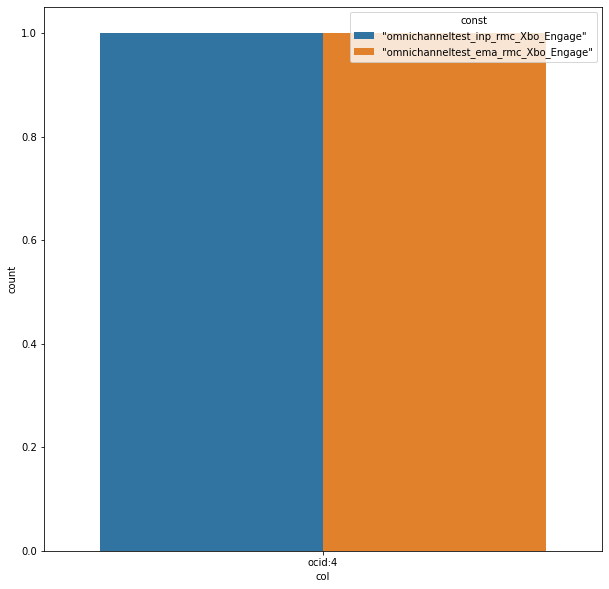

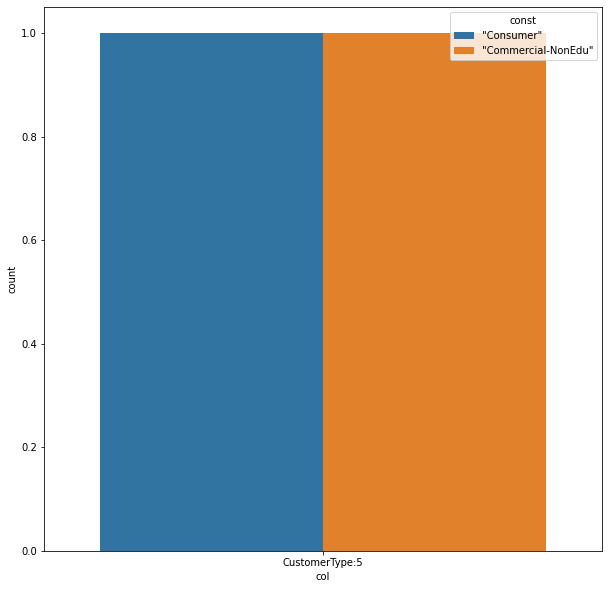

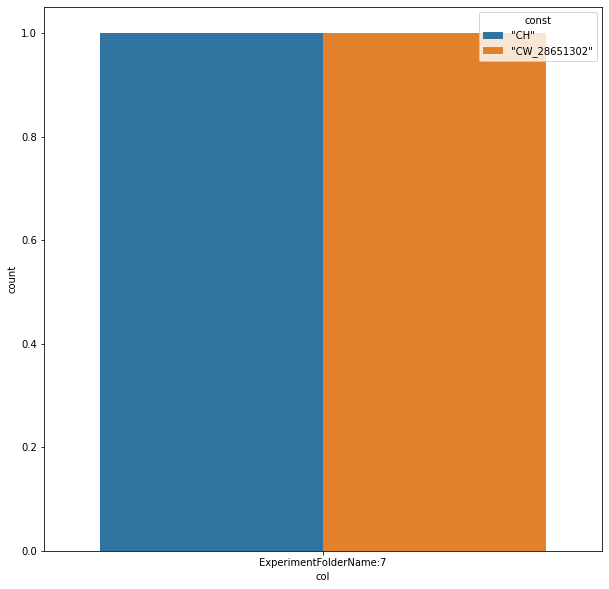

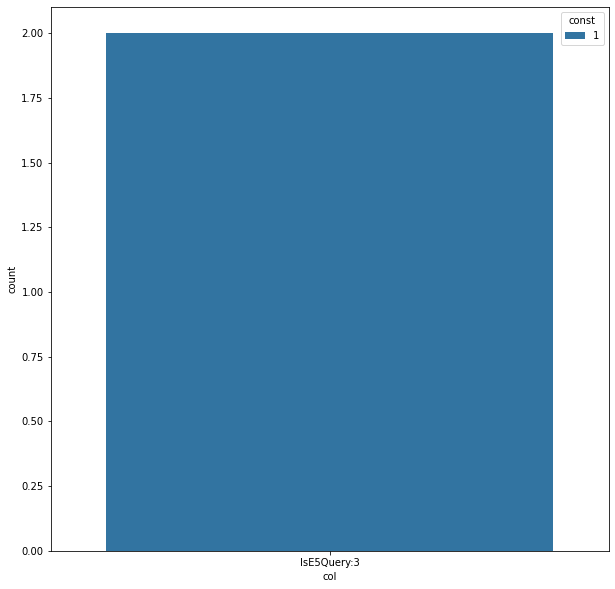

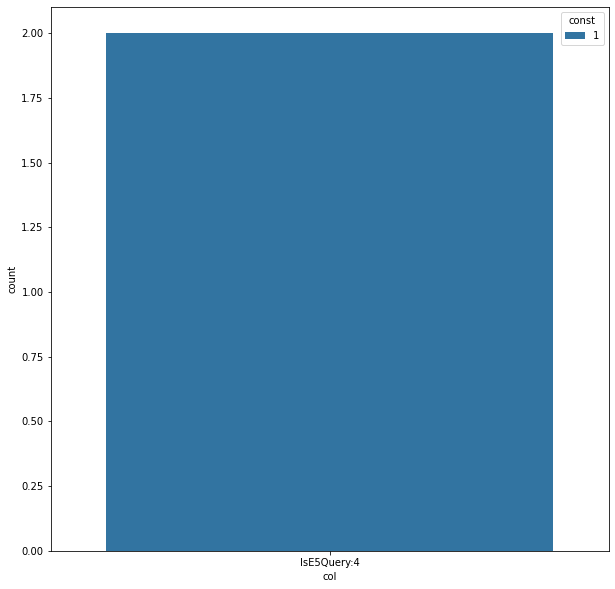

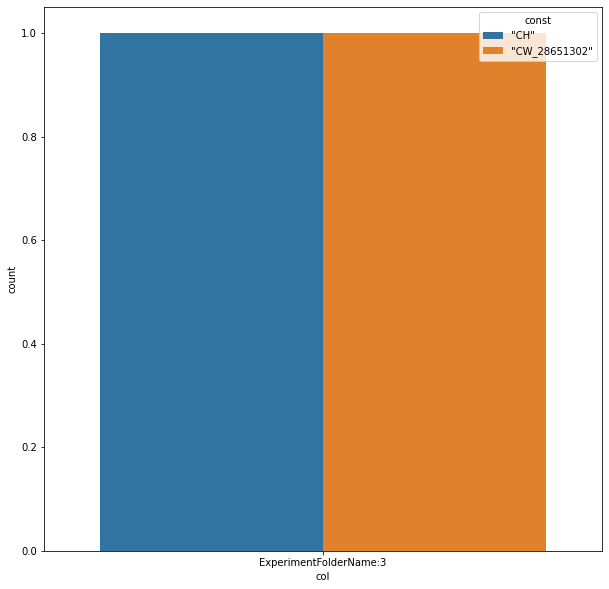

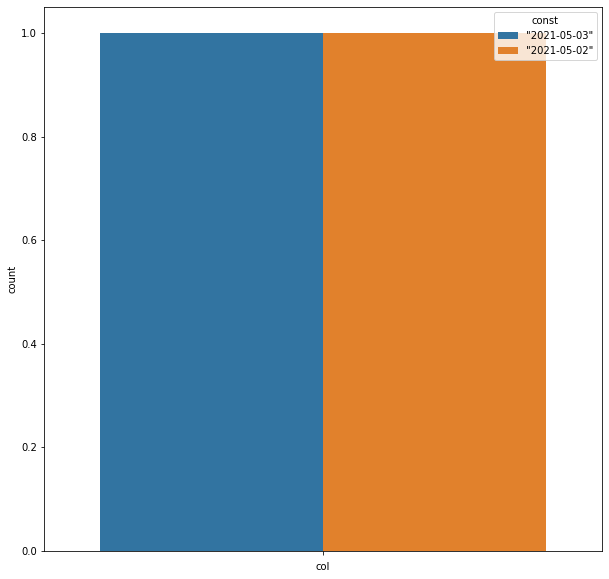

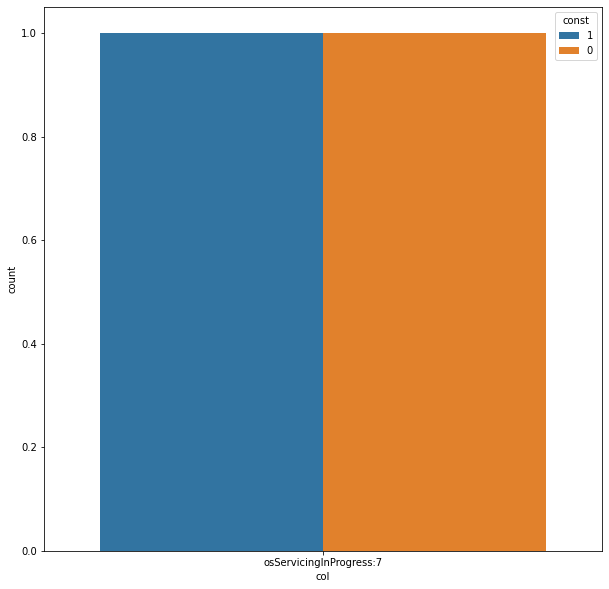

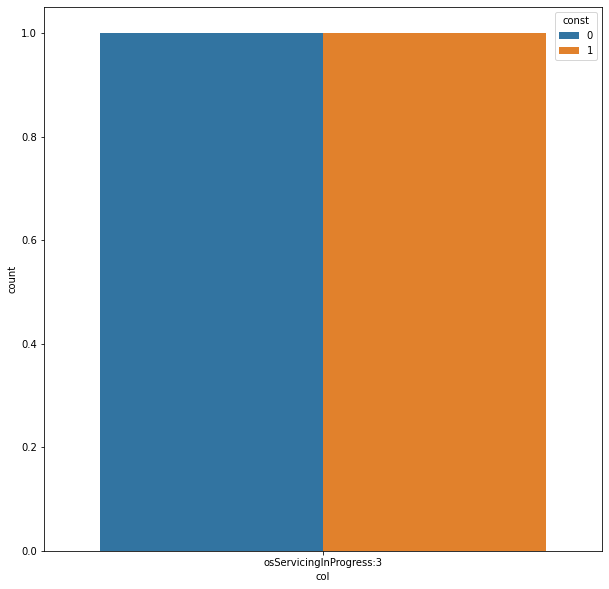

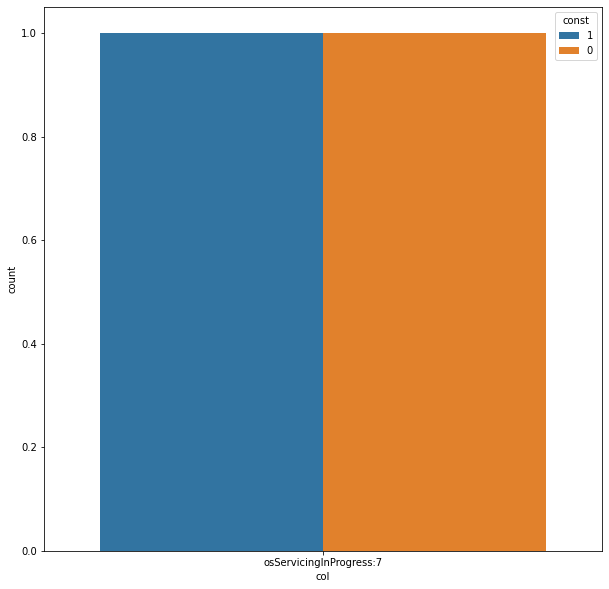

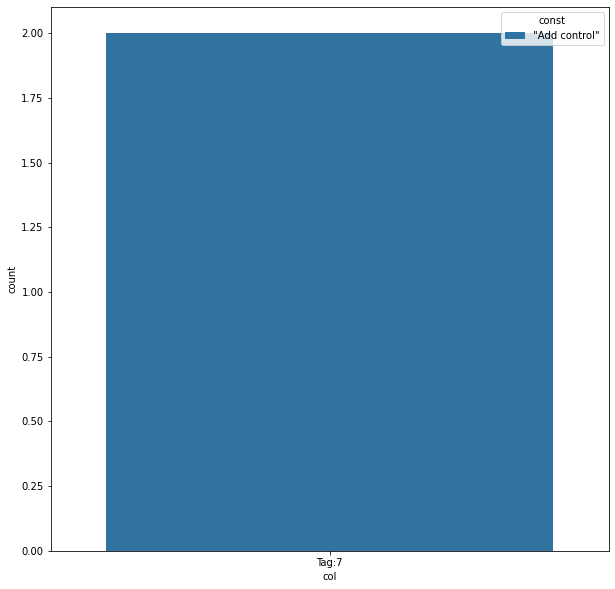

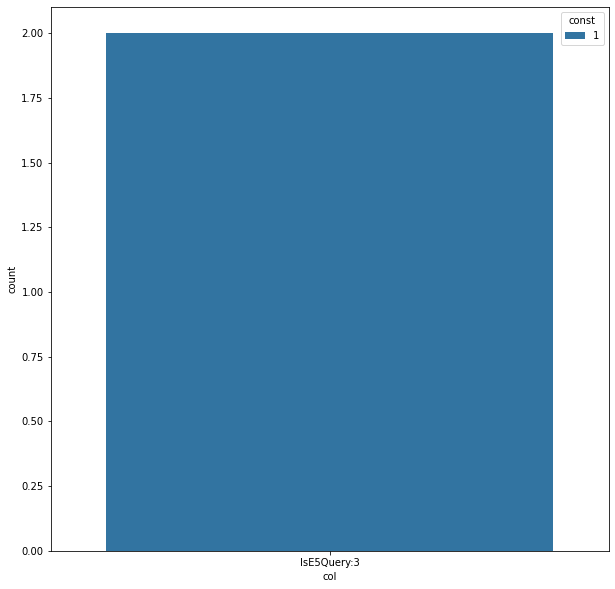

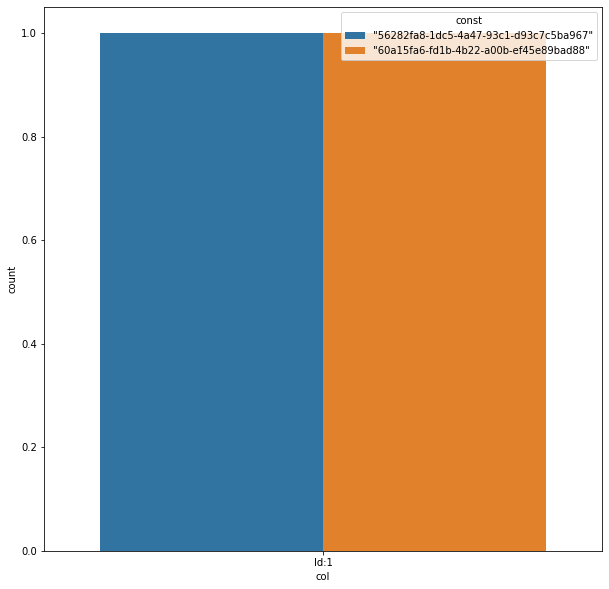

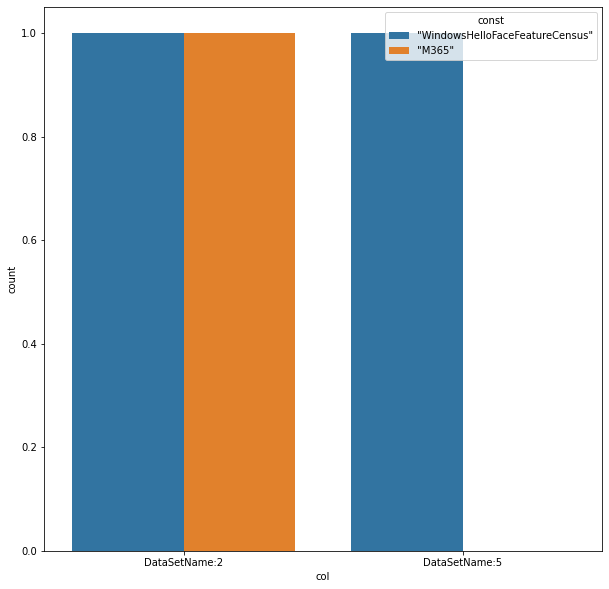

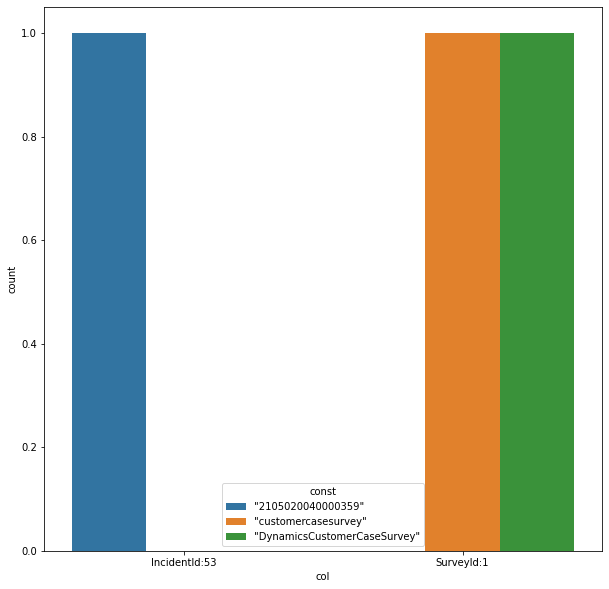

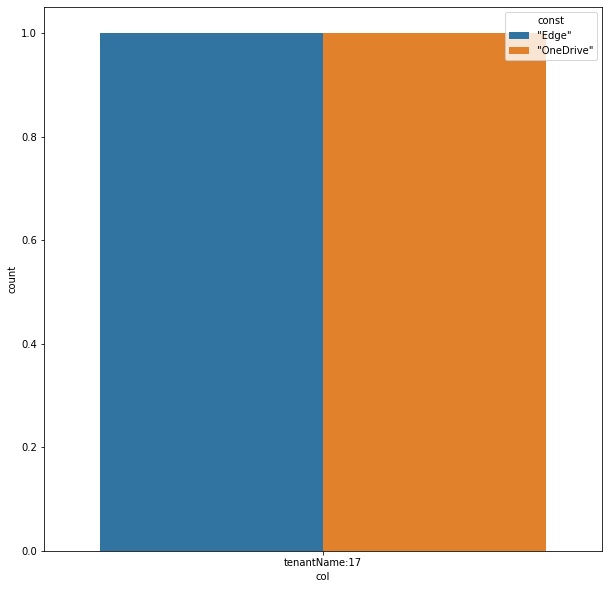

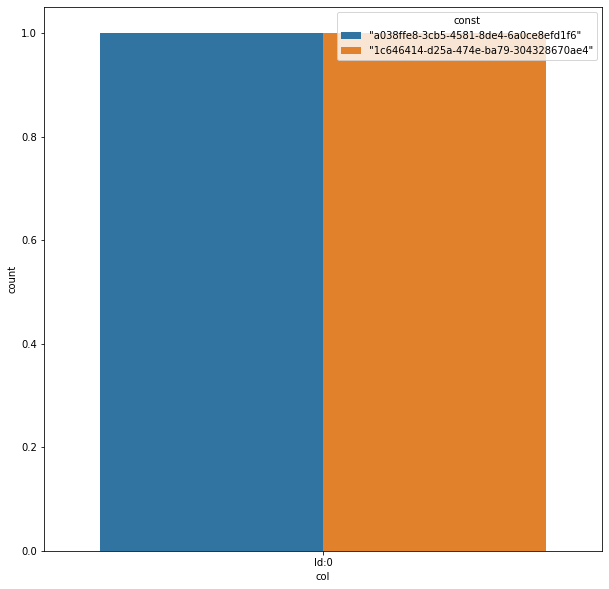

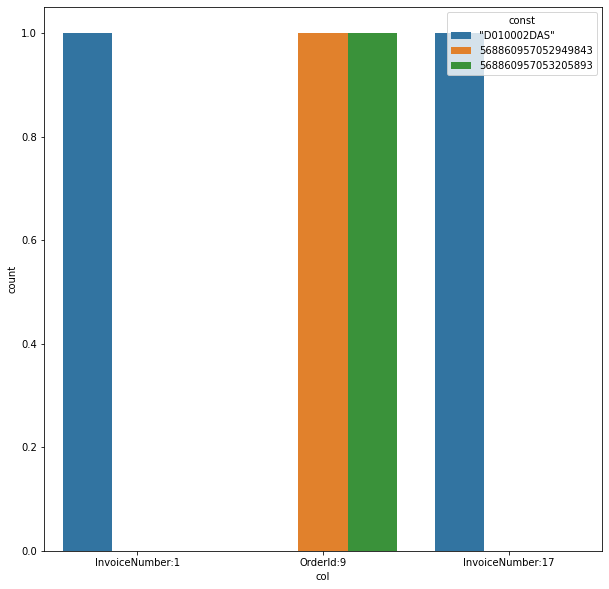

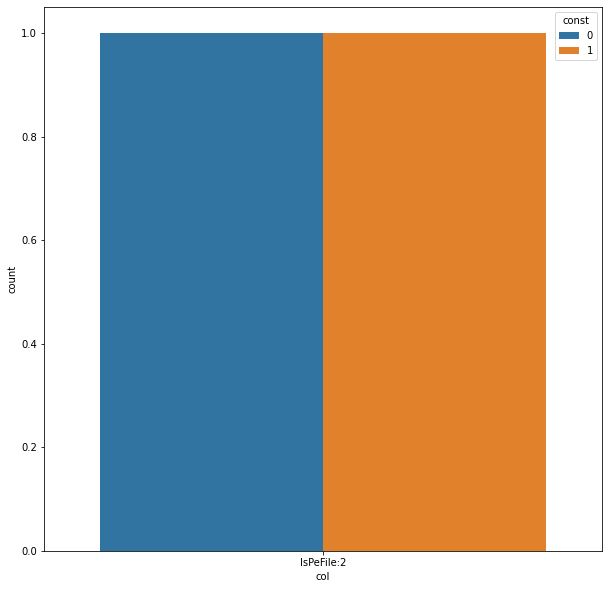

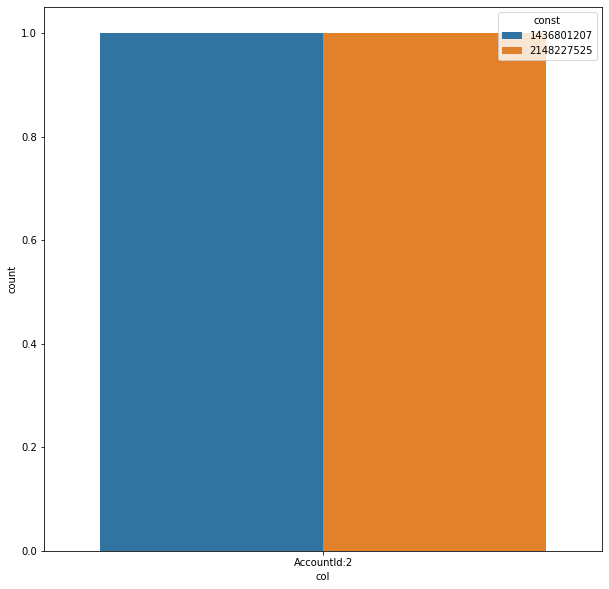

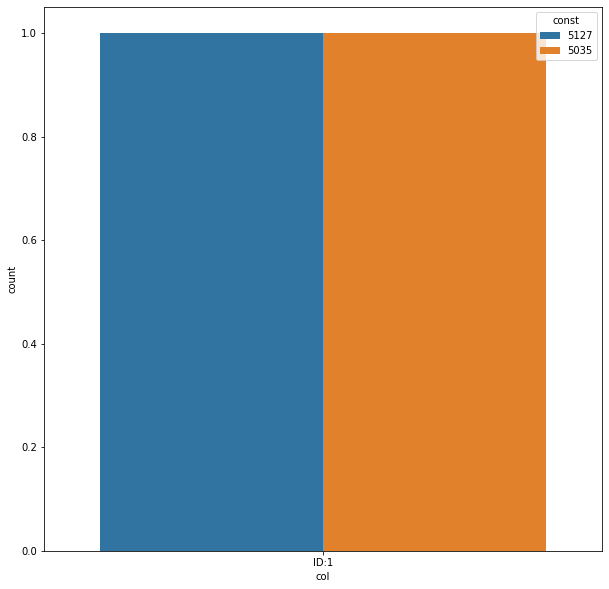

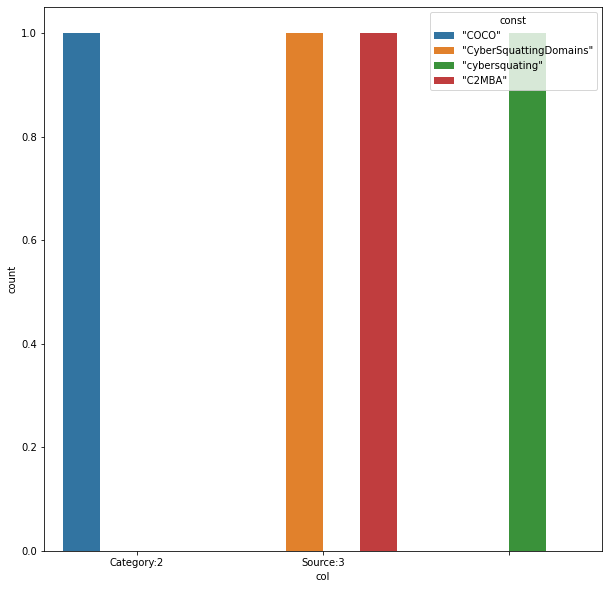

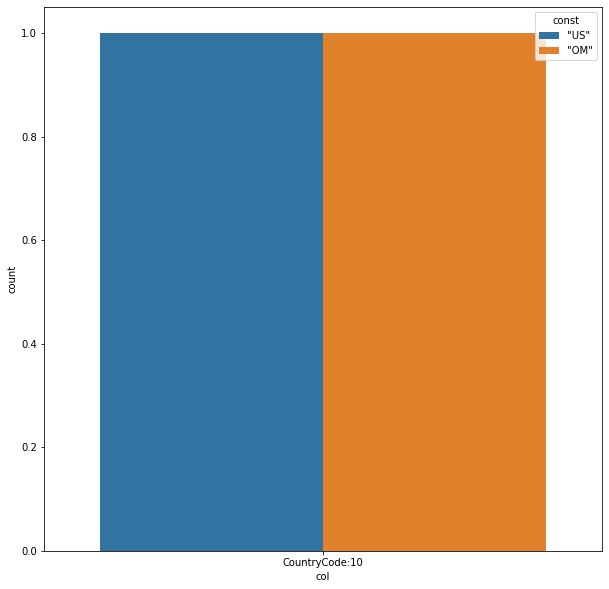

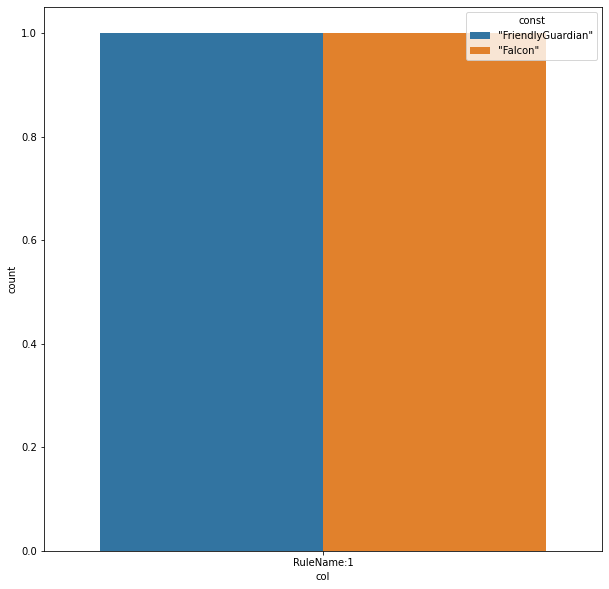

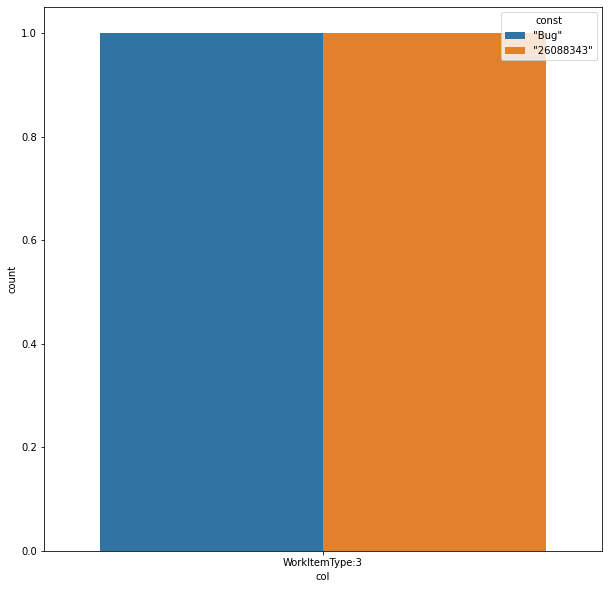

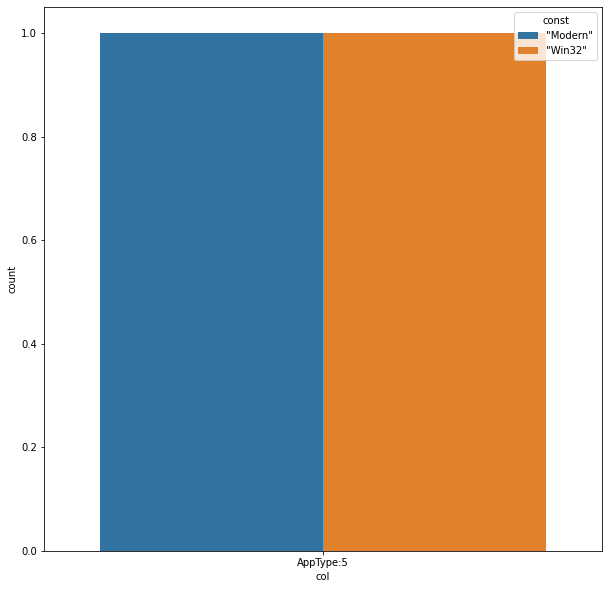

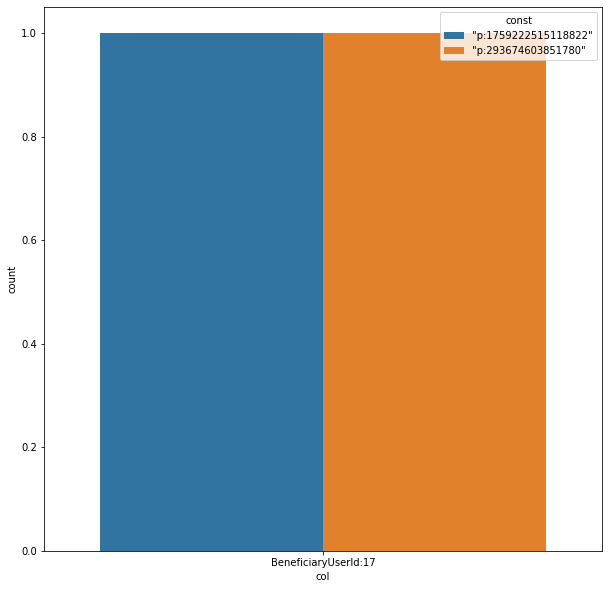

In [45]:
for inp in inpnames:
    tmpdf = discdf[discdf.input == inp]
    fix, ax = plt.subplots(figsize=(10,10))
    #sns.barplot(data=tmpdf, x="col", y = "Selectivity", hue="const", ax=ax)
    sns.countplot(data=tmpdf, x="col", hue="const", ax=ax)
    #plt.legend().remove()
    plt.show()

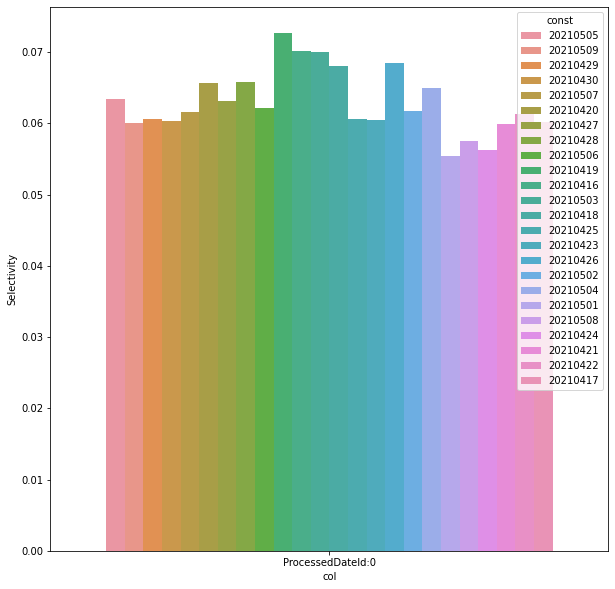

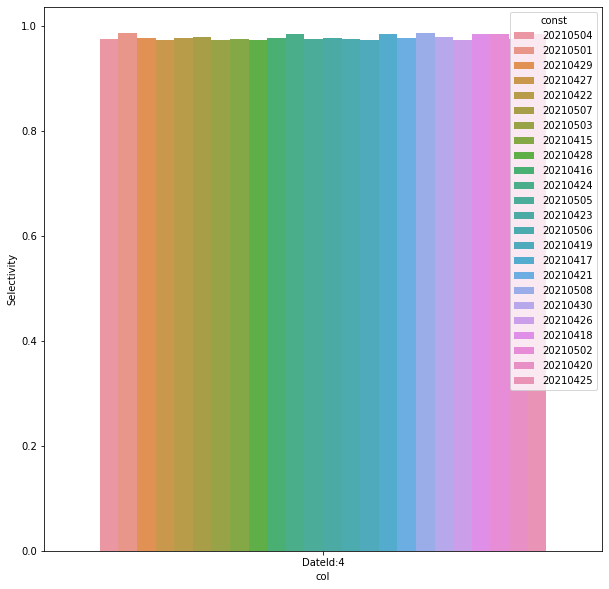

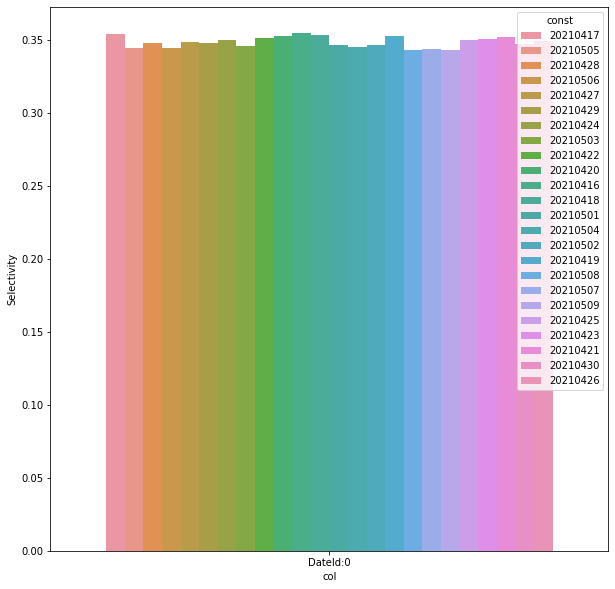

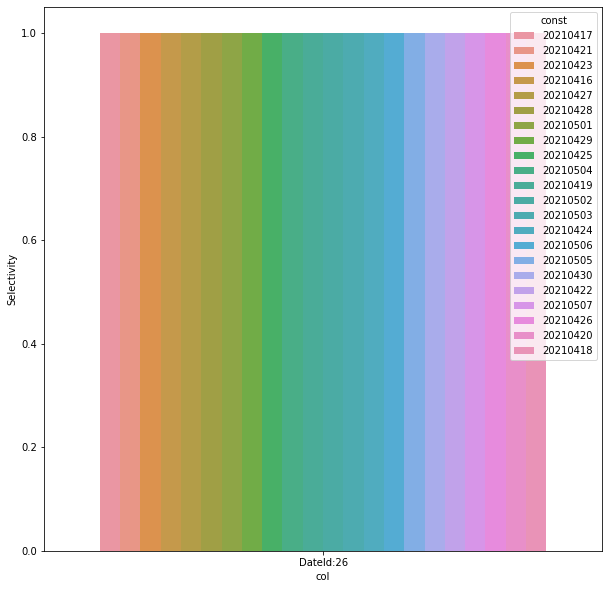

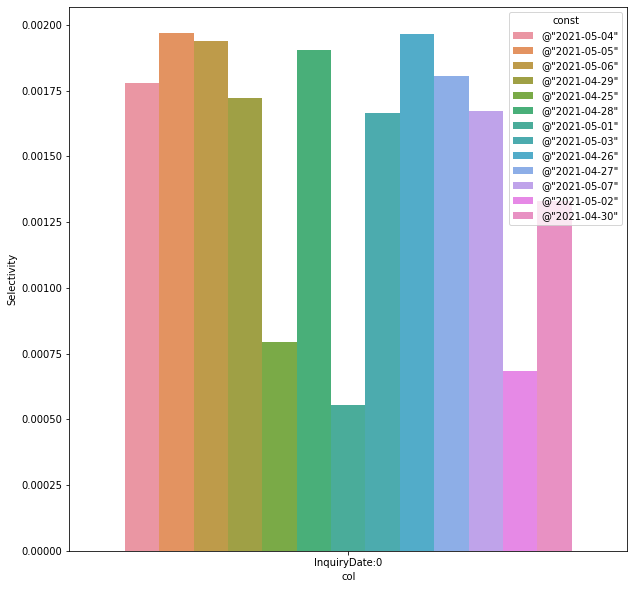

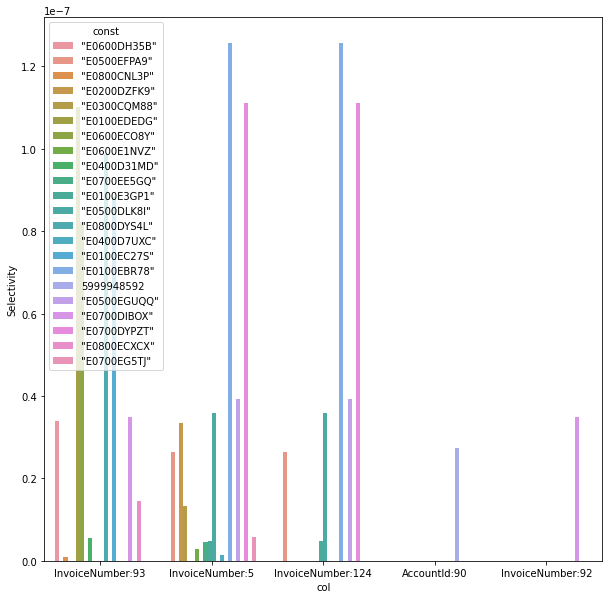

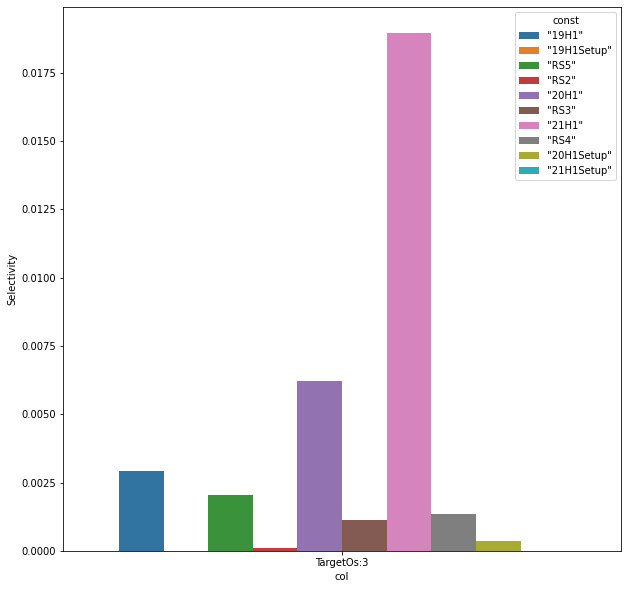

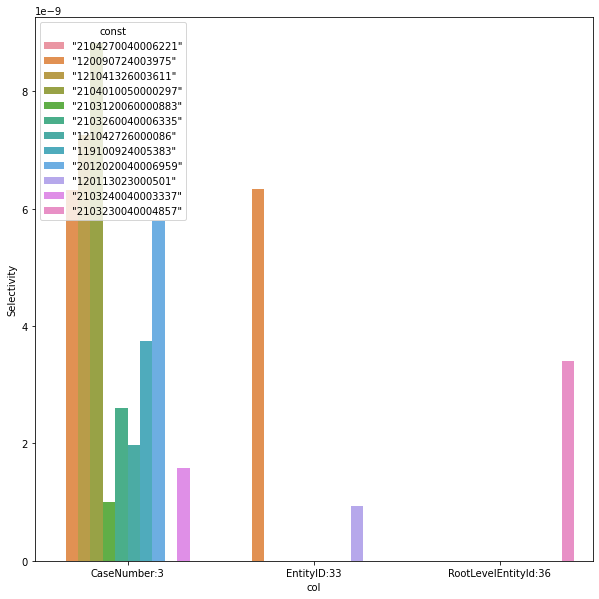

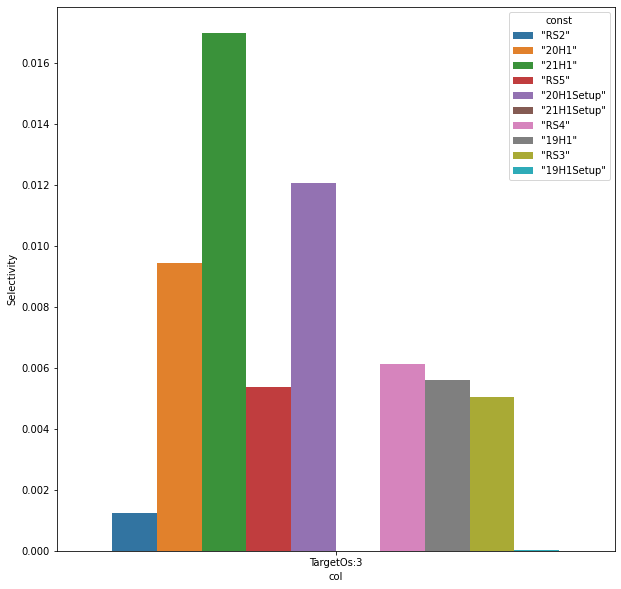

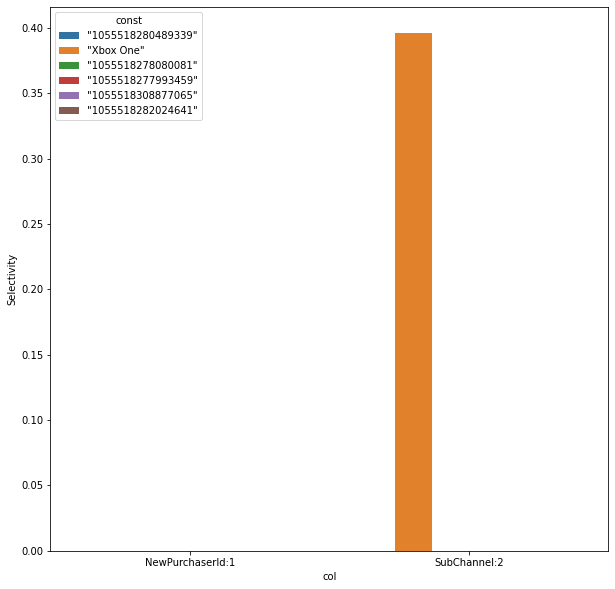

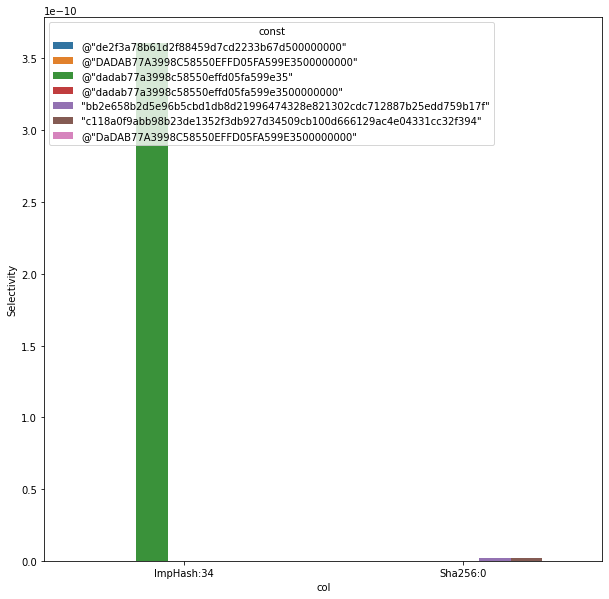

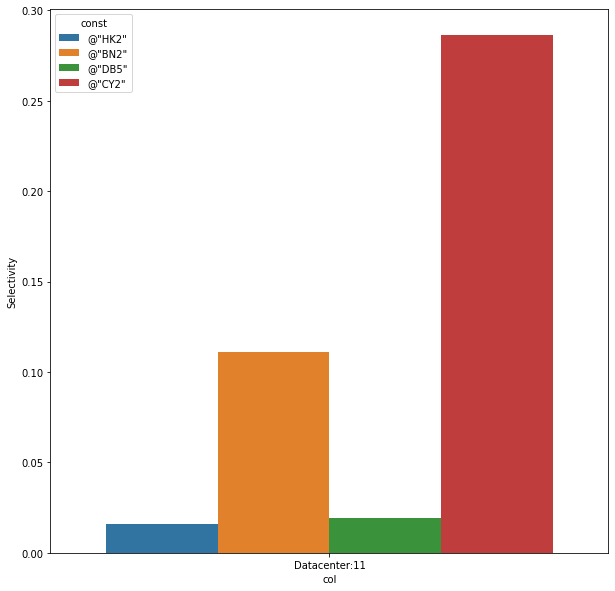

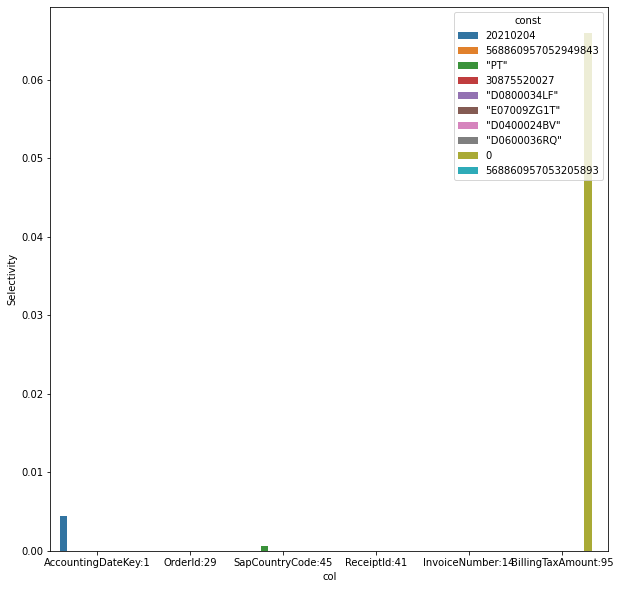

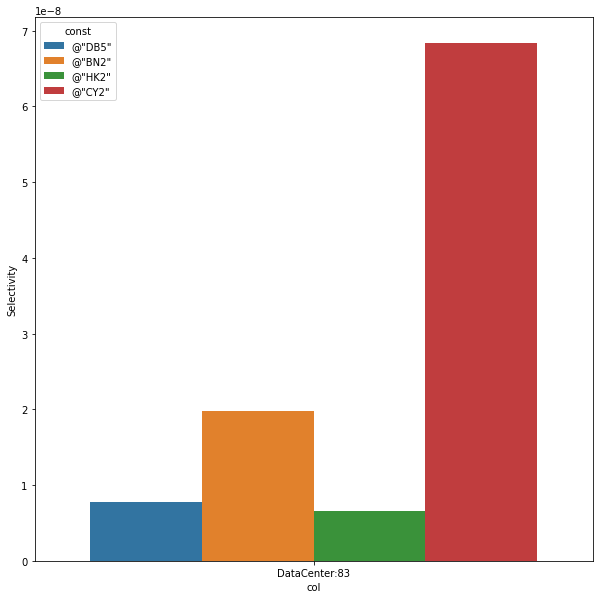

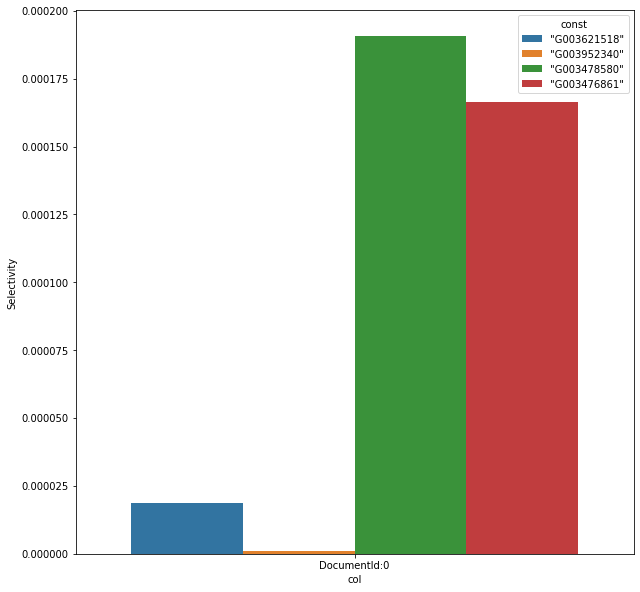

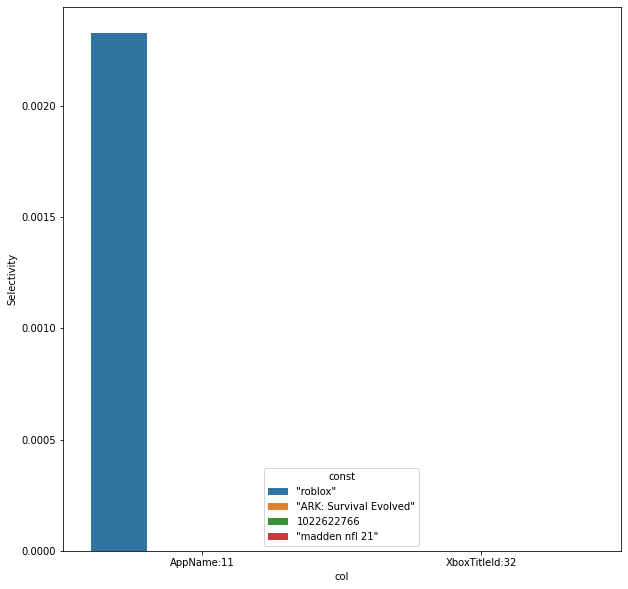

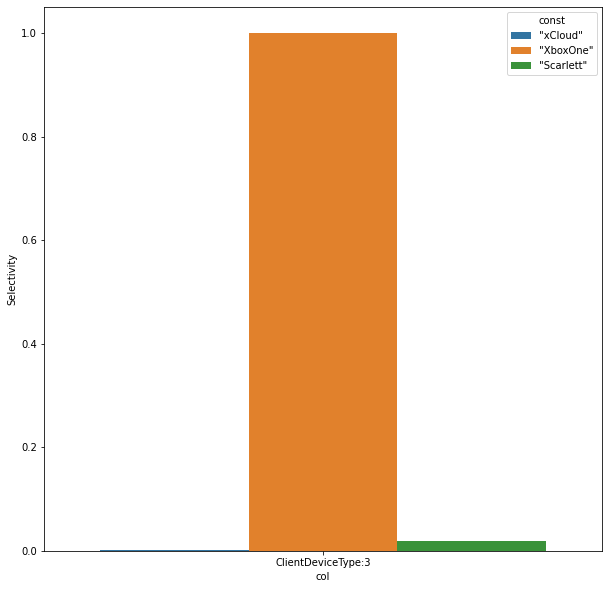

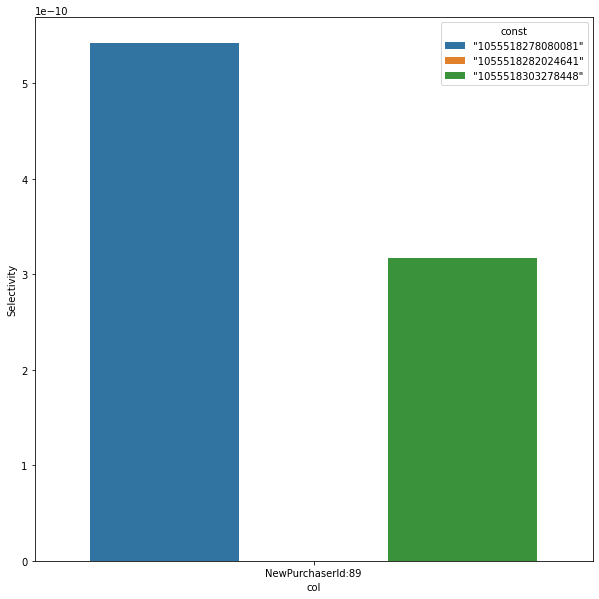

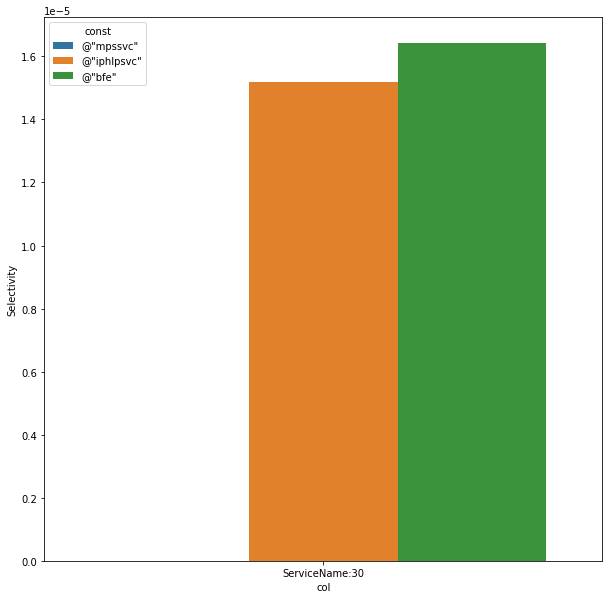

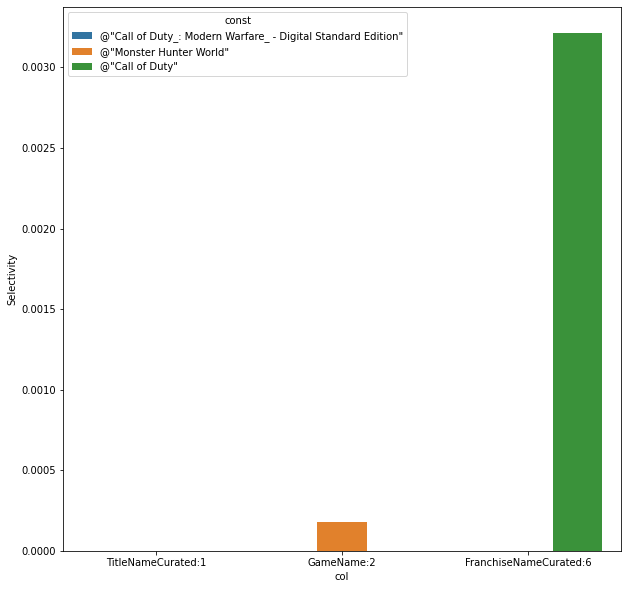

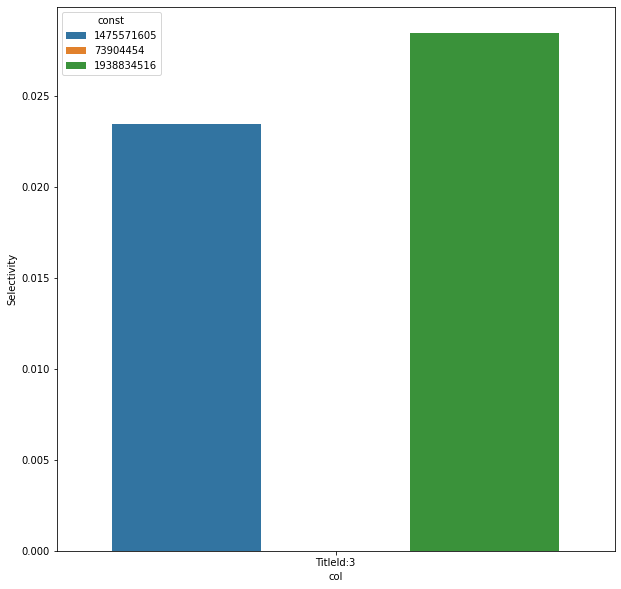

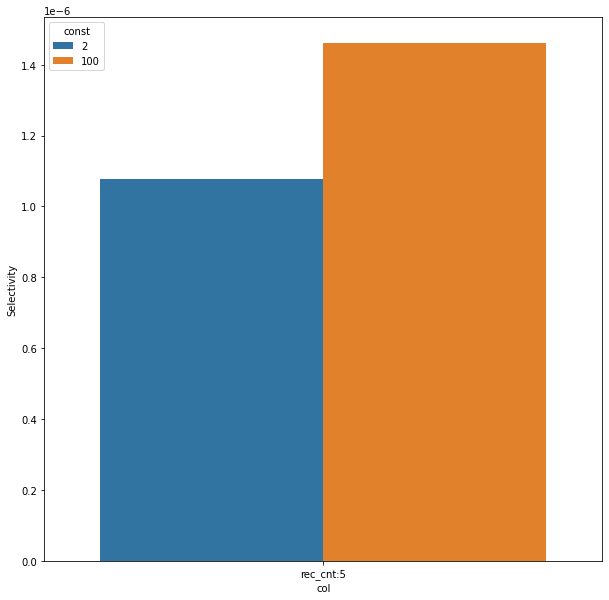

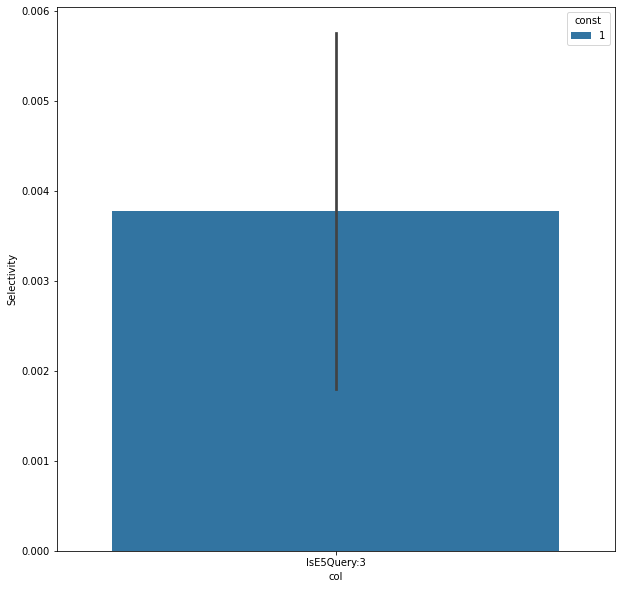

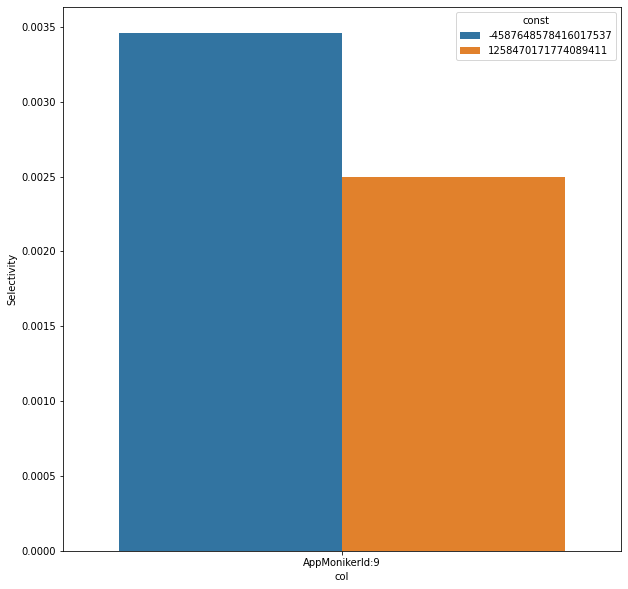

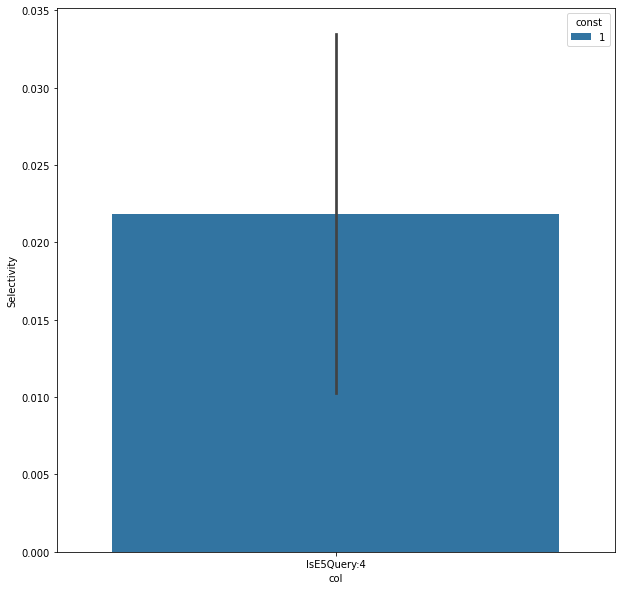

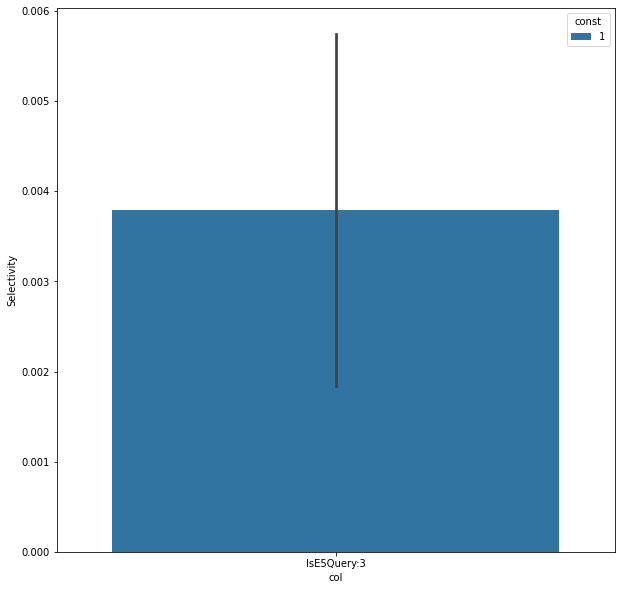

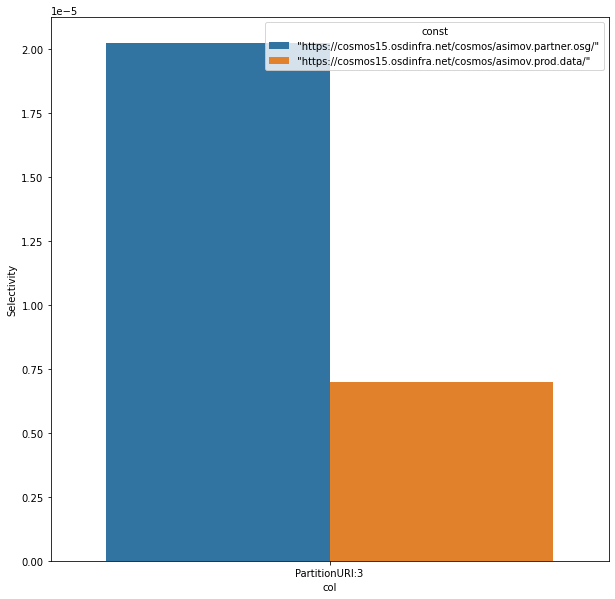

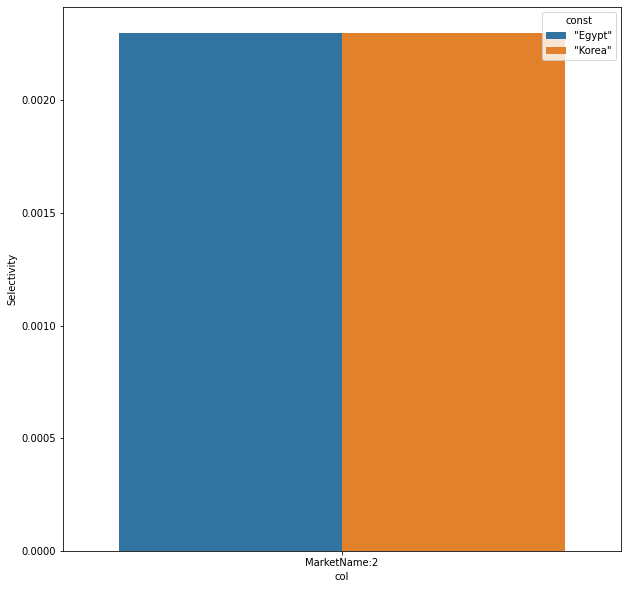

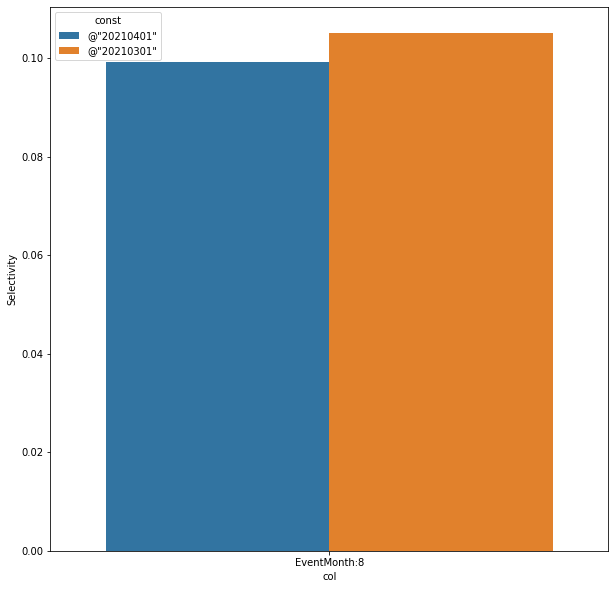

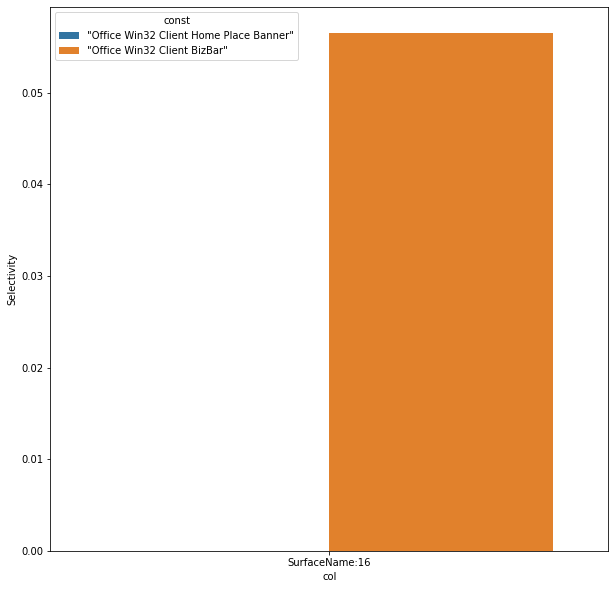

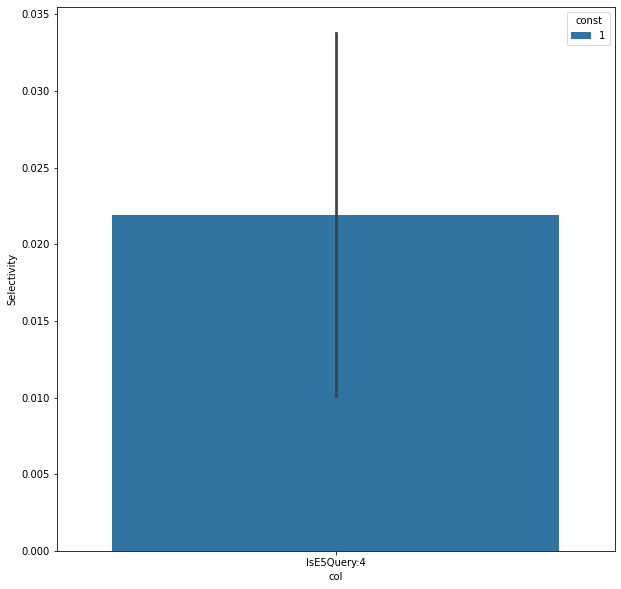

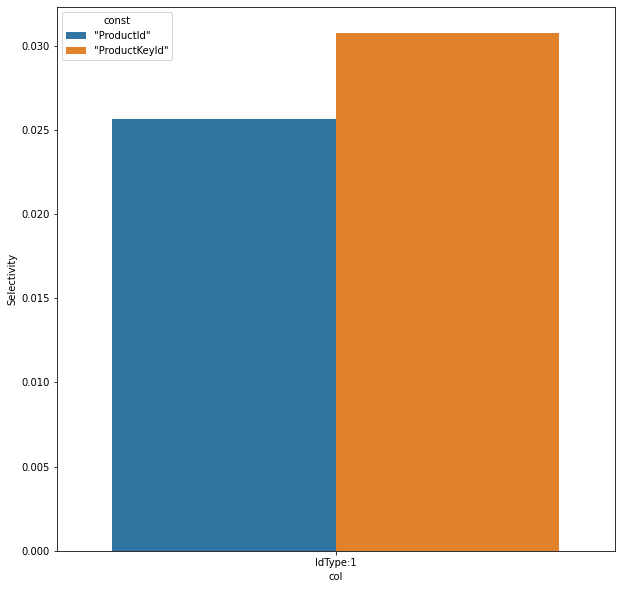

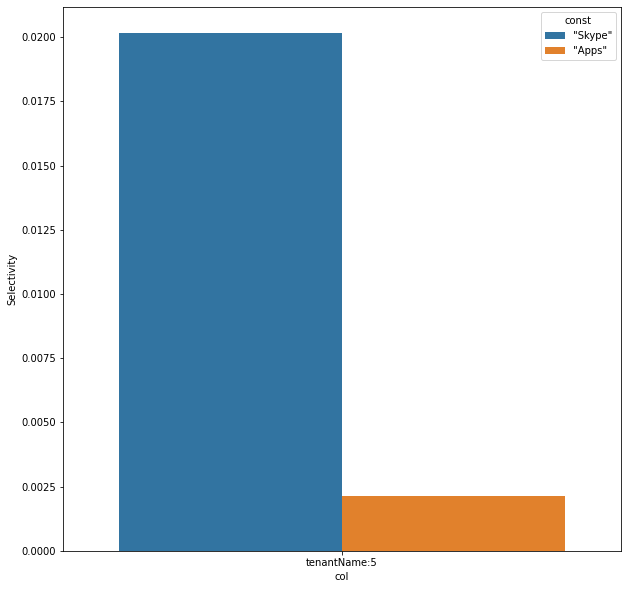

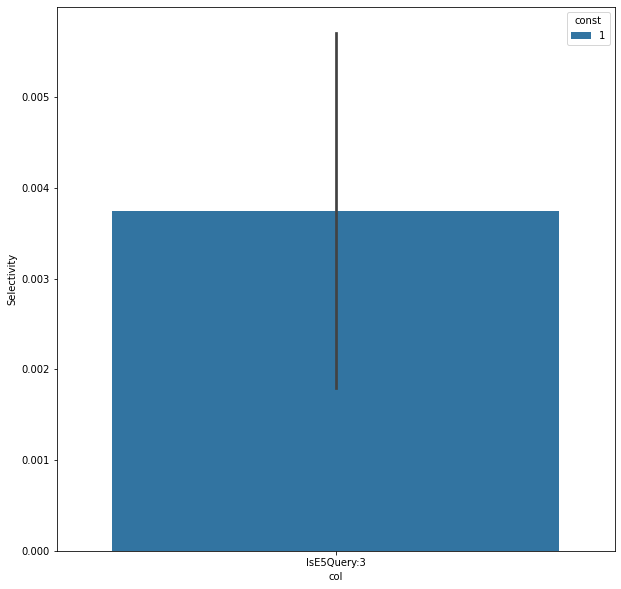

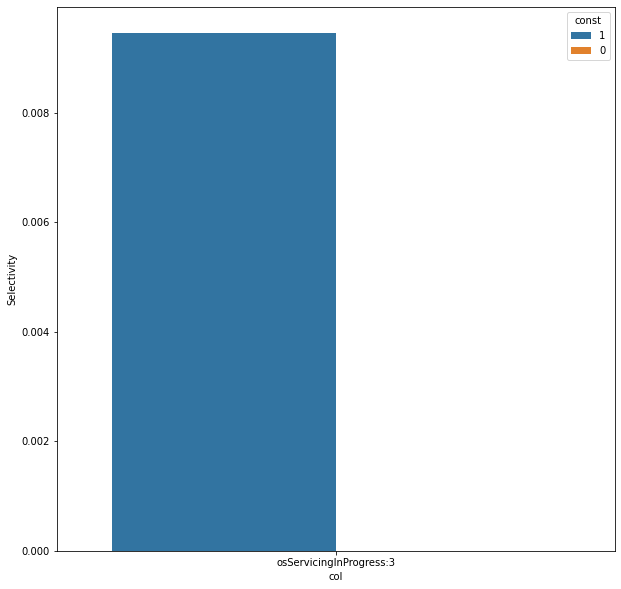

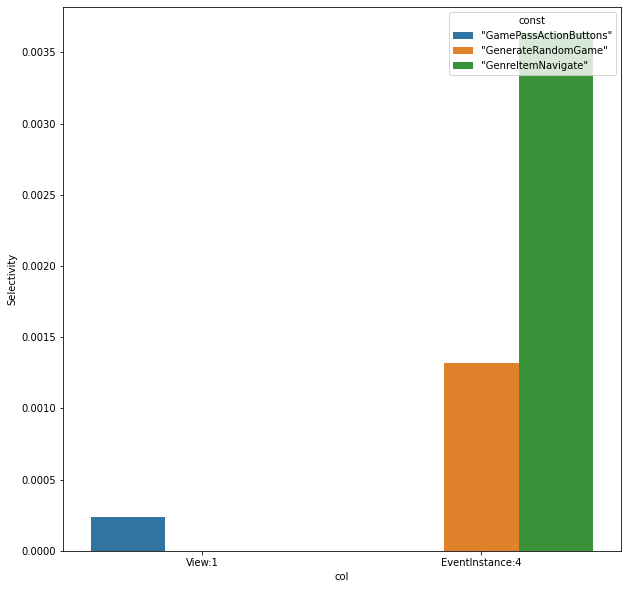

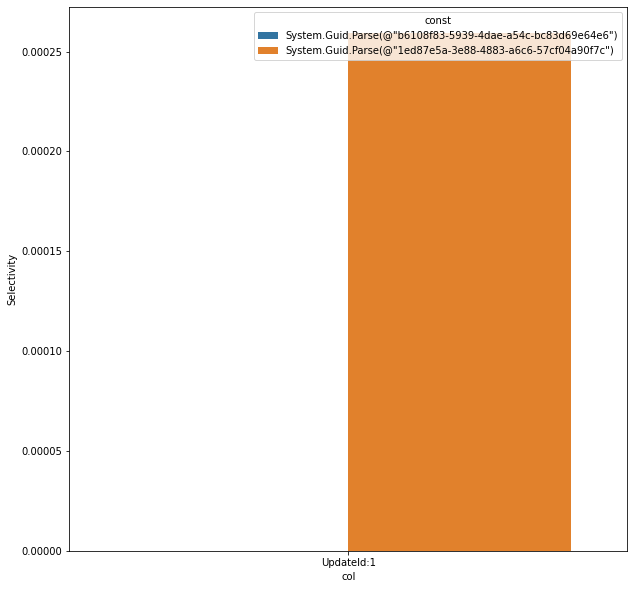

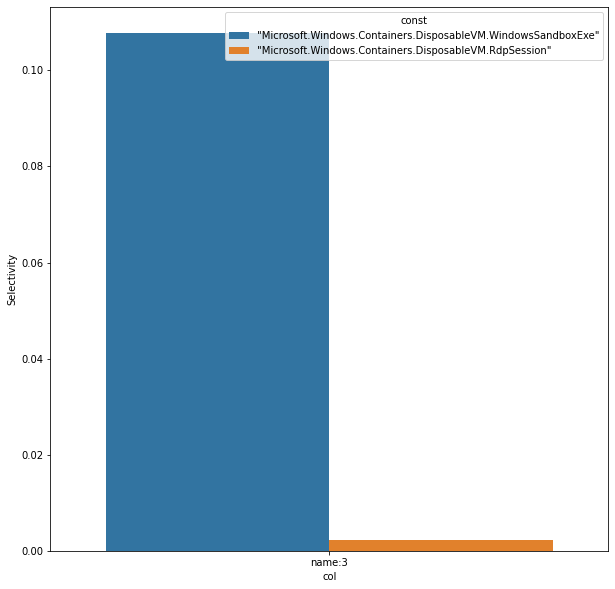

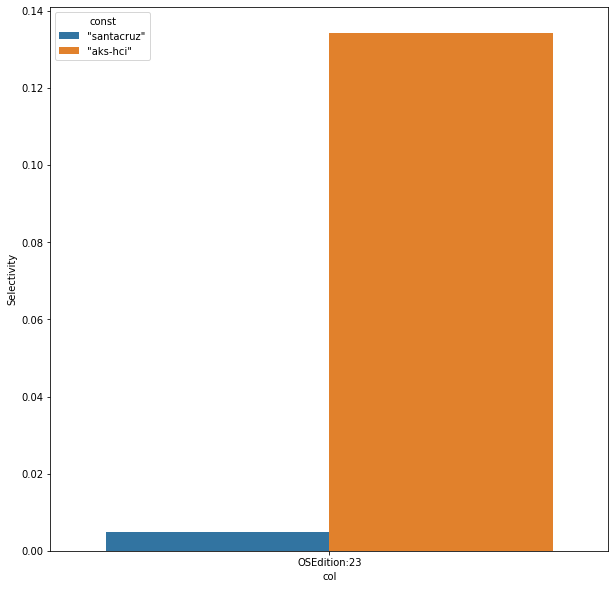

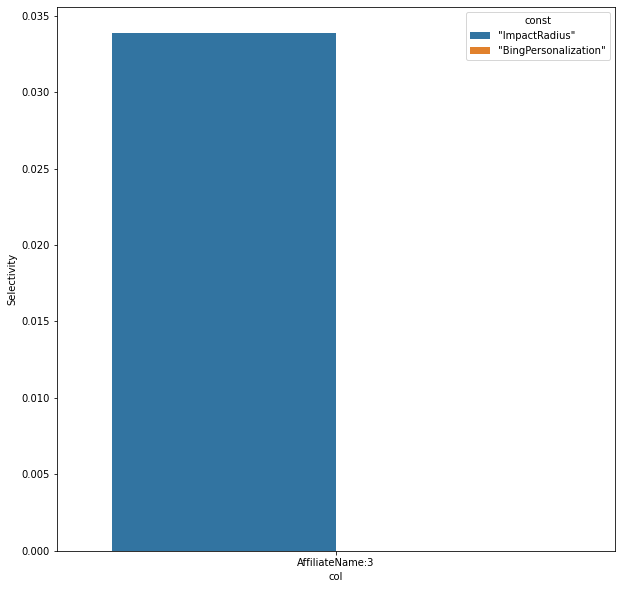

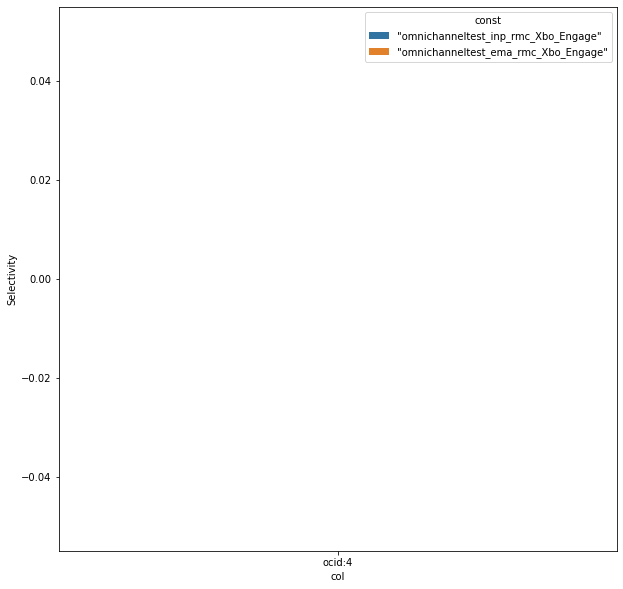

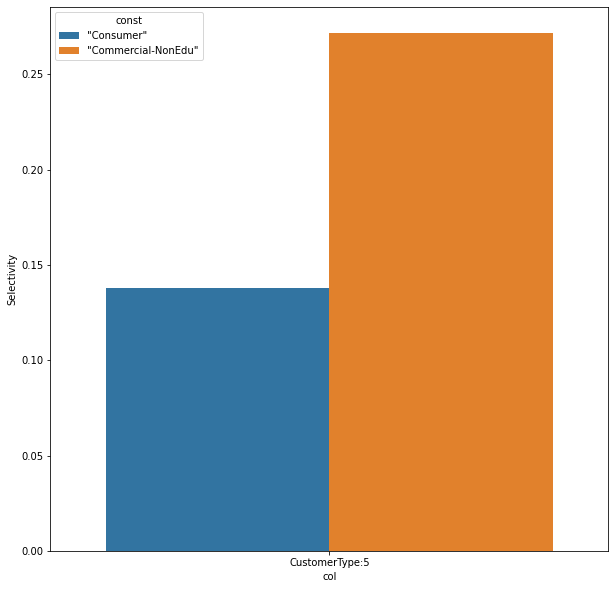

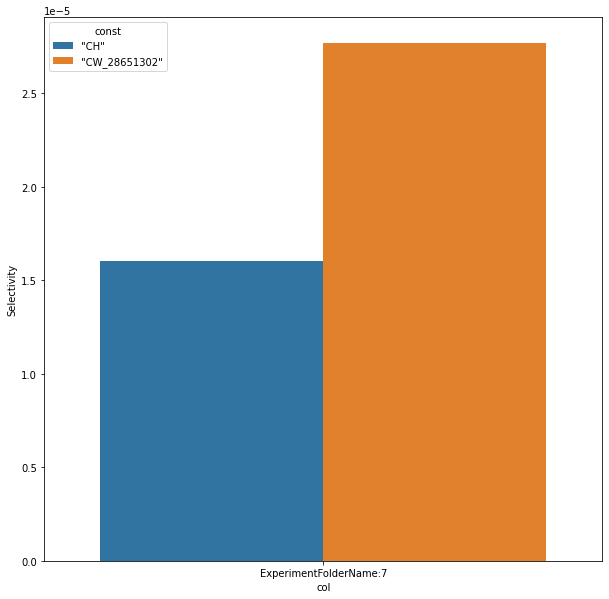

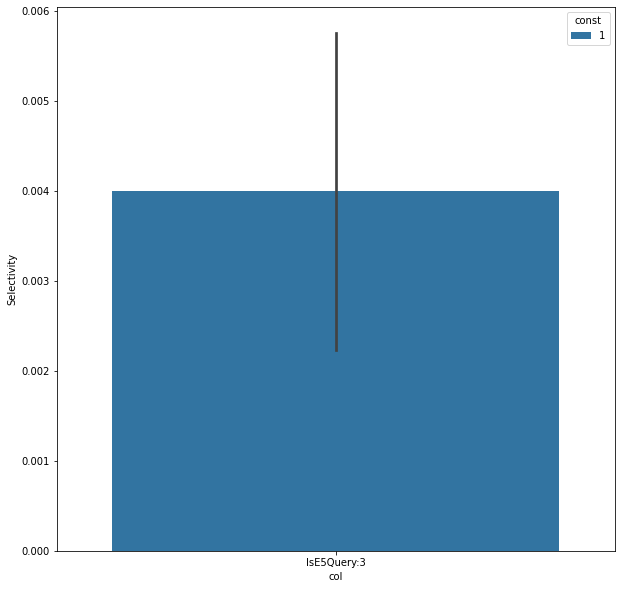

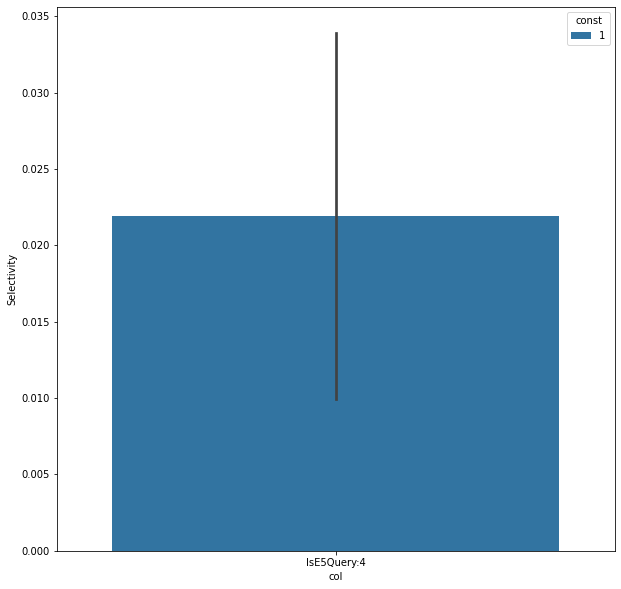

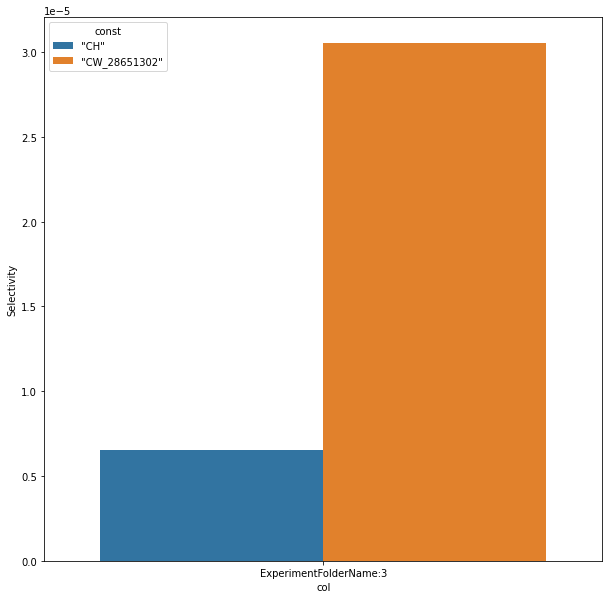

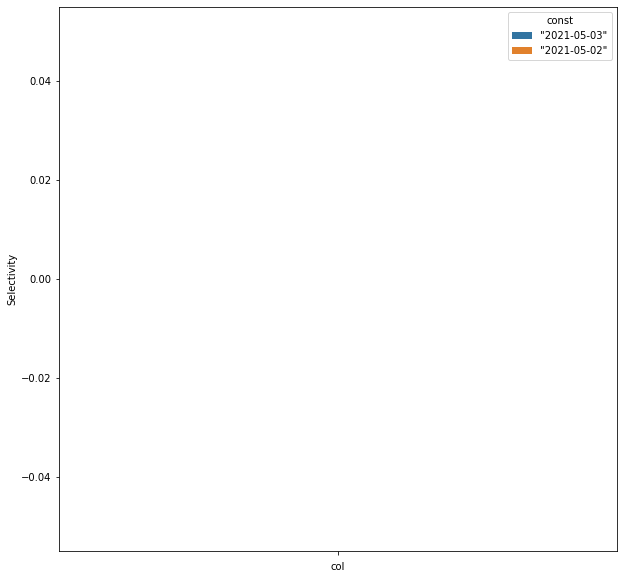

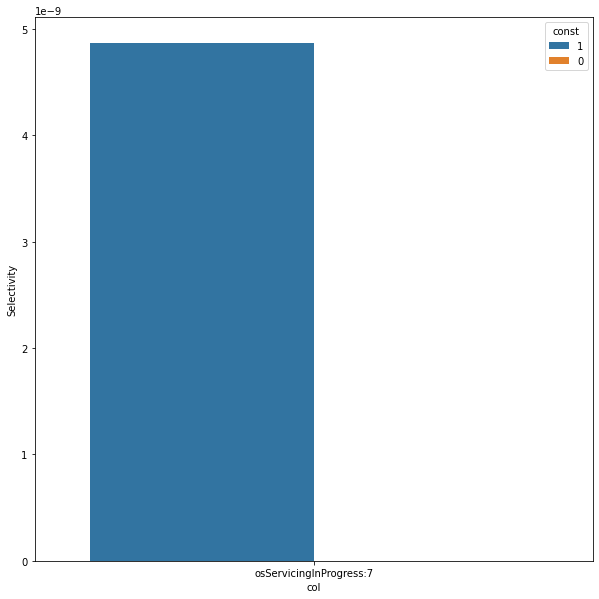

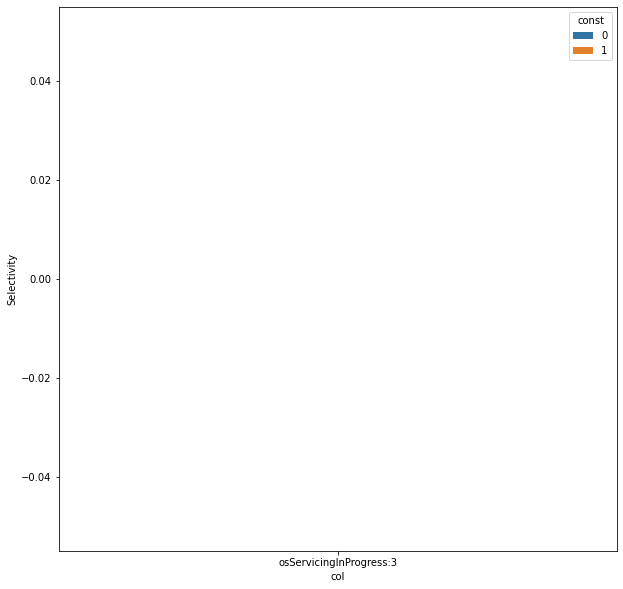

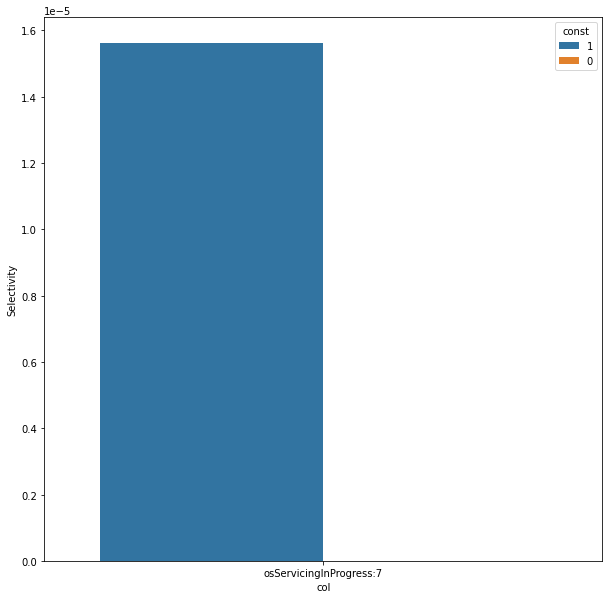

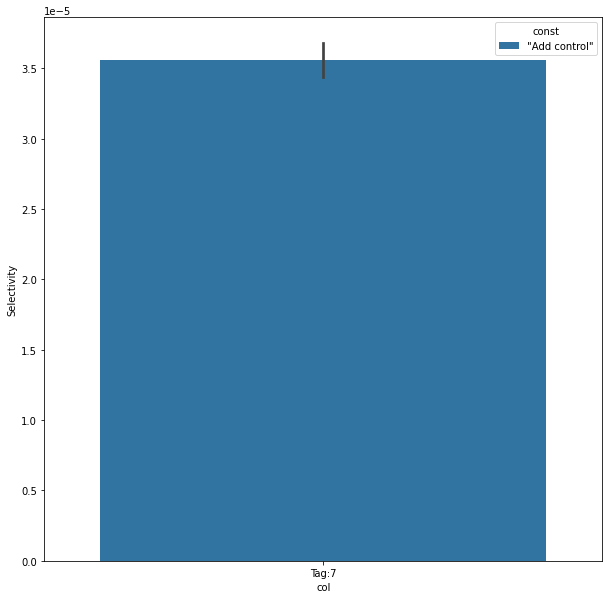

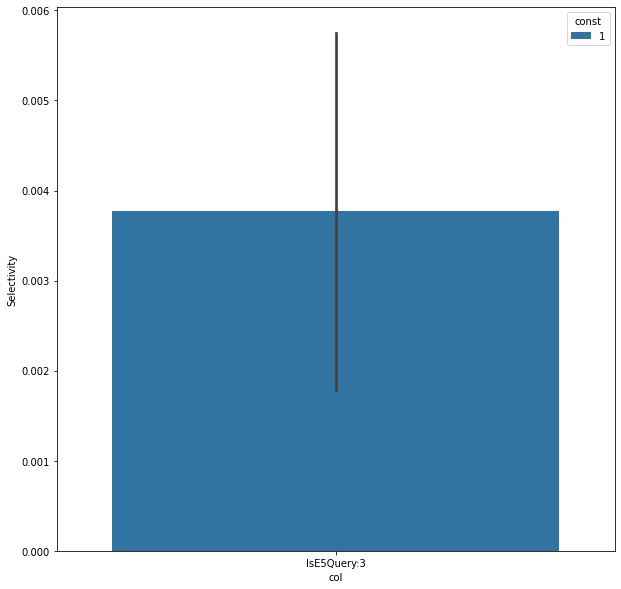

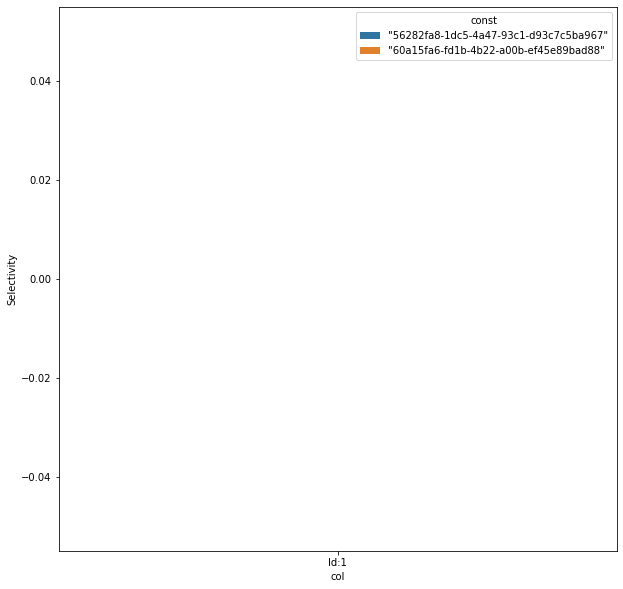

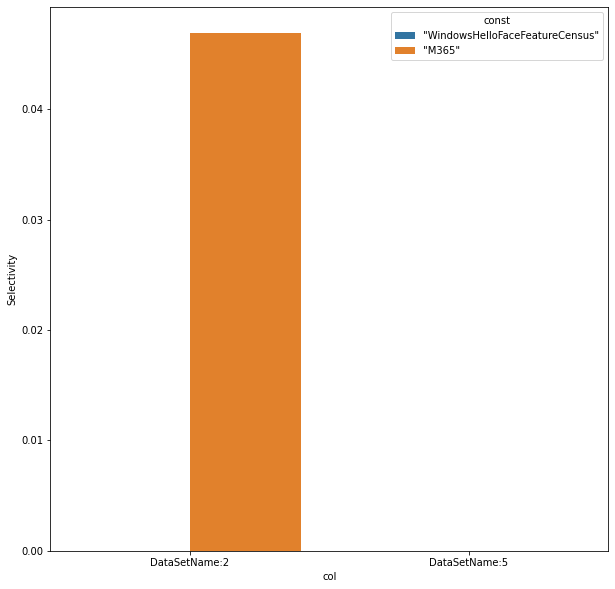

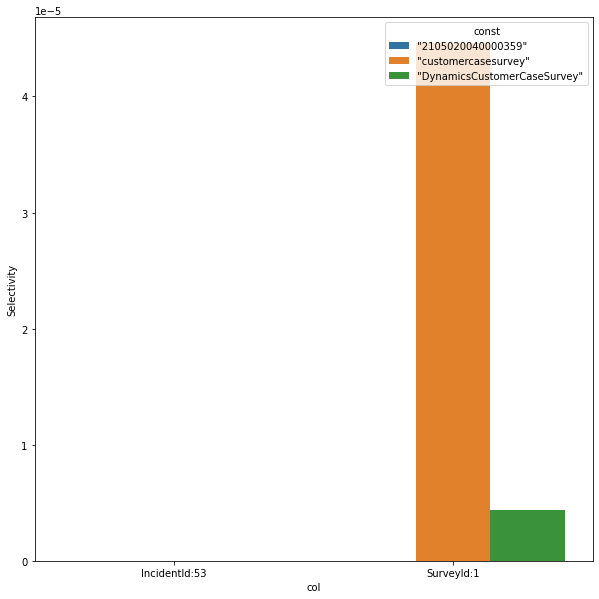

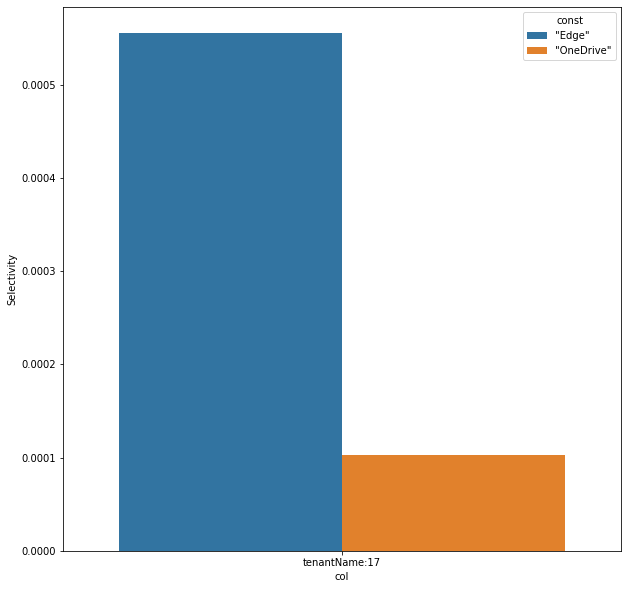

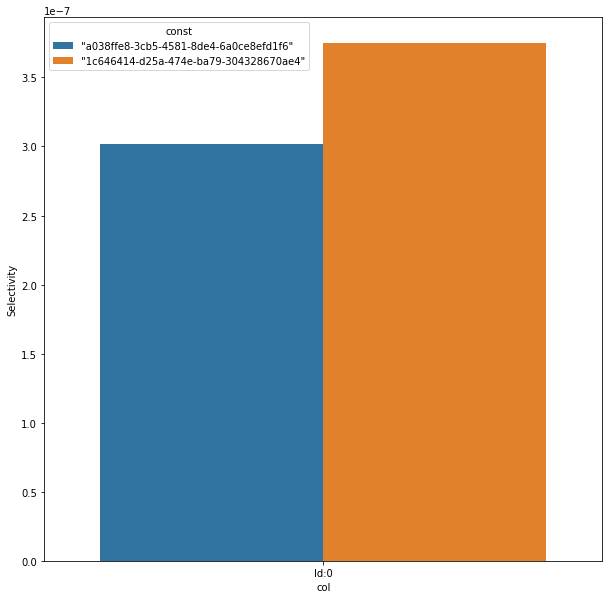

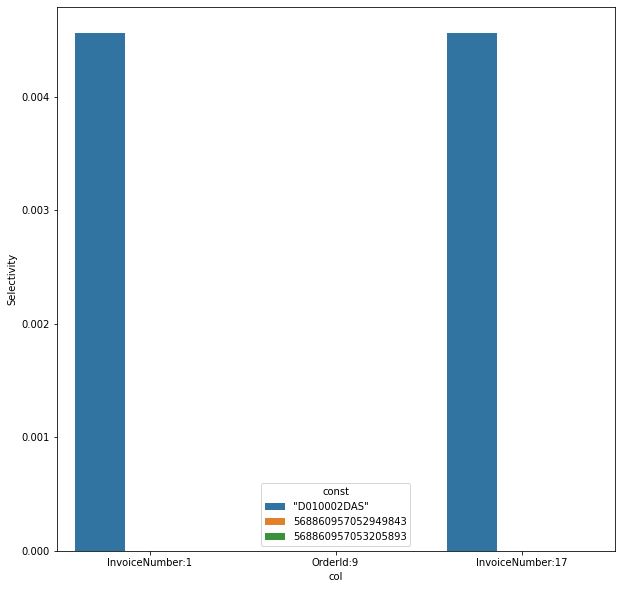

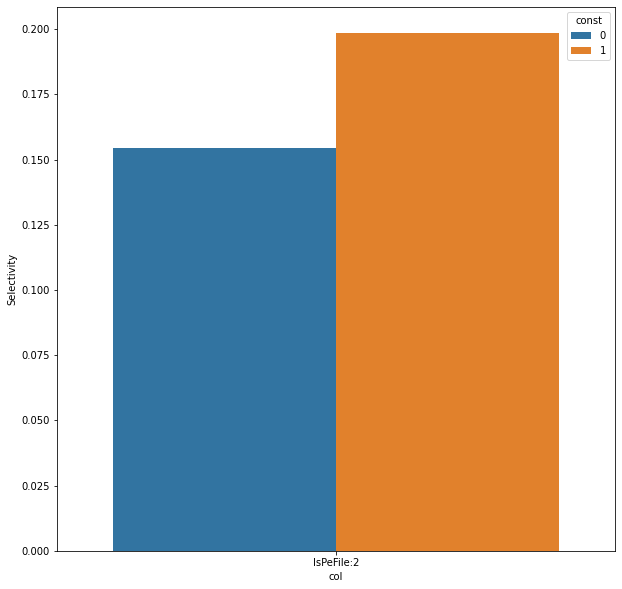

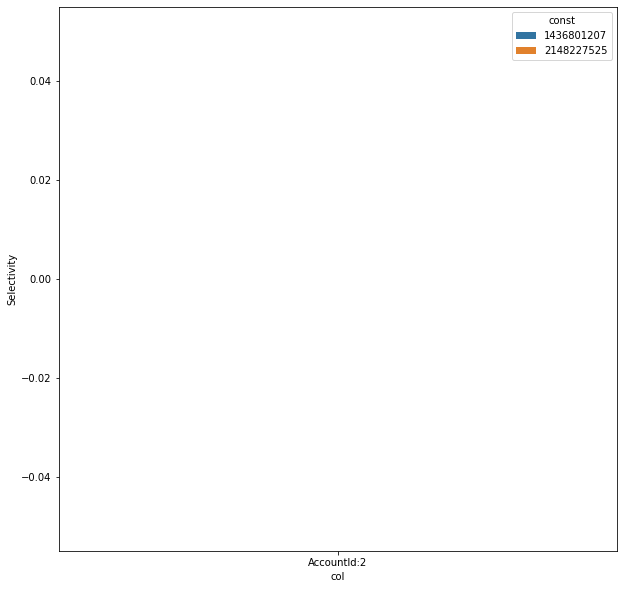

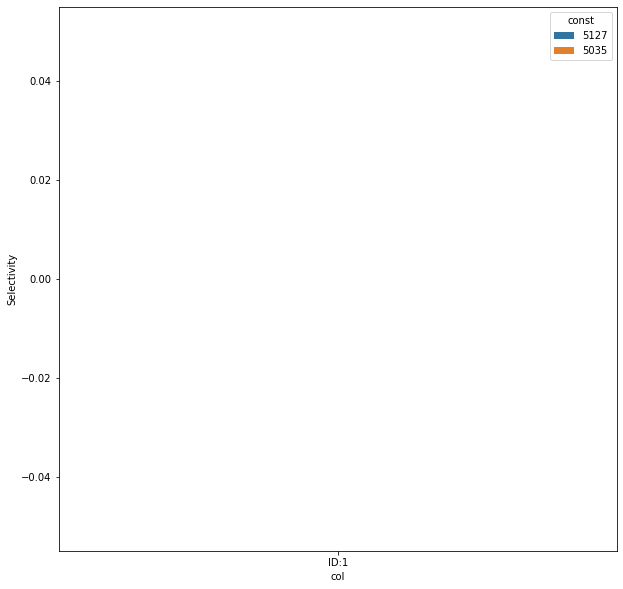

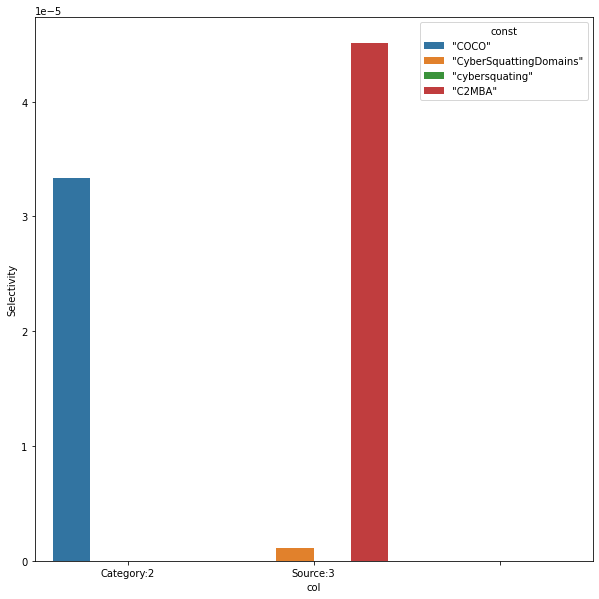

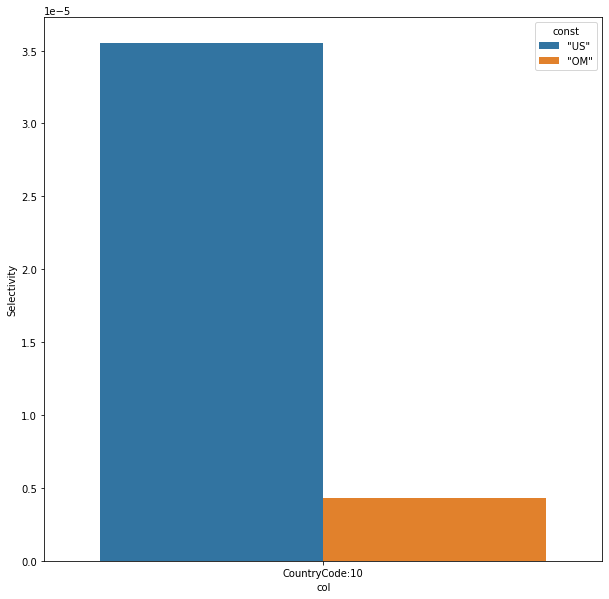

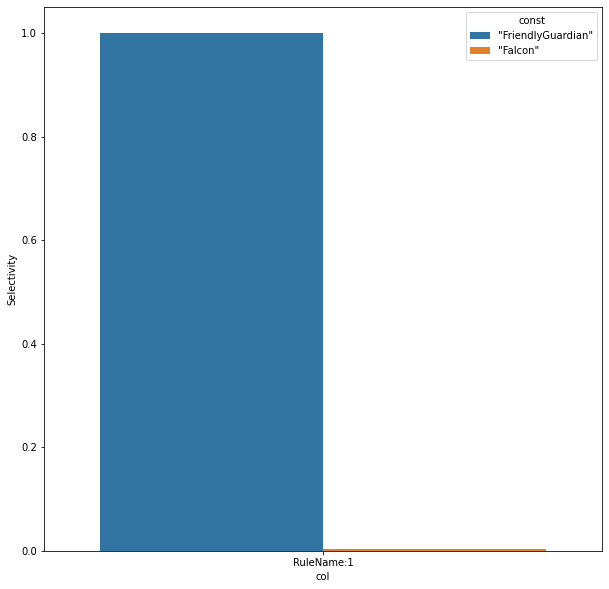

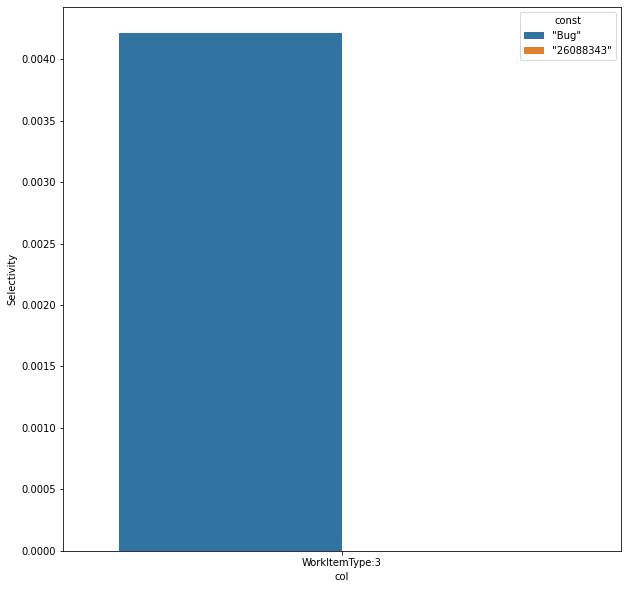

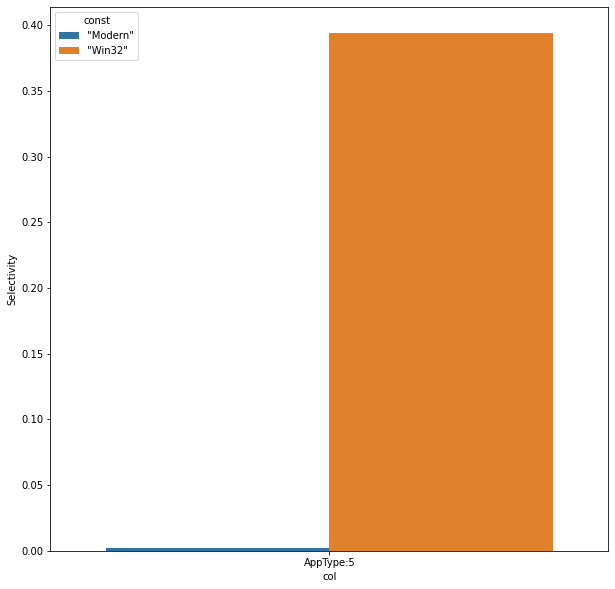

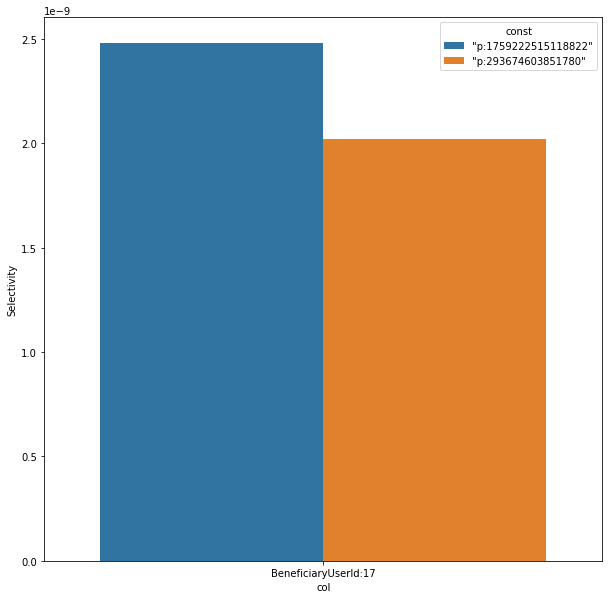

In [39]:
for inp in inpnames:
    tmpdf = discdf[discdf.input == inp]
    fix, ax = plt.subplots(figsize=(10,10))
    sns.barplot(data=tmpdf, x="col", y = "Selectivity", hue="const", ax=ax)
    #plt.legend().remove()
    plt.show()

In [47]:
inpdiscdata2 = defaultdict(list)
COLS_TO_COPY = ["Selectivity", "ExclusiveTime", "RowCount"]

for idx, row in df.iterrows():
    if row["discrete_ops"] == 0:
        continue 
    if row["cont_ops"] == 0:
        continue    

    if row["like_ops"] != 0:
        continue  
    if row["in_ops"] != 0:
        continue     
    if row["complex_ops"] != 0:
        continue
    if row["null_checks"] != 0:
        continue
        
    types_all = row["types_all"]

#     if types_all.count(",") > 1:
#         continue
    
    if row["discrete_type"] == "null":
        continue

    expr = row["FilterExprNorm"]
    d = json.loads(expr)
    filter_values = extract_values(d, "values")

    col_names = extract_values(d, "name")
    ops = extract_values(d, "expOperator")
    
#     if row["in_ops"] == 1:
#         print(col_names)
#         print(filter_values)
#         print("********")
        
    for fi, fvs in enumerate(filter_values):
        if len(fvs) == 0:
            continue
        assert len(fvs) == 1
        
        if "<" in ops[fi] or ">" in ops[fi]:
            continue
        if col_names[fi] == "":
            continue
            
        if "System" in fvs[0]:
            continue
        
        disctype = get_discrete_type(fvs)
        inpdiscdata2["input"].append(row[INP_FIELD])
        inpdiscdata2["col"].append(col_names[fi])
        inpdiscdata2["const"].append(fvs[0])
        inpdiscdata2["disctype"].append(disctype)
        
        for ck in COLS_TO_COPY:
            inpdiscdata2[ck].append(row[ck])
        

In [48]:
print(len(inpdiscdata2["input"]))
discdf = pd.DataFrame(inpdiscdata2)
print(discdf["input"].describe())
print(discdf["const"].describe())
print(discdf["disctype"].describe())

1224
count                                                  1224
unique                                                  109
top       adl://asimov-prod-data-cX.azuredatalakestore.n...
freq                                                    326
Name: input, dtype: object
count     1224
unique     121
top       true
freq       137
Name: const, dtype: object
count     1224
unique       4
top        num
freq       582
Name: disctype, dtype: object


In [49]:
print(discdf["Selectivity"].describe())

count    1224.000000
mean        0.059759
std         0.181035
min         0.000000
25%         0.000018
50%         0.000763
75%         0.016919
max         1.000000
Name: Selectivity, dtype: float64


In [50]:
# tmp = discdf[discdf.disctype == "string"]
# print(tmp["const"].values)

In [51]:
#discdf = discdf[discdf.disctype == "string"]
discinps = discdf.groupby(["input","col", "disctype"])["const"].nunique().reset_index().sort_values(by="const", 
                                                                    ascending=False)
discinps = discinps[discinps["const"] >= 1]
discinps = discinps.drop_duplicates("input")
inpnames = discinps["input"].values
print(len(inpnames))
HTML(discinps.head(20).to_html())

109


In [52]:
#print(inpnames)

In [53]:
df2 = discdf[discdf.input.isin(inpnames)]
print(df2["const"].values)

['@"19043"' '@"19043"' '"43"' ... '@"19042"' '@"17763"' '@"17763"']


adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/DEP/WinTheDevBox/Terminal/TerminalFunnelStagesInputStreams/X/X/TerminalInteractivity_X_X_X.ss
num


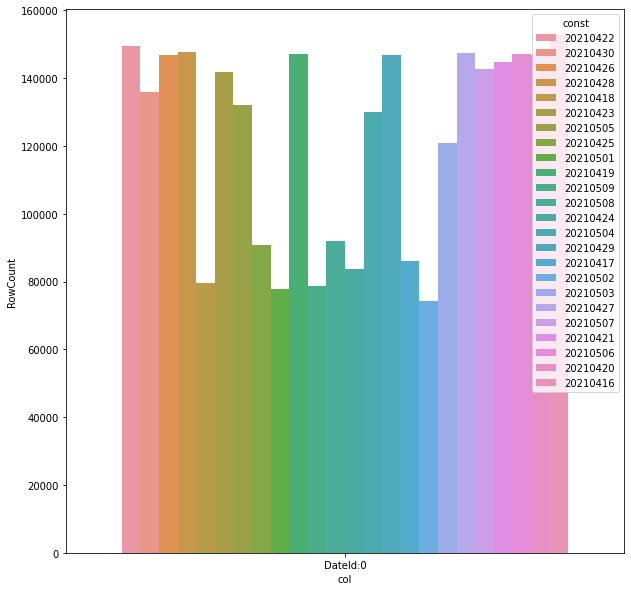

adl://iebks-proddata-cX.azuredatalakestore.net/local/xblpet/cooked/data/vulcandb/dbo.Feedback.ss
num


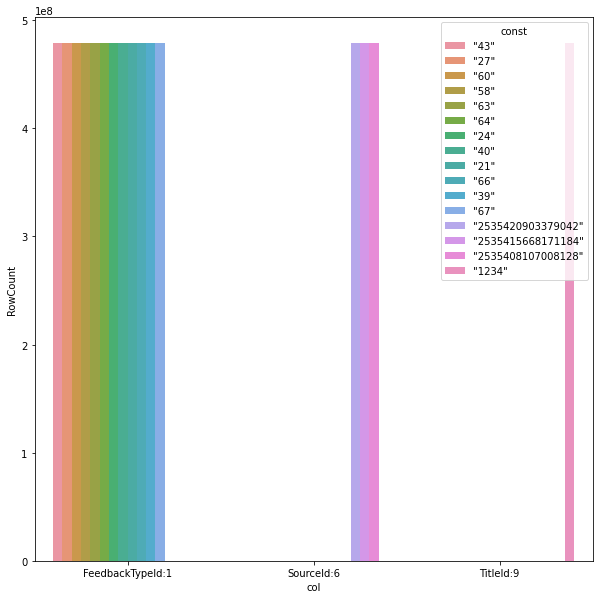

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WSD.Upgrade/LongTerm/CleanInstall/CleanInstall.ss
num


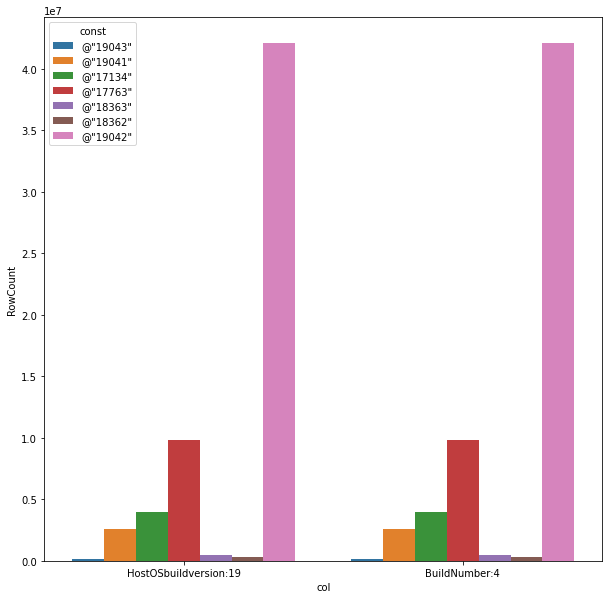

adl://aco-production-cX.azuredatalakestore.net/local/DarsyModule/RCM/RCM_Cumulative.ss
string


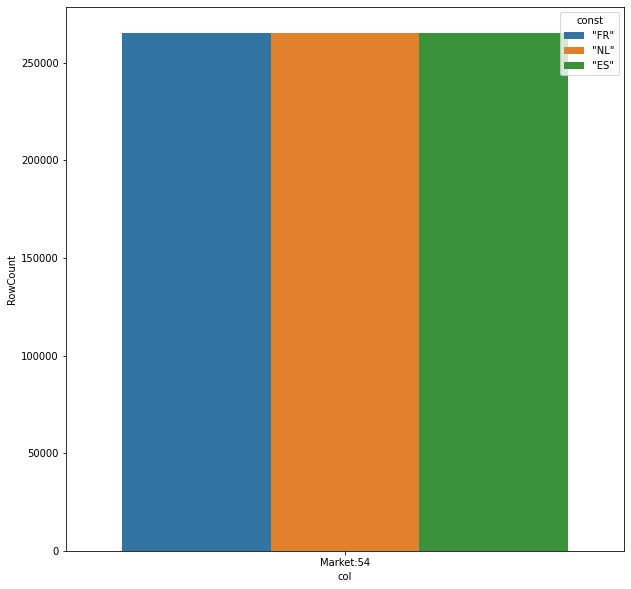

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_e/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


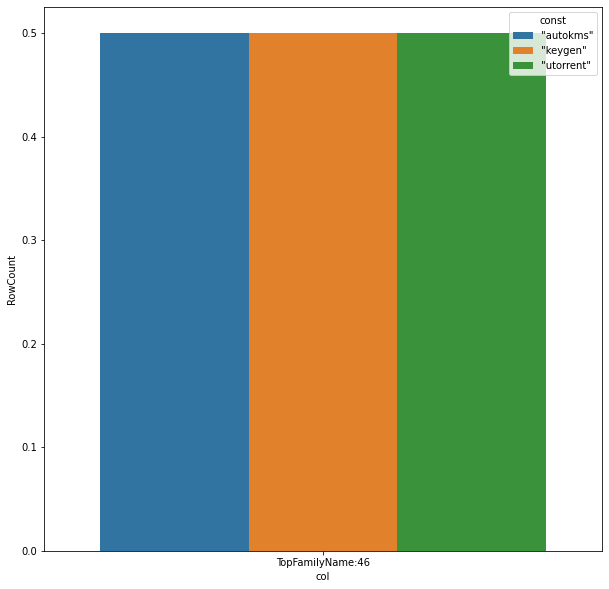

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_X/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


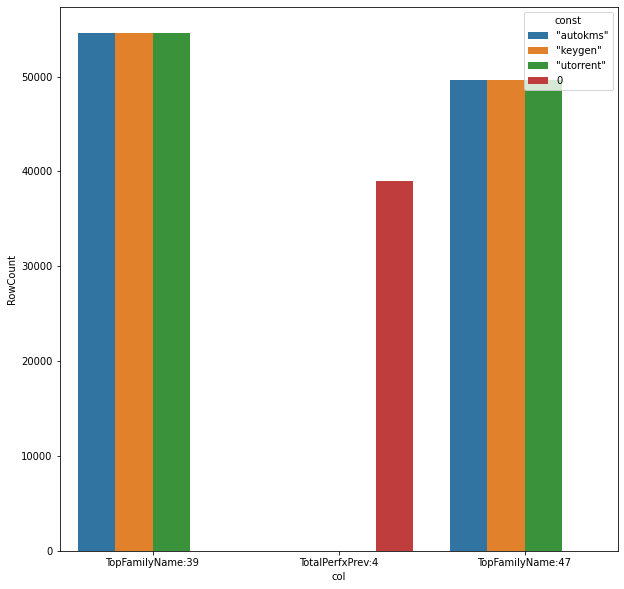

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_d/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


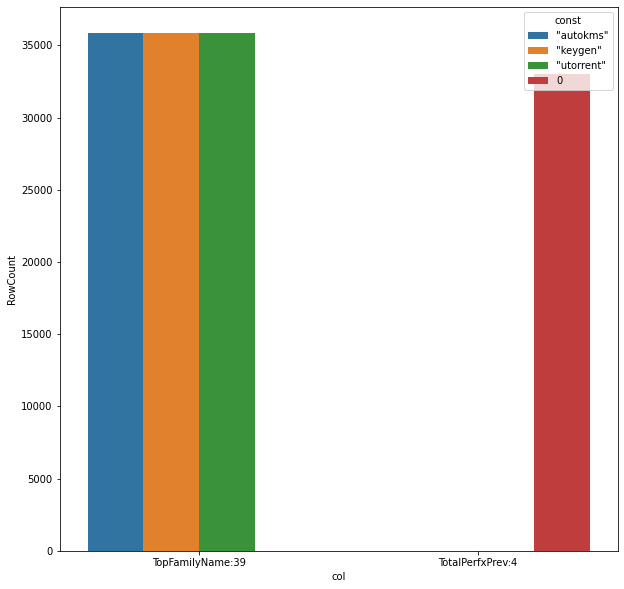

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_d/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


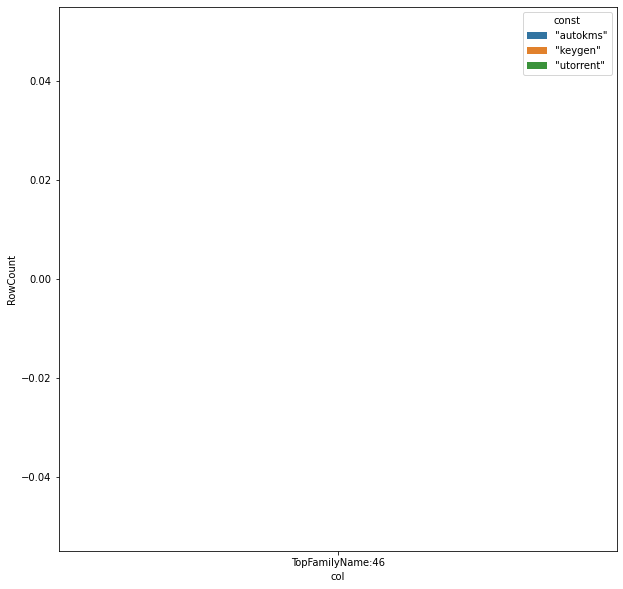

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_c/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


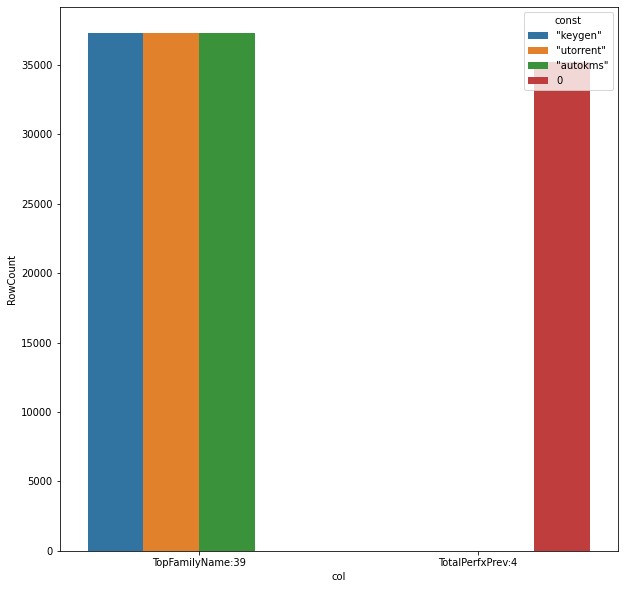

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_c/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


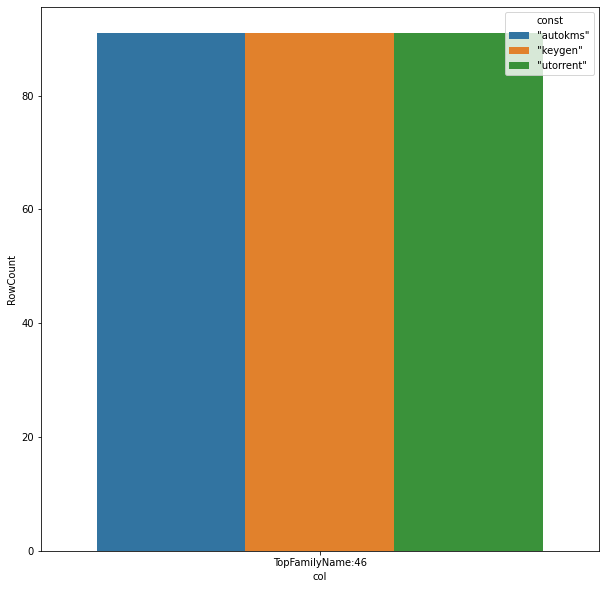

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_f/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


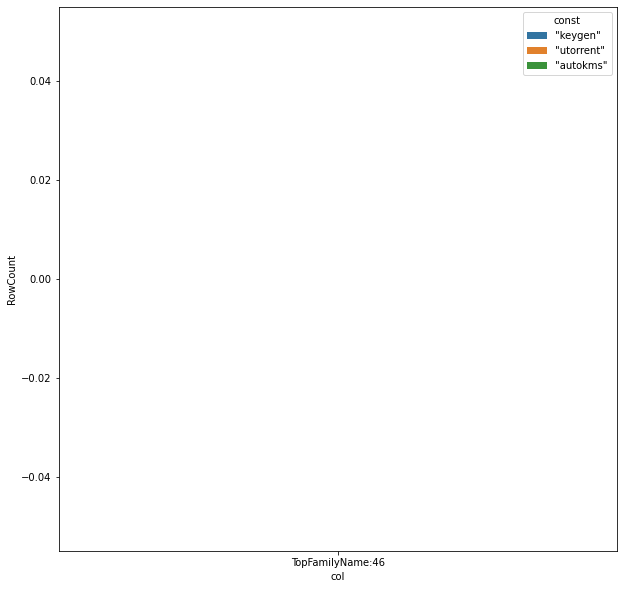

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_b/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


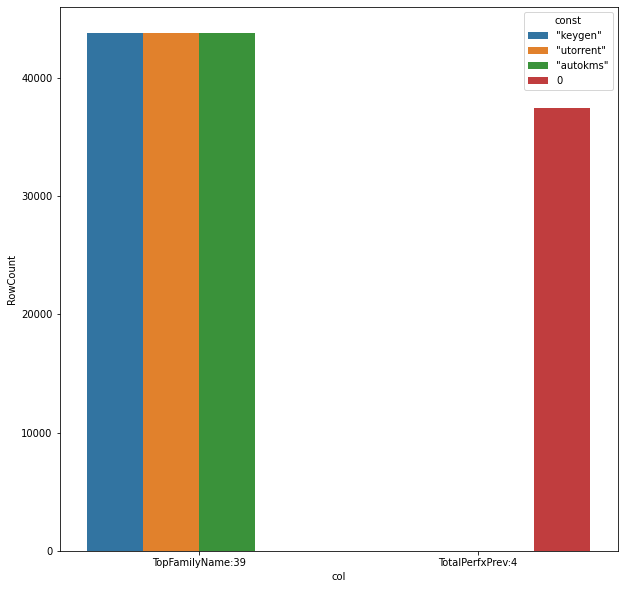

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_b/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


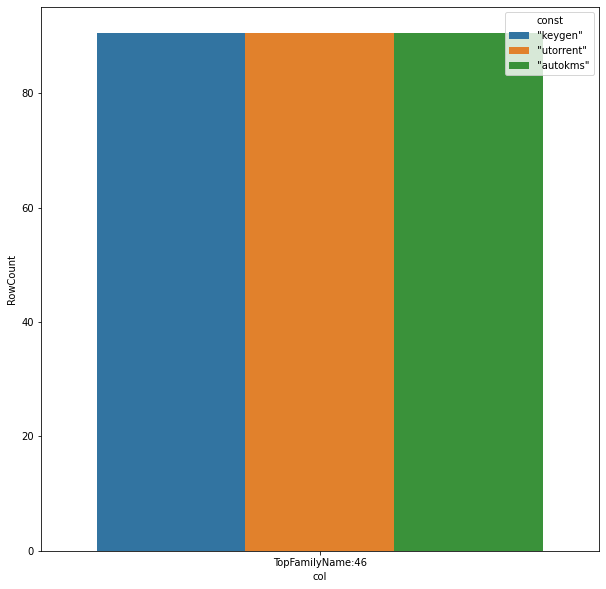

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_a/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


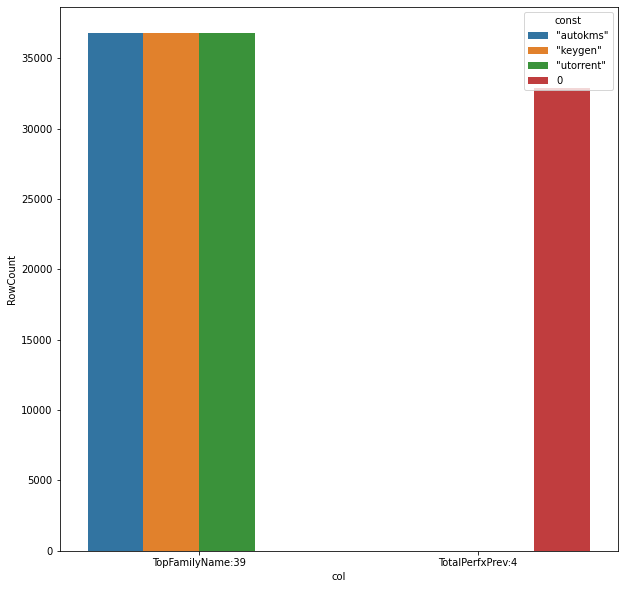

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_a/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


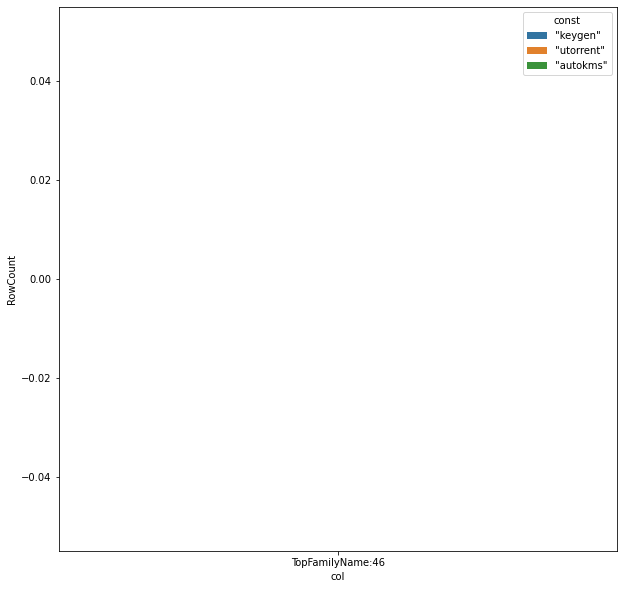

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_X/aldenp/[guid]@@@NeoHashVX-LeftOuterJoin[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherneoHashCountsSr/AEtherneoHashCountsSr_[guid].ss
string


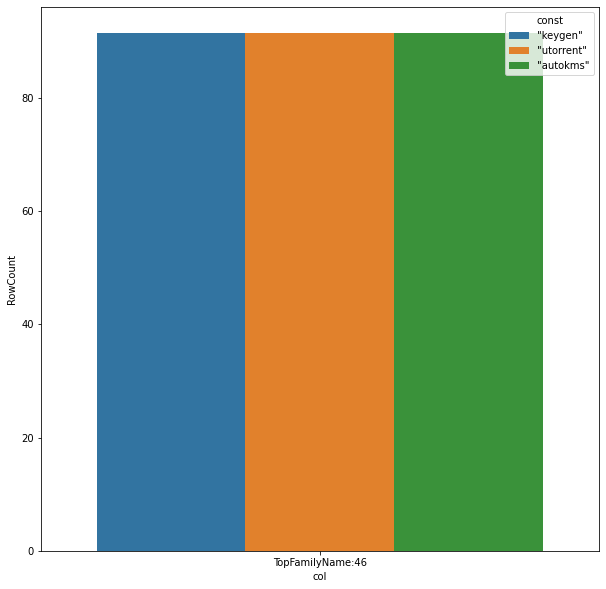

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_e/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


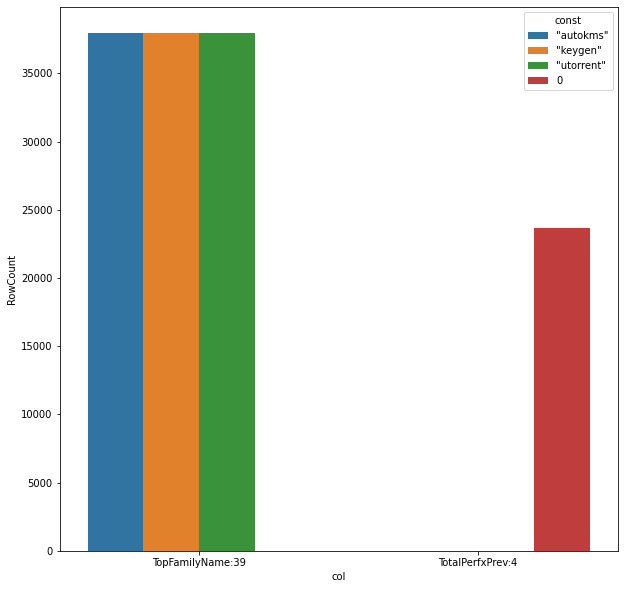

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_f/aldenp/[guid]@@@NeoHashVX-RemoveClash[AEtherId]@@@X-X-X_X-X-X_[Time]/AEtherNeoHashStatsRemoveClash/AEtherNeoHashStatsRemoveClash_[guid].ss
string


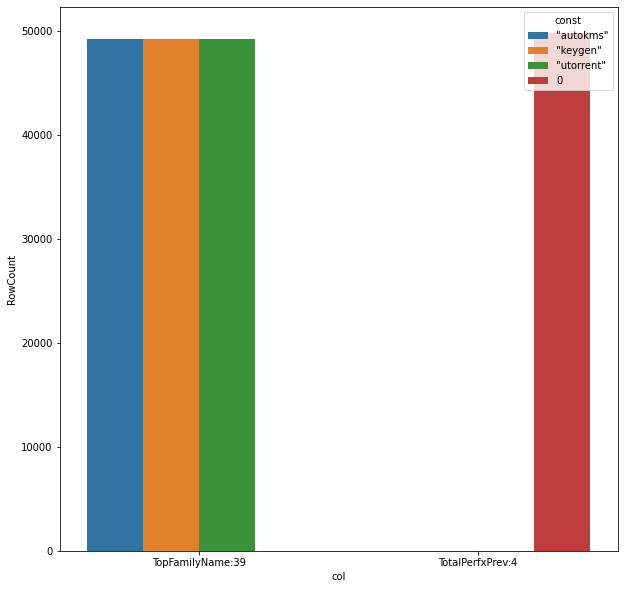

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Subscriptions/Metrics/SubscriptionInstanceMetrics/Monthly/X/X/SubscriptionInstanceMetrics_X_X_X.ss
string


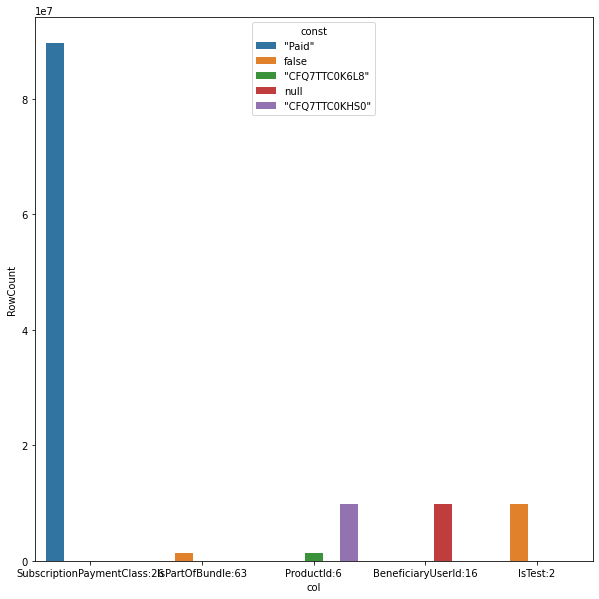

adl://cp-prod-cX.azuredatalakestore.net/local/CashFlow/Ingestion/Output/DunningJournalX/X/X/CaptureScheduleSummary_X_X_X.ss
null


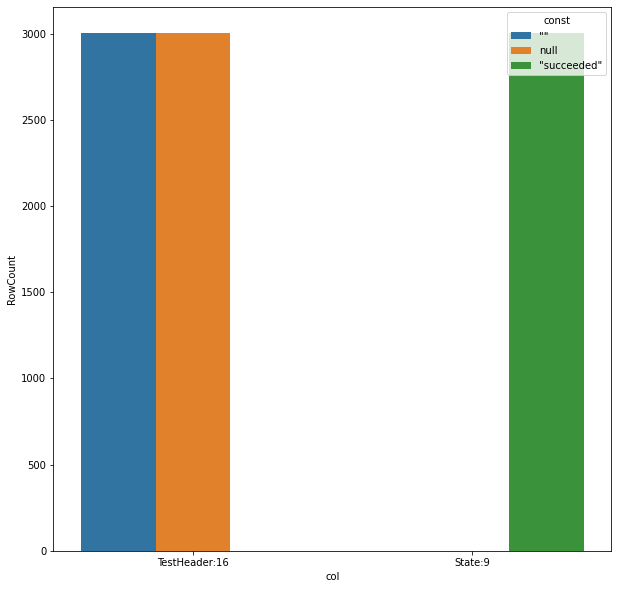

adl://mdollar-prod-cX.azuredatalakestore.net/local/M$/Recurrence/Prod/data/Prod/cooked/X_X_X_X_X_X/Recurrences.ss
string


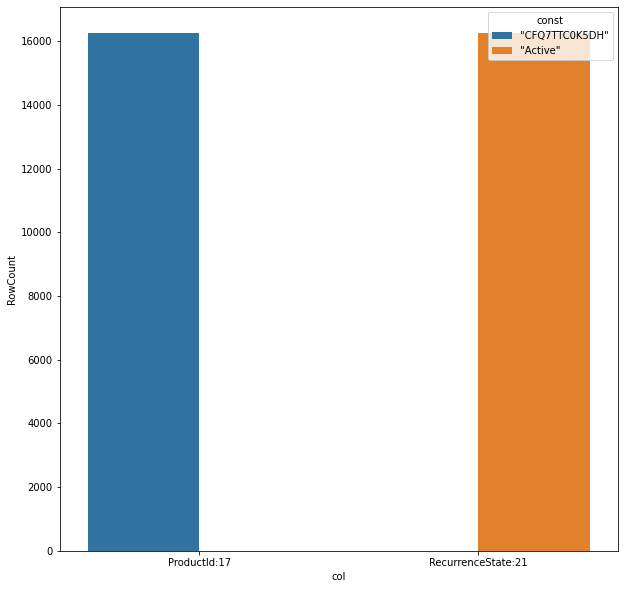

adl://cst-devtest-cX.azuredatalakestore.net/local/CommerceData/ctp/controls/token_control/vX/control_input/Tld_Finalized_NoBlackList.ss
num


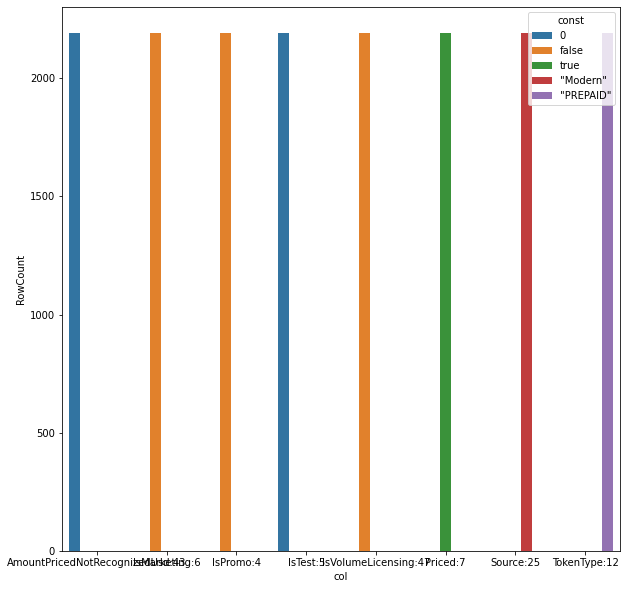

adl://cp-prod-cX.azuredatalakestore.net/local/Output/CommerceData/Enterprise/Invoice/SAPInvoiceDetailVX.ss
num


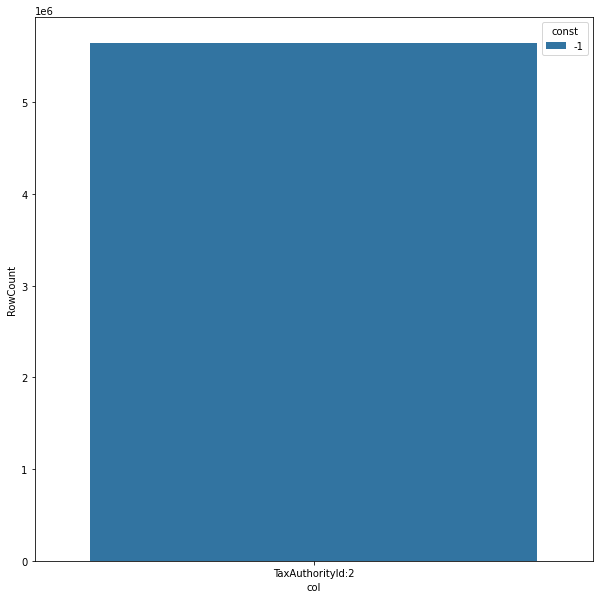

adl://cp-prod-activityreports-cX.azuredatalakestore.net/local/CashFlow/Reports/Tax/Legacy/RTLStagingStreams/X/X/BssOrderRevenue.ss
null


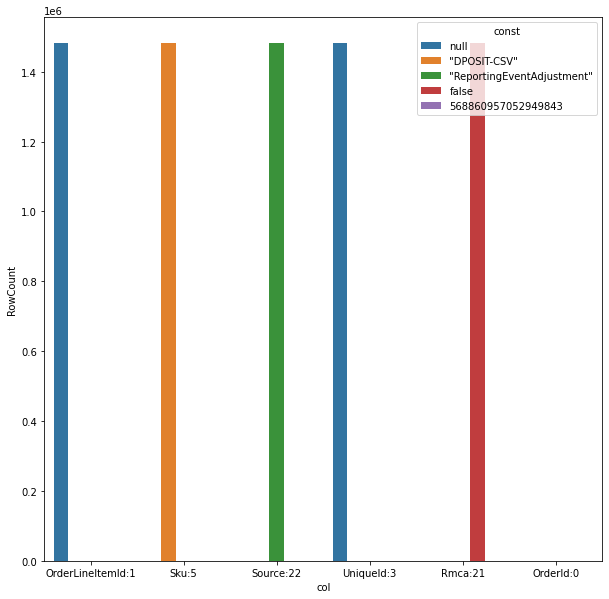

adl://iebks-partnerprod-cX.azuredatalakestore.net/local/data/processed/xps/gds/bir/Data/Dimensions/DimDate.ss
num


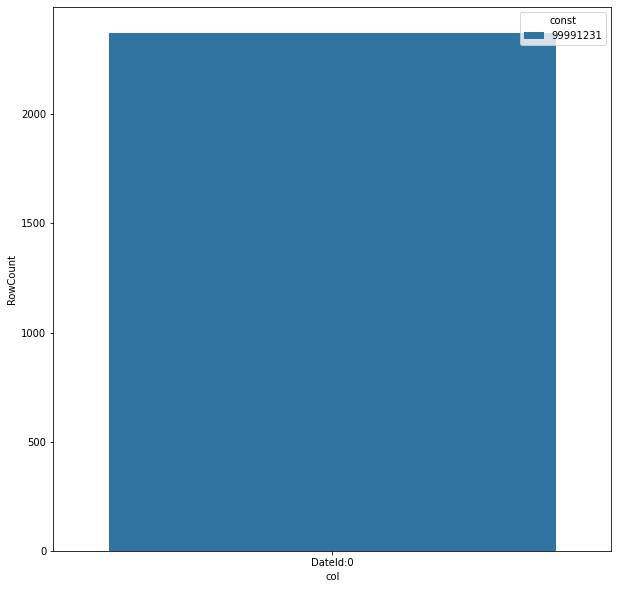

adl://mkg-prodrewards-data-cX.azuredatalakestore.net/local/MicrosoftRewards/Insights/Streams/PROD/Kpi/Flyout/New/X/X/X/BingMetricsPostByDateCumul_X.ss
string


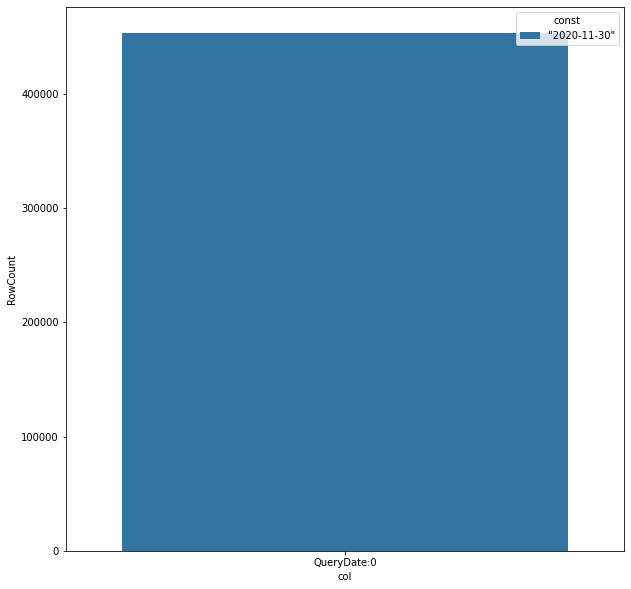

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_X/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


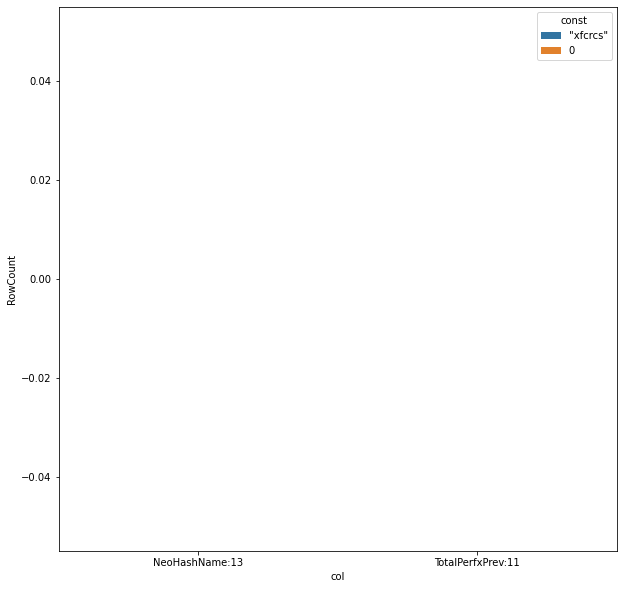

adl://ideas-prod-data-cX.azuredatalakestore.net/local/Publish/Profiles/Device/Neutral/IDEAsDeviceProfile/Streams/vX/X/X/DeviceHistory_X_X_X.ss
null


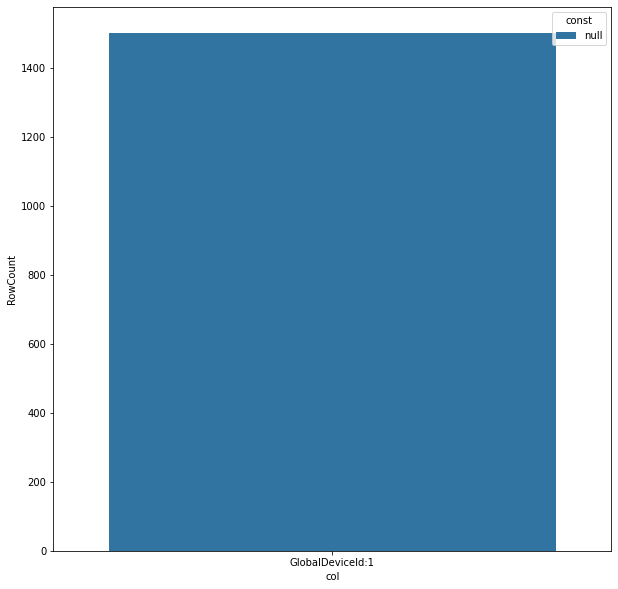

adl://iebks-partnerprod-cX.azuredatalakestore.net/local/data/processed/Experiments/XBL/Griffin/Achievements-Leaderboards.ss
string


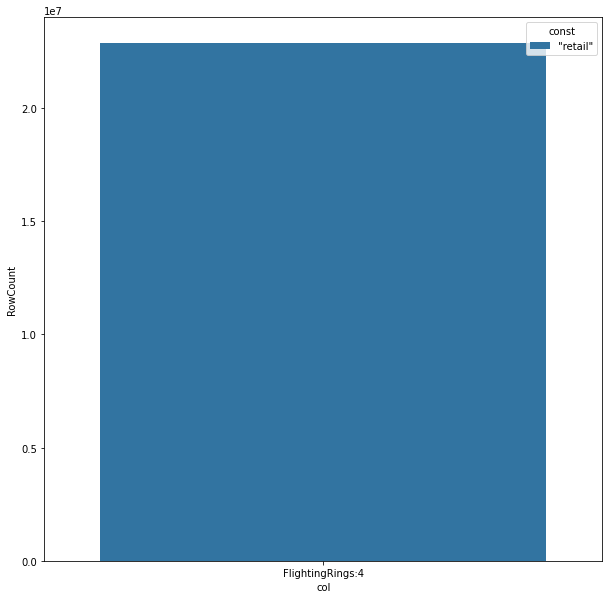

adl://iebks-business-cX.azuredatalakestore.net/local/rbi/nonpii/data/RMGaming/Reporting/Prod/Intermediates/FEM/CampaignSummaryBEM_ltd.ss
num


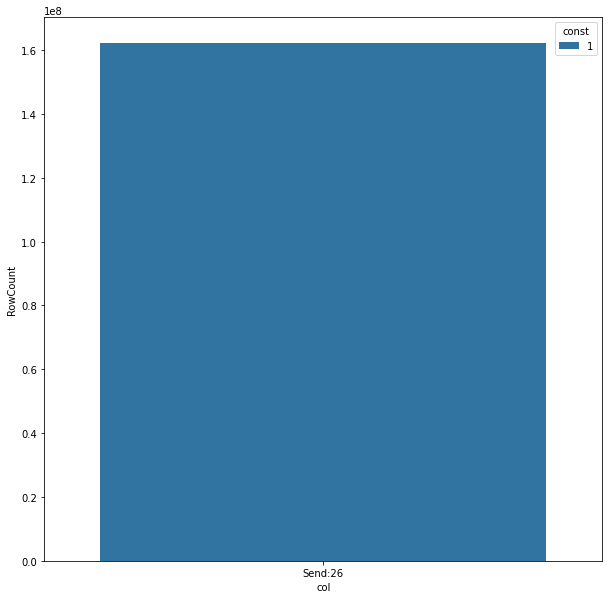

adl://iebks-business-cX.azuredatalakestore.net/local/rbi/nonpii/data/RMGaming/Reporting/Prod/Intermediates/FEM/X/X/X/Iris/CampaignSummaryBEM.ss
num


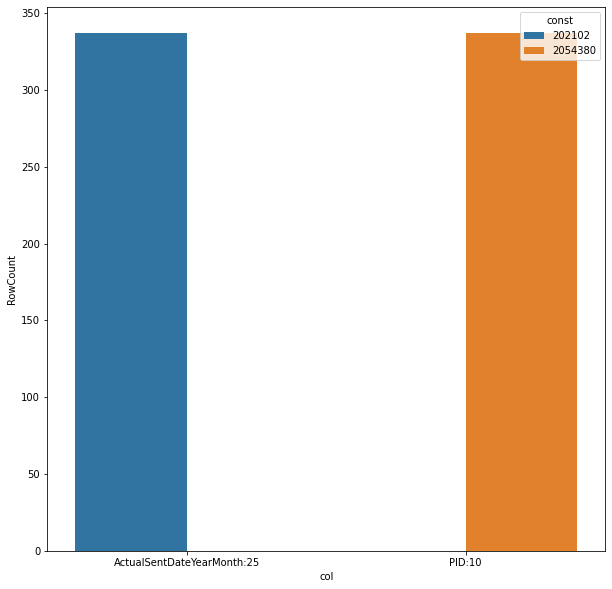

adl://gdc-mdp-prod-cX.azuredatalakestore.net/local/CnEDataInsights/Nurture/BizApps/PowerBIFeatureUsage/Consolidated/ConsolidatedPowerBIFeatureUsageEvents.ss
string


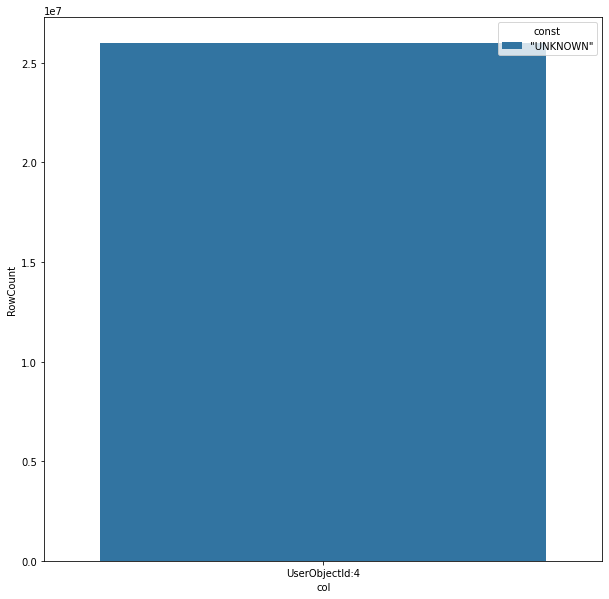

adl://iebks-business-cX.azuredatalakestore.net/local/users/v-anupri/Intermediates/Revenue/X/X/X/AllChannelsUnique_Users_PurchaseAgg_UserLevel.ss
num


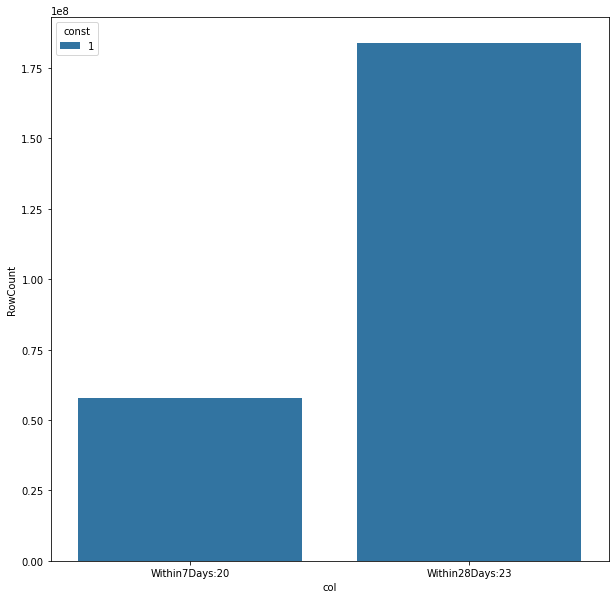

adl://iebks-partnerprod-cX.azuredatalakestore.net/local/data/processed/xbox/cooker/consoles/videomode/X/X/cook_videomode_snapshot_X_X_X.ss
bool


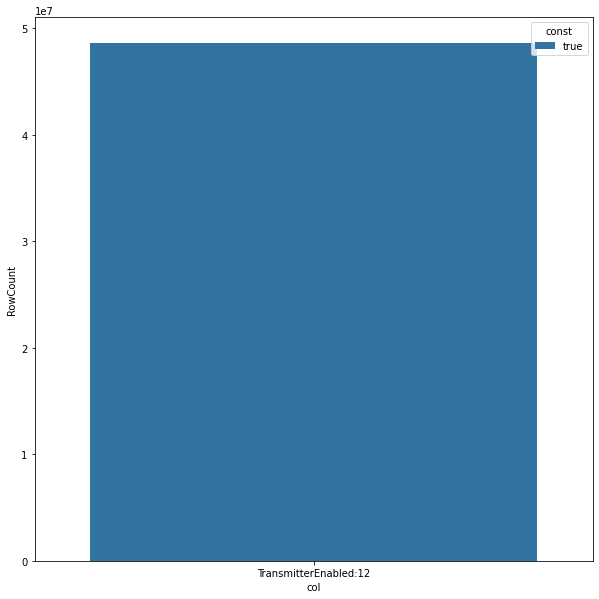

adl://iebks-partnerprod-cX.azuredatalakestore.net/local/data/processed/xbox/fact/consoles/videomode/vX/X/X/ft_videomode_hardwareid_snapshot_X_X_X.ss
bool


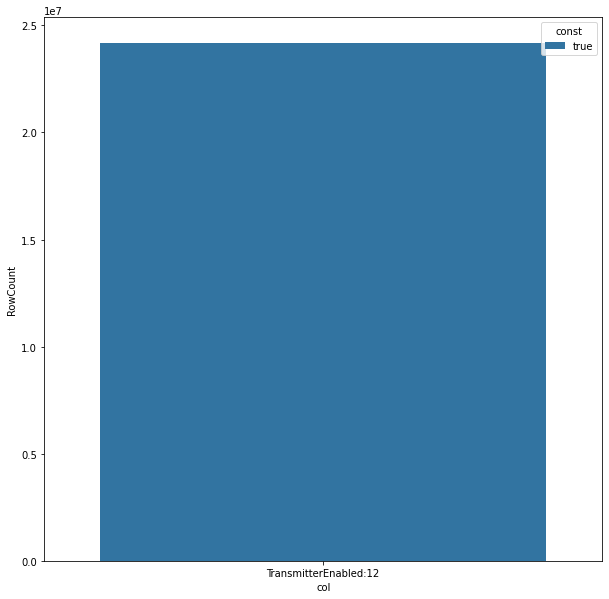

adl://iebks-partnerprod-cX.azuredatalakestore.net/local/data/processed/xbox/partner/cdna/ConsoleMigration/ConsoleMigration.ss
null


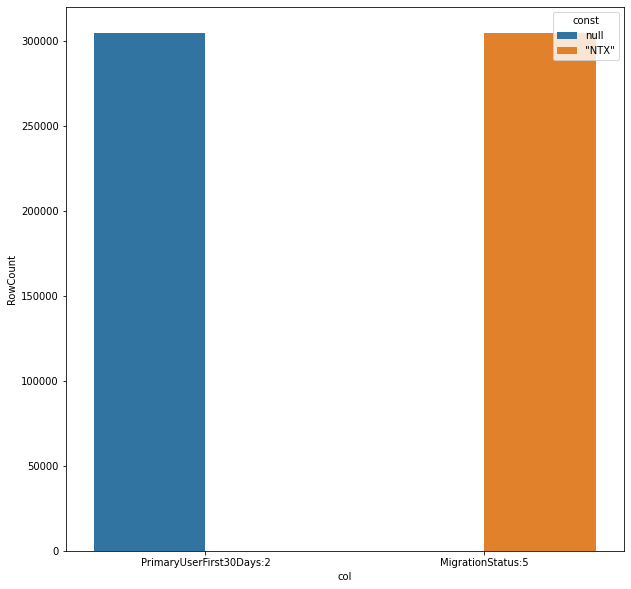

adl://protection-adhoc-cX.azuredatalakestore.net/local/psusers/Debajit/WSR/BiT/BiT_WorksetData.ss
string


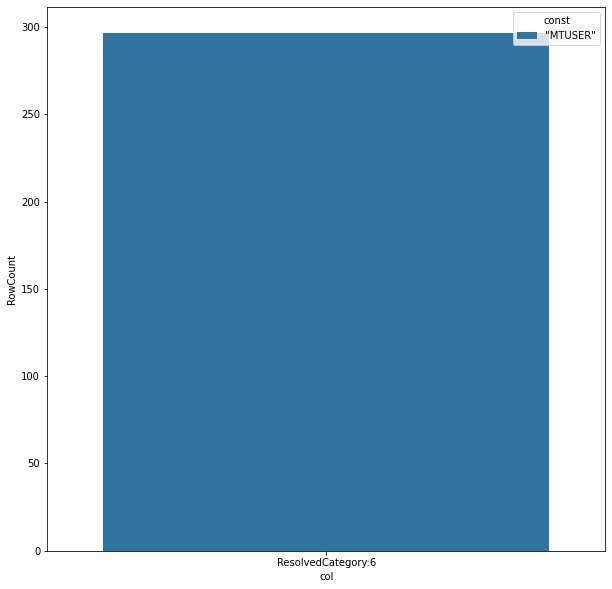

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_f/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


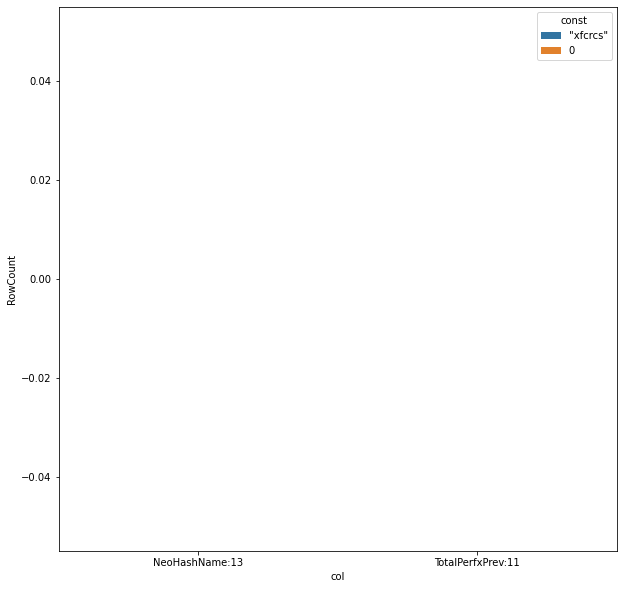

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_f/mmarino/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
string


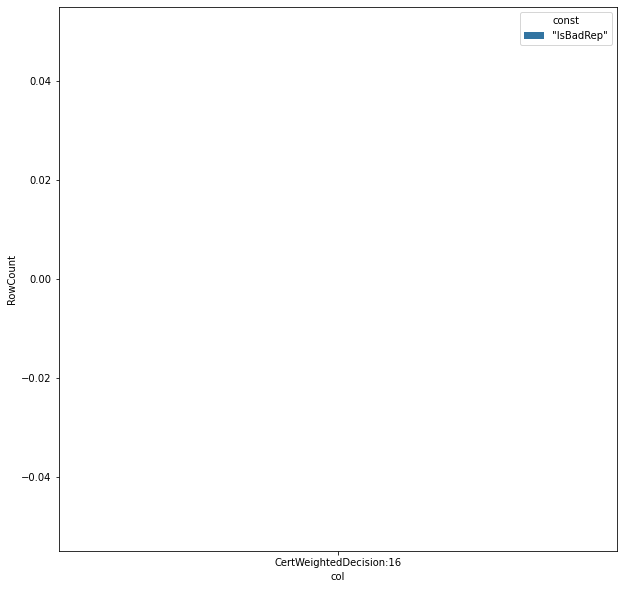

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_f/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


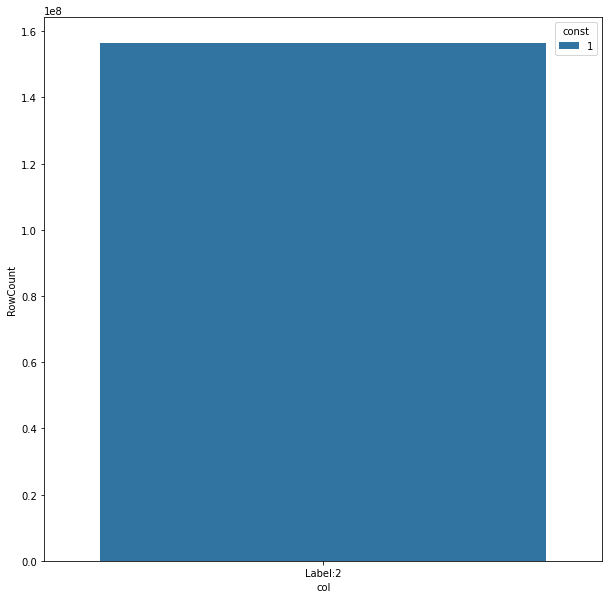

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/SampleSubmission/FileVolByOriginFileType/FileVolByOriginFileType_Detail.ss
string


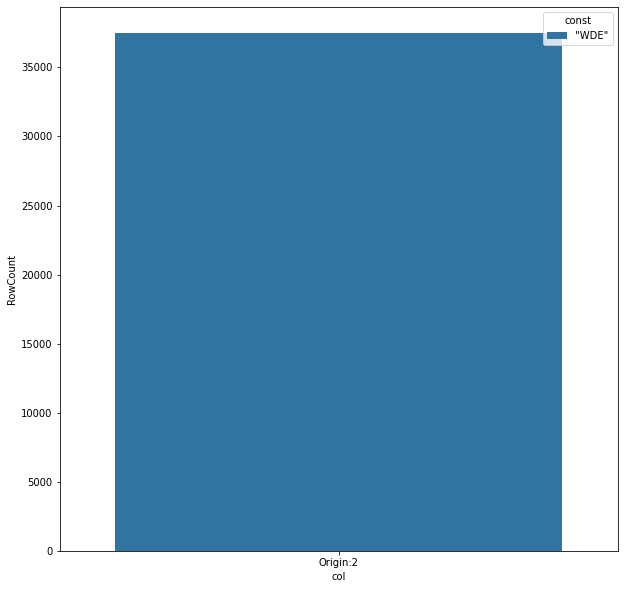

adl://protection-adhoc-cX.azuredatalakestore.net/local/LongTermStorage/skhadka/Rule_Evaluation/Experimental/OrgSpecificClean/Data/CloudRuleDecisions_Parsed.ss
bool


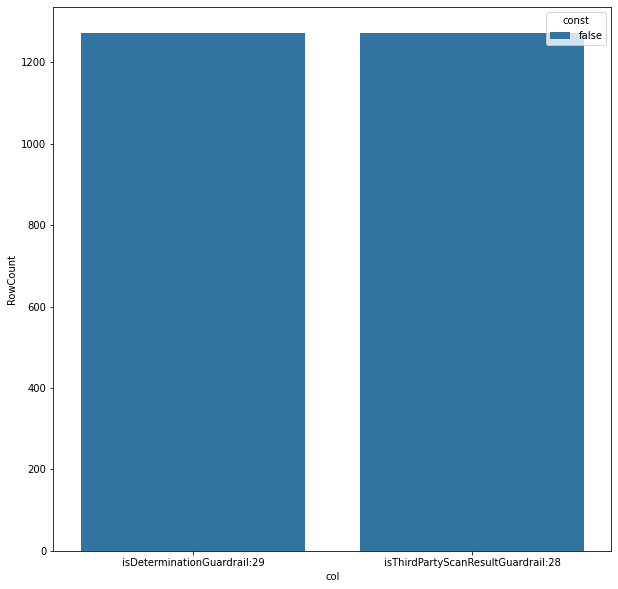

adl://protection-prod-cX.azuredatalakestore.net/local/processed/cooked/WorksetMetadata/X/X/X/X_WorksetMetadataSnapshot.ss
string


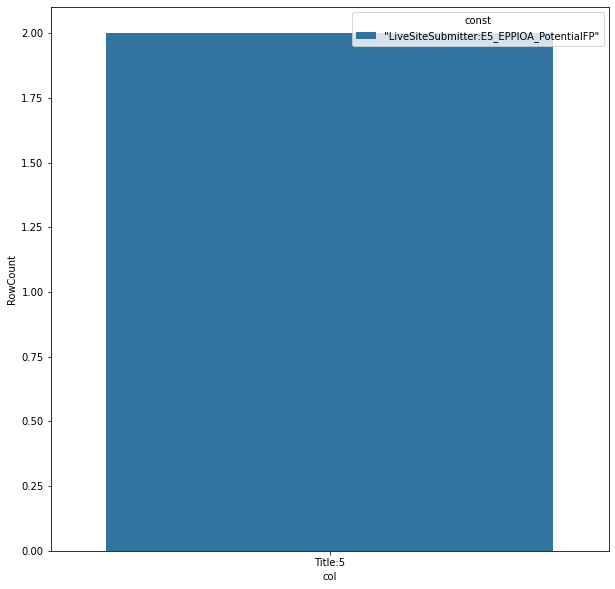

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_X/mmarino/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
string


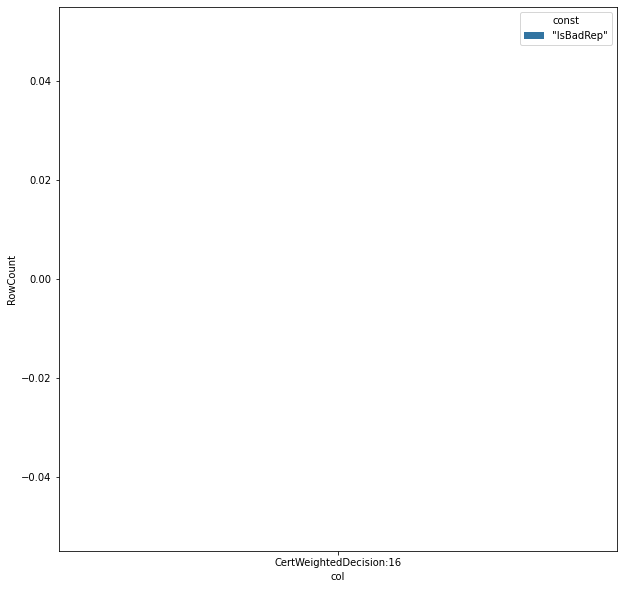

adl://protection-prod-cX.azuredatalakestore.net/local/processed/cooked/bit/Logs/Processing/Cumulative/aggregatedTestset.ss
string


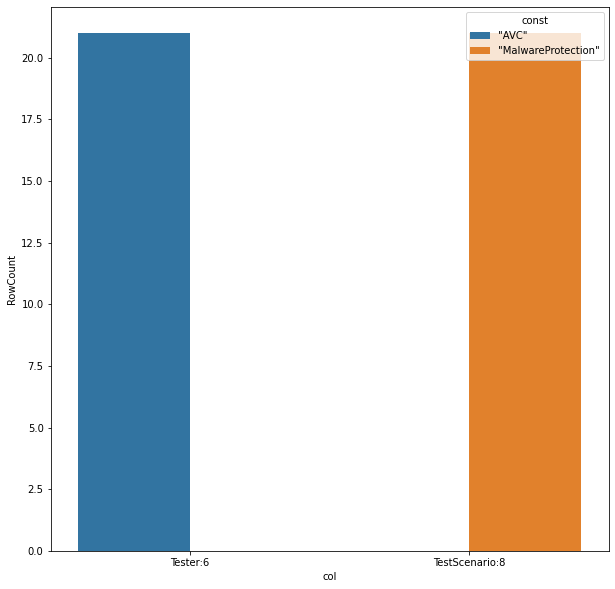

adl://protection-prod-cX.azuredatalakestore.net/local/processed/profile/shaX/history/FileMetadata/X/X/X/X_FileMetadataExtracted.ss
string


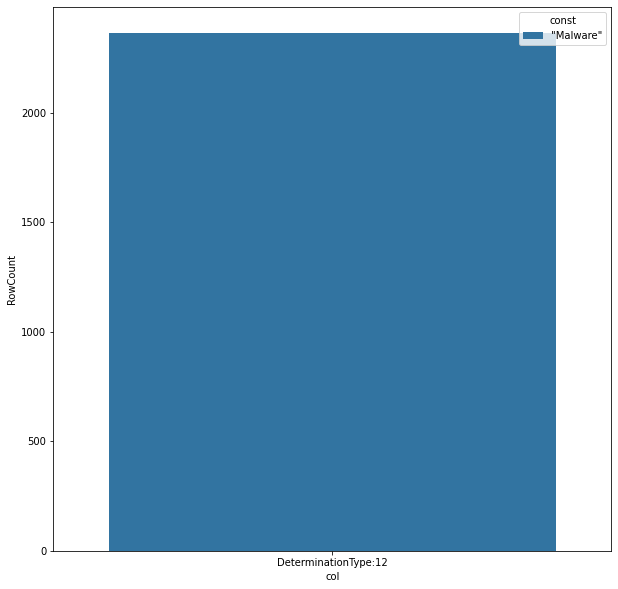

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/Incident.Cap/Incident.Cap.ss
null


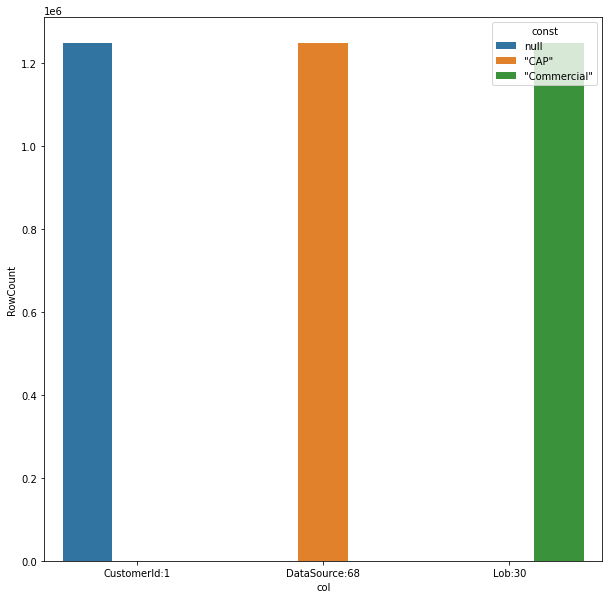

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/IncidentNotes.ss
string


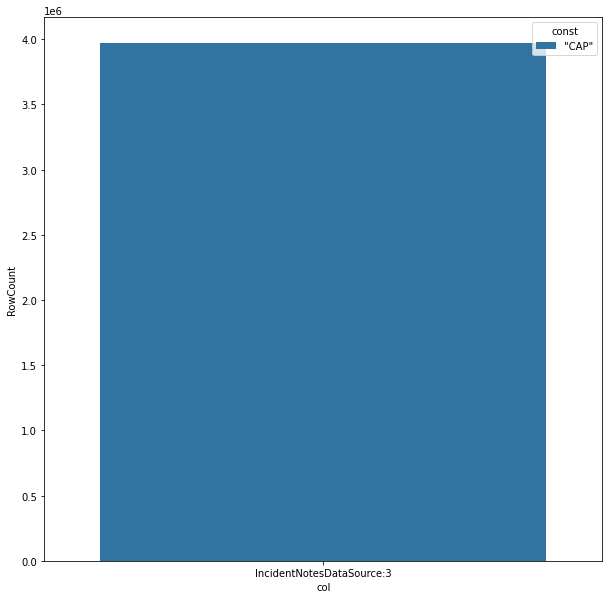

adl://wiad-smrt-prod-cX.azuredatalakestore.net/local/Data/IWB_Grading/SMTPD/GradingResults/FinalGrades.ss
num


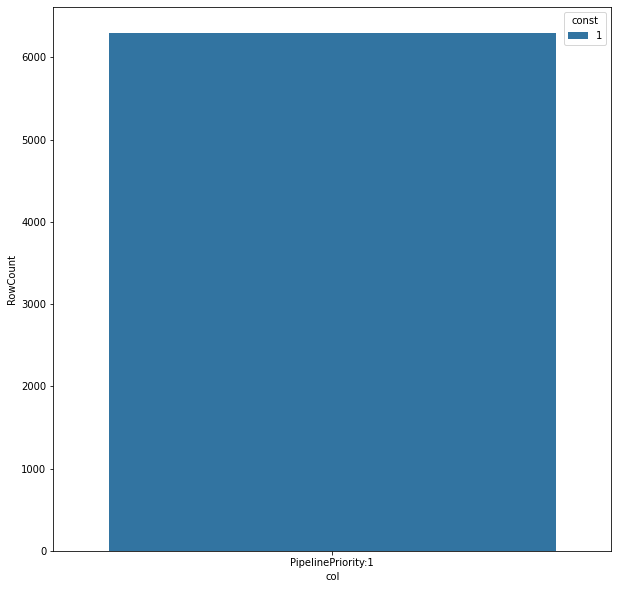

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_e/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


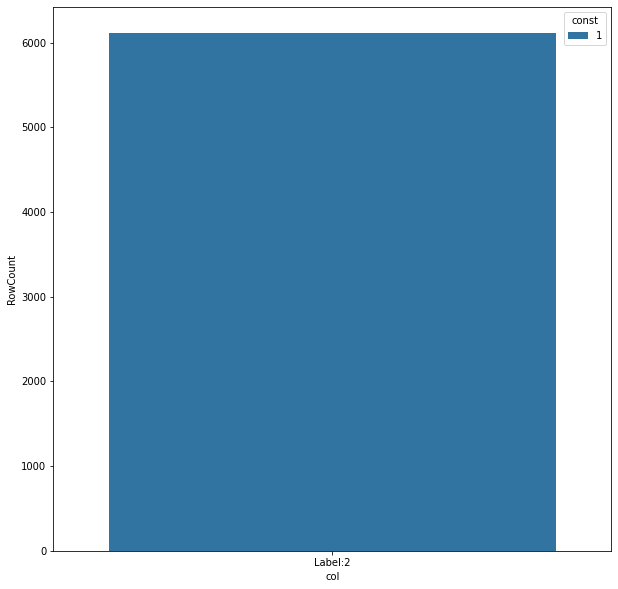

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_e/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


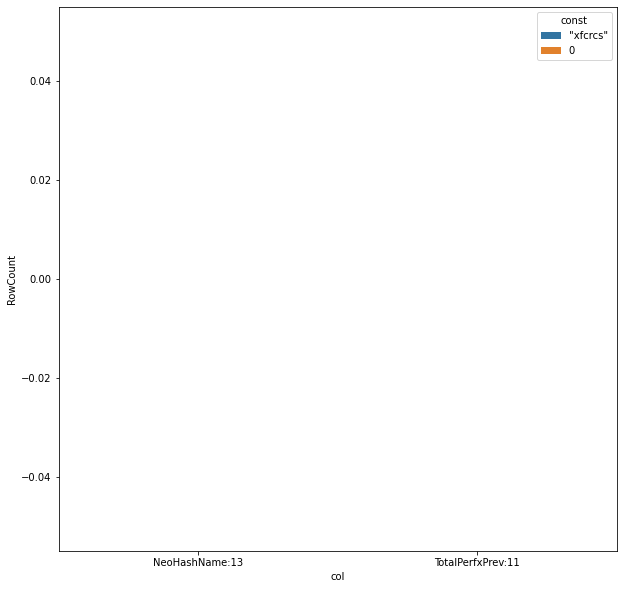

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_X/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


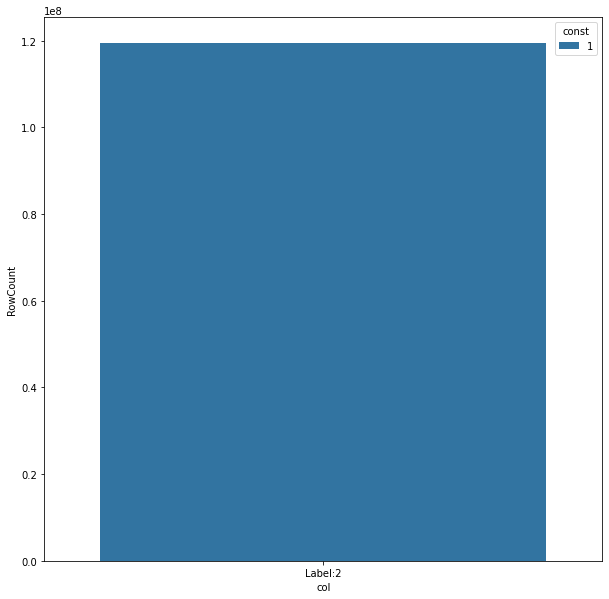

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_a/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


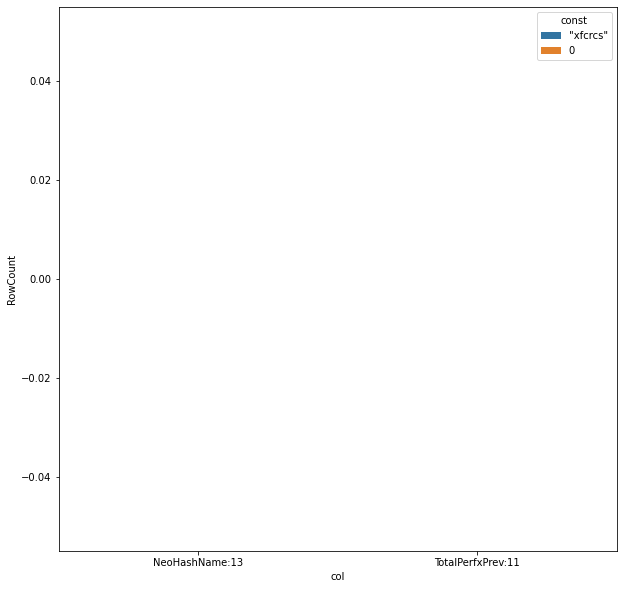

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_a/mmarino/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
string


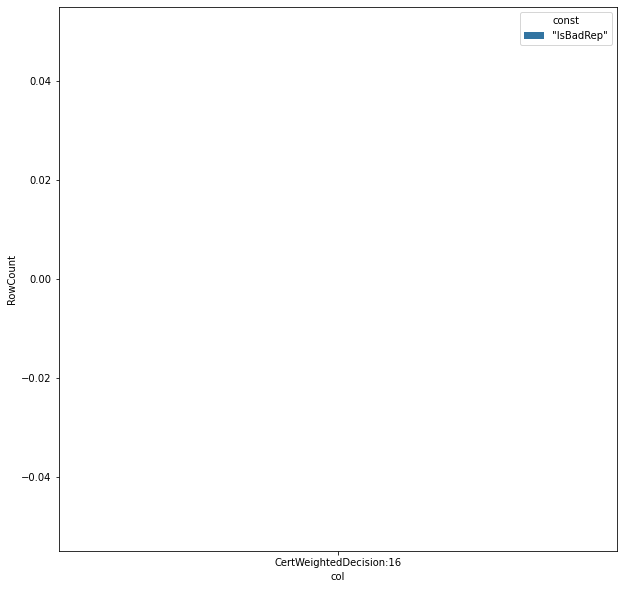

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_a/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


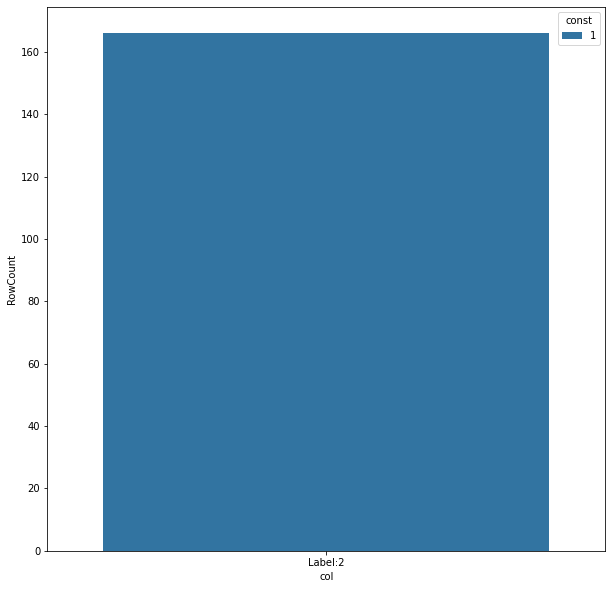

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_b/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


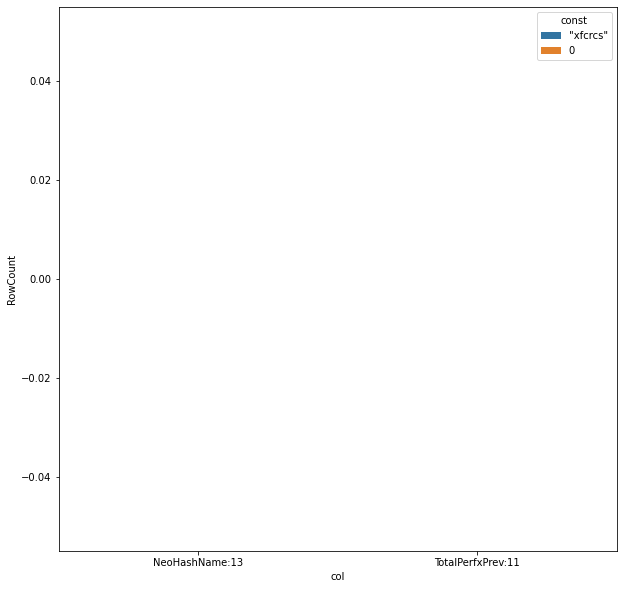

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_b/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


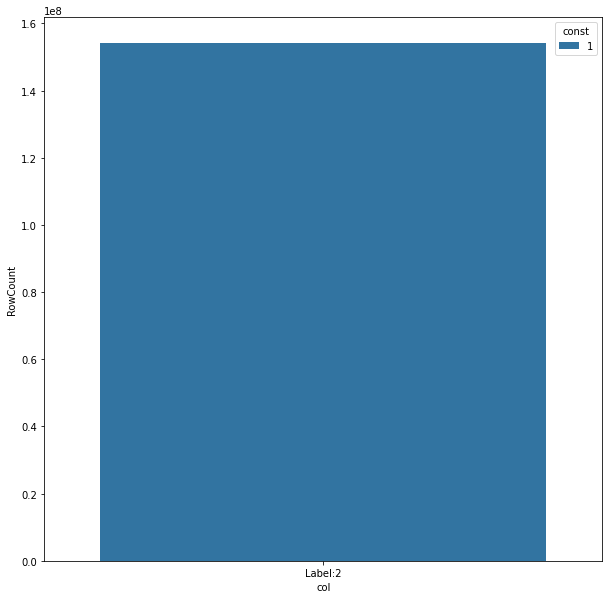

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_c/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


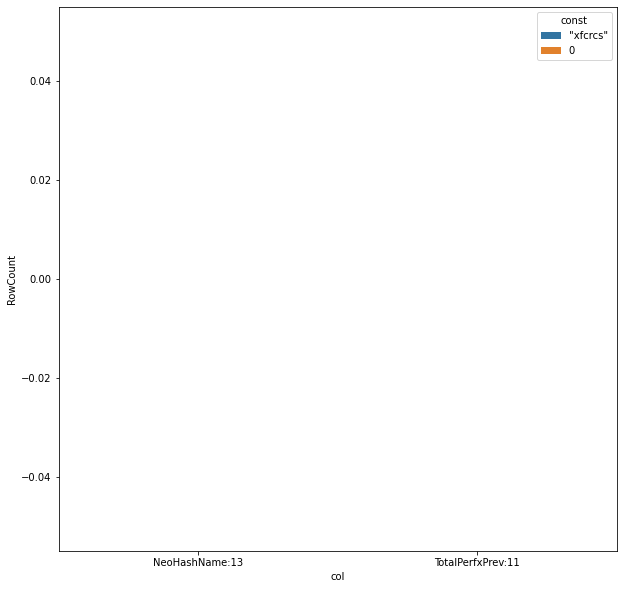

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_d/aldenp/[guid]@@@-Cosmos_Tool-_Simple_select_With_OutputPath[AEtherId]@@@X-X-X_X-X-X_[Time]/OutputCosmosStream/OutputCosmosStream_[guid].ss
string


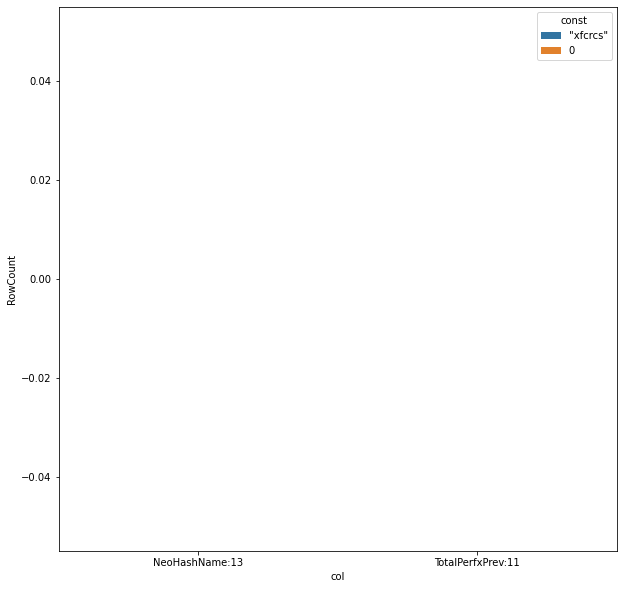

adl://protection-adhoc-cX.azuredatalakestore.net/local/BI/ML/AEther/_d/yilewang/[guid]@@@-Cosmos_Tool-_Generic_join_two_streams_and_filter[AEtherId]@@@X-X-X_X-X-X_[Time]/Output/Output_[guid].ss
num


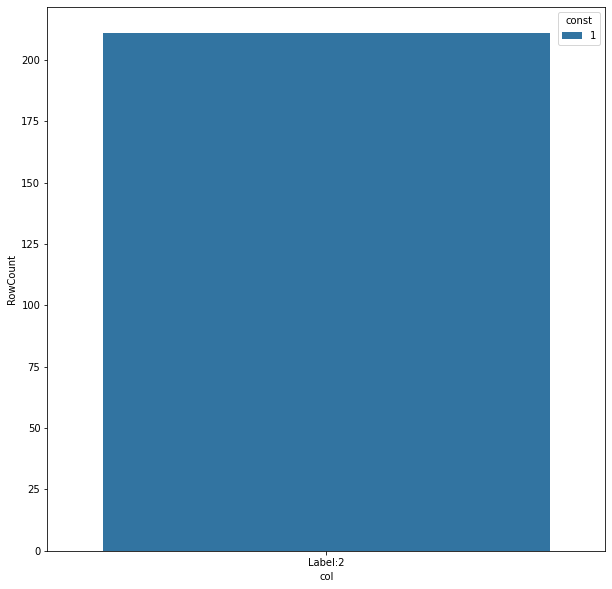

adl://cp-bizops-cX.azuredatalakestore.net/local/RiskOptimization/AzureSubscription/GSM/FraudLabelInternal/CompleteAzureFrauldLabelInternal_latest.ss
num


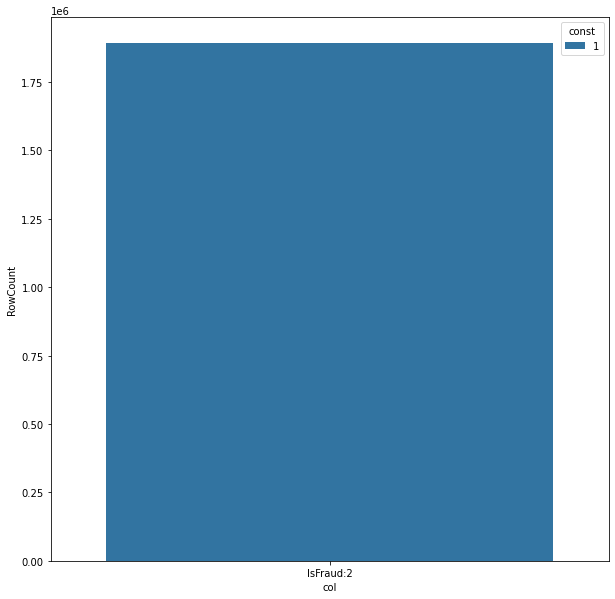

adl://cp-bizops-cX.azuredatalakestore.net/local/users/prkalaba/BatchAU/ReportingFYX/LocalFinalX/BatchAU_Repository_PartX.ss
string


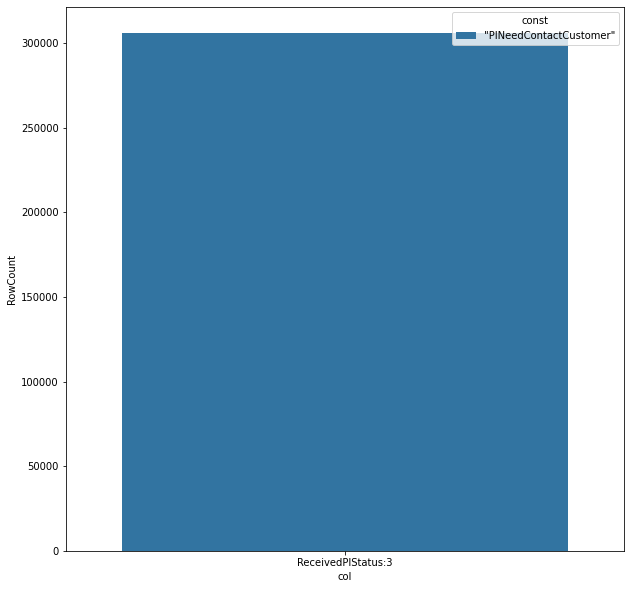

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/CSP/Wifi/CaptivePortal/X/X/CaptivePortalDailySummary_X.ss
null


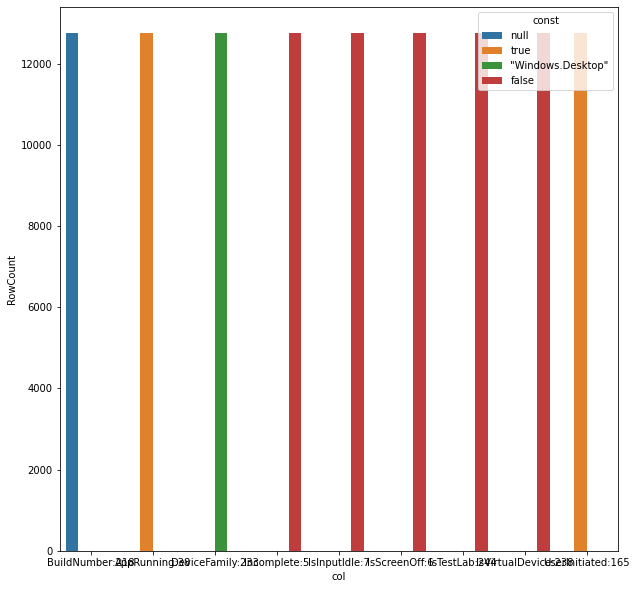

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Accessibility/Narrator/PhoneticReading/X/X/TargetEvents_X_X_X.ss
string


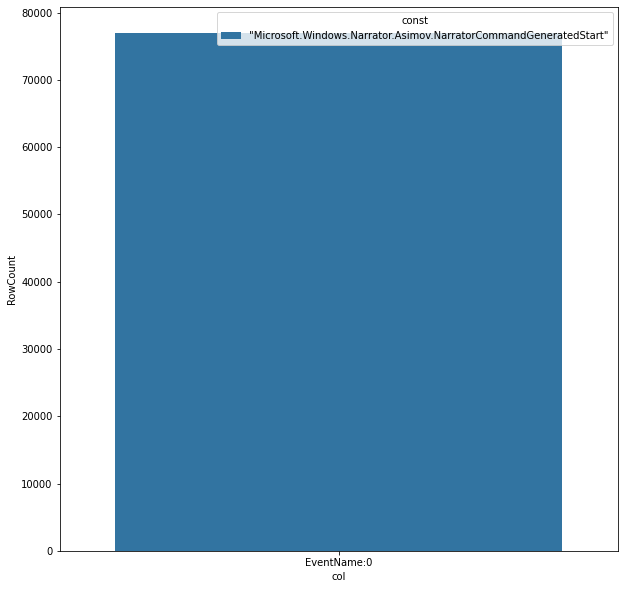

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/DAS/DXP/AppExperiences/Exploration/MsixPackagingTool/MPTusage.ss
string


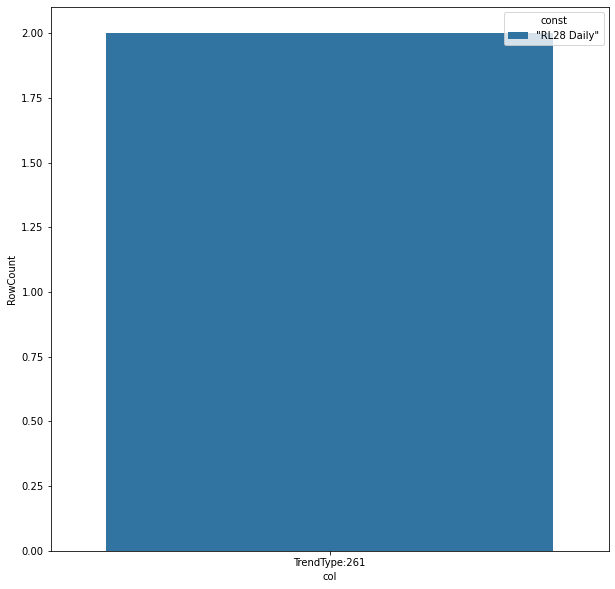

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThresholdWithCab_X_X_X_X__X_X_X.ss
bool


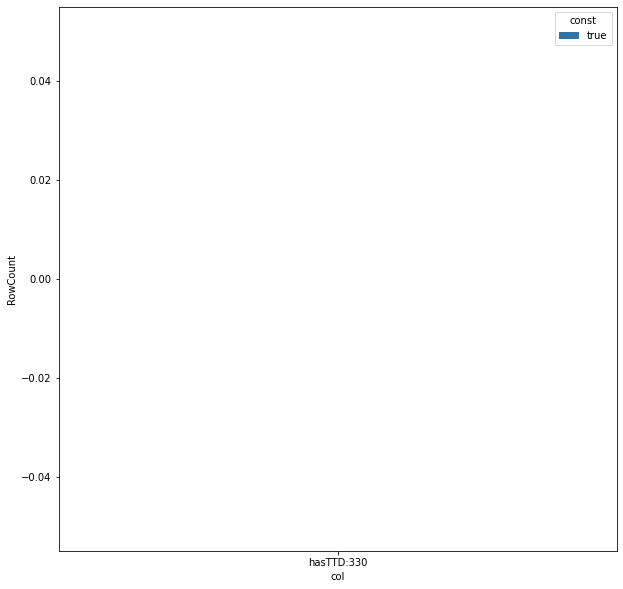

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Deployment/OSUpgrade/DiskSpaceConsolidated/CumulativeDiskSpaceConsolidated.ss
string


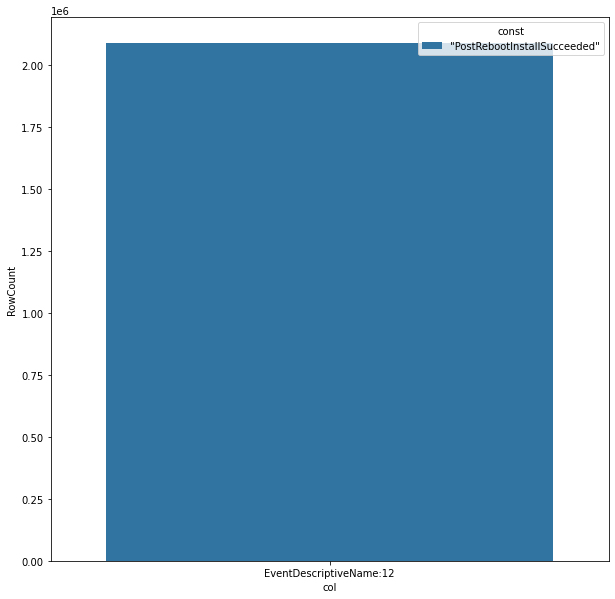

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Deployment/OSUpgrade/diagnostics/DeviceLevelFailures/CumulativeDeviceLevelFailures.ss
string


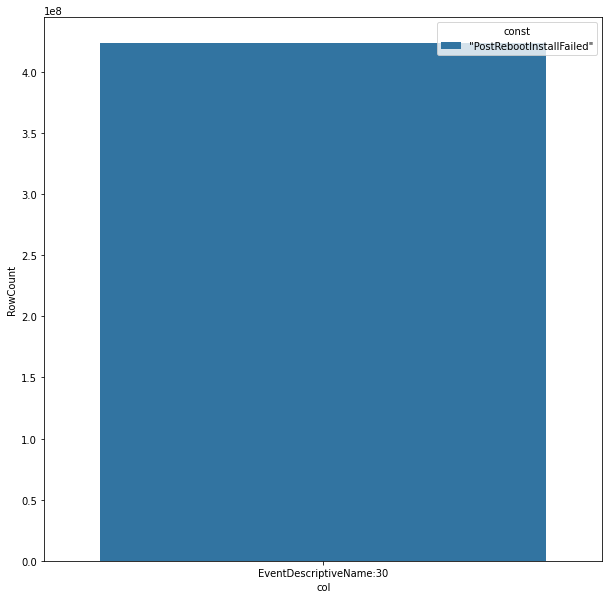

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Deployment/Servicing/PackageEnd/RawEvents/vX/X/X/CbsPackageChangeEndVX_X.ss
string


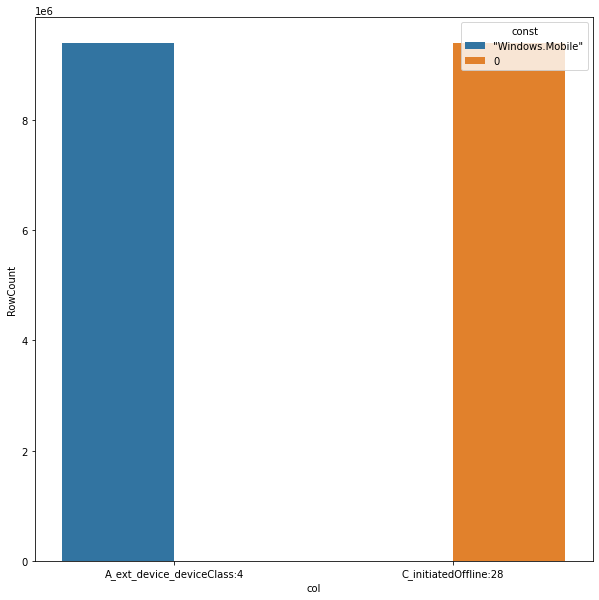

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/EdgeAnaheim/WXaaS/MAD_DAD/output/Edge/anaheimInstallCohorts_consolidated.ss
bool


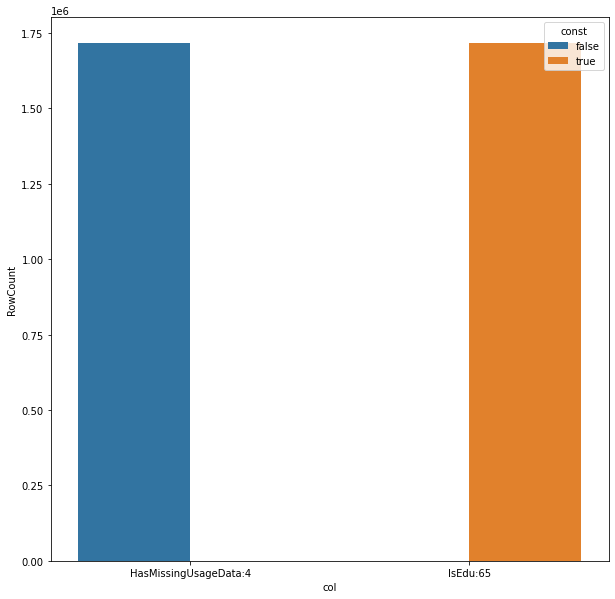

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Graphics/Census/DeviceCensusGraphics/vX/DeviceCensusGraphics.ss
num


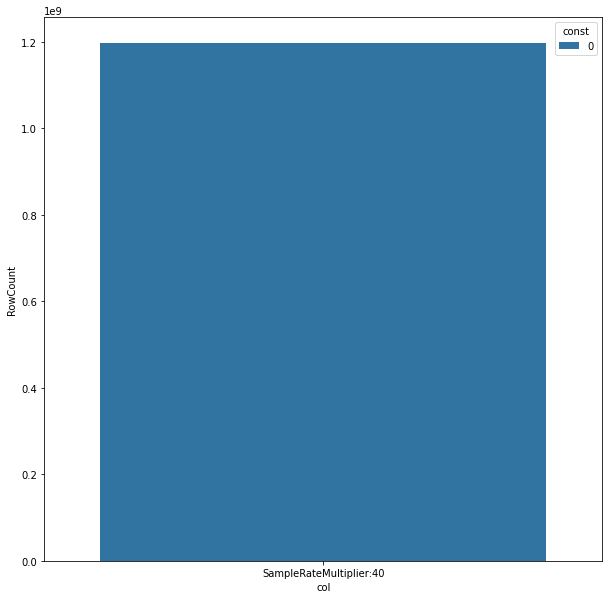

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/HAS/Cluster/latest/ClusterAllEvents.ss
string


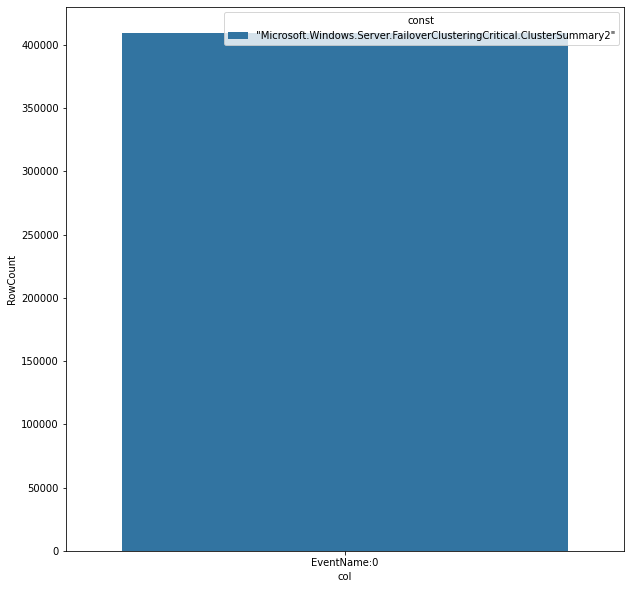

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/HeX/HardwareQuality/Bluetooth/BluetoothReporting/QuickPair/AllPairingAttemptsWithQPStatus.ss
bool


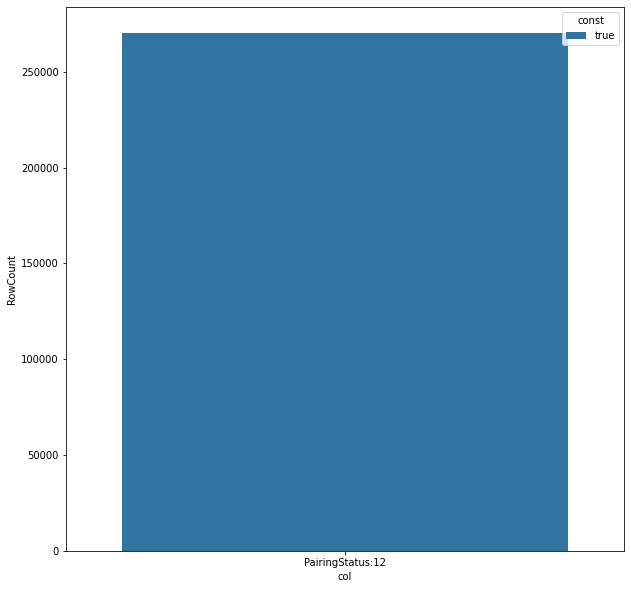

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss
null


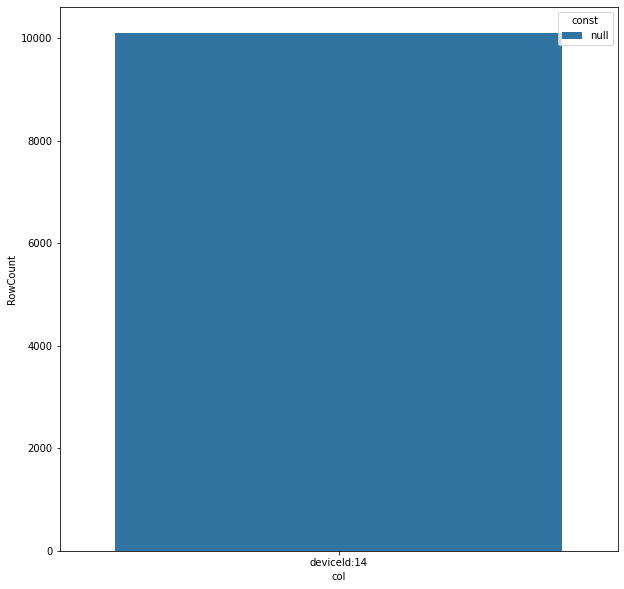

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultBaseline_X_X_X_X__X_X_X.ss
null


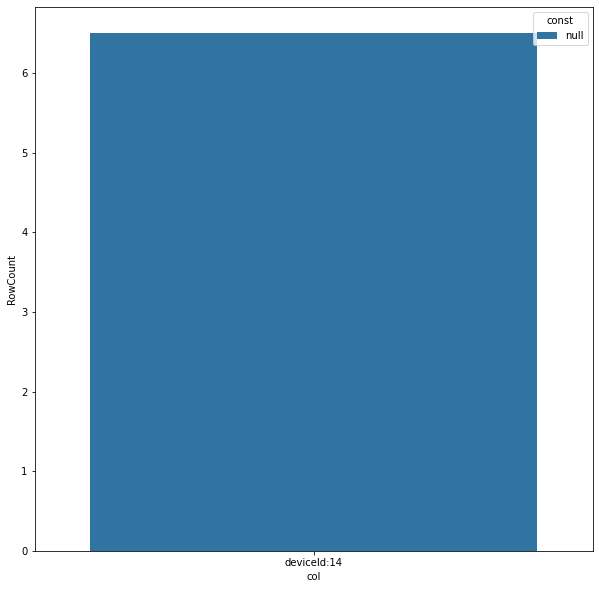

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PrivatePartner/Processed/Family/MMF/prod/vX/X/X/User.MultiMemberFamily_X_X_X.ss
string


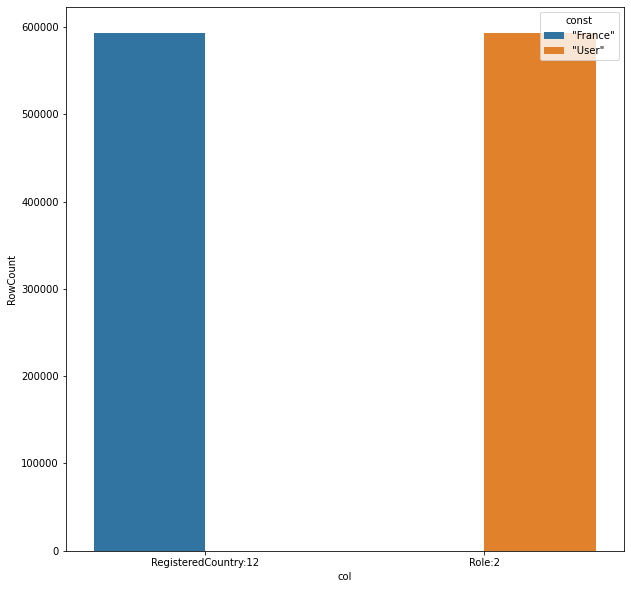

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Device/Inventory/VX/Flattened/InventoryDevicePnp.ss
string


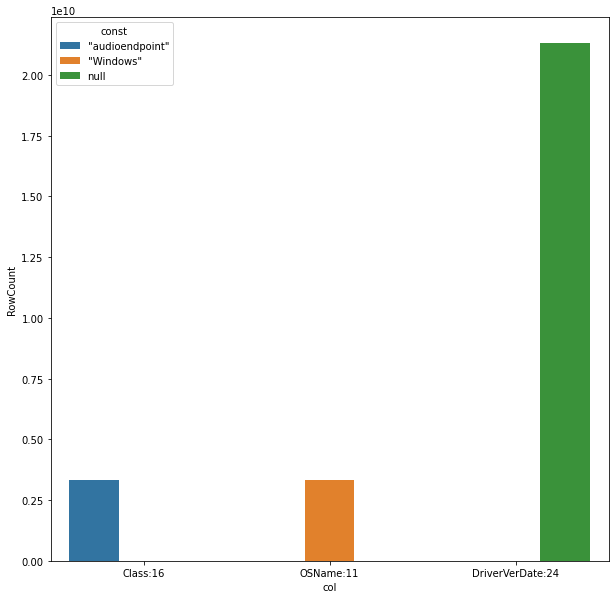

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/InsightsReports/ActiveDeviceMetrics/vX/Prod/Processed/MAD/WinX/X/X/ADM_DeviceLevel_X_X_X.ss
string


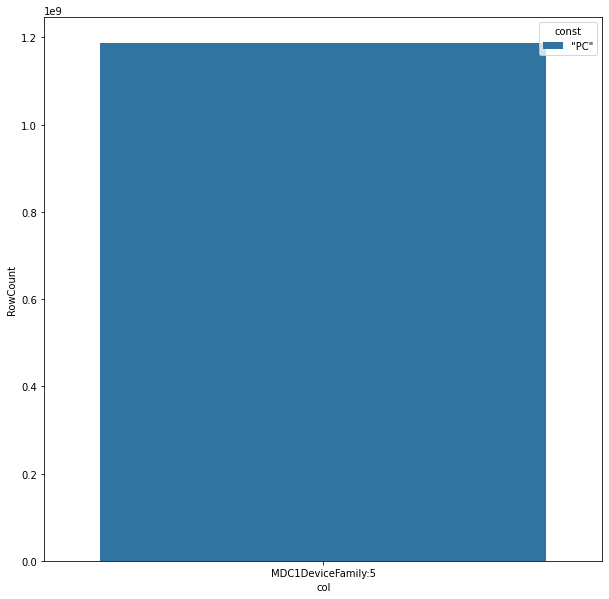

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Device/Census/Consolidated/VX/X/X/DeviceCensusConsolidated_VX_X_X_X.ss
string


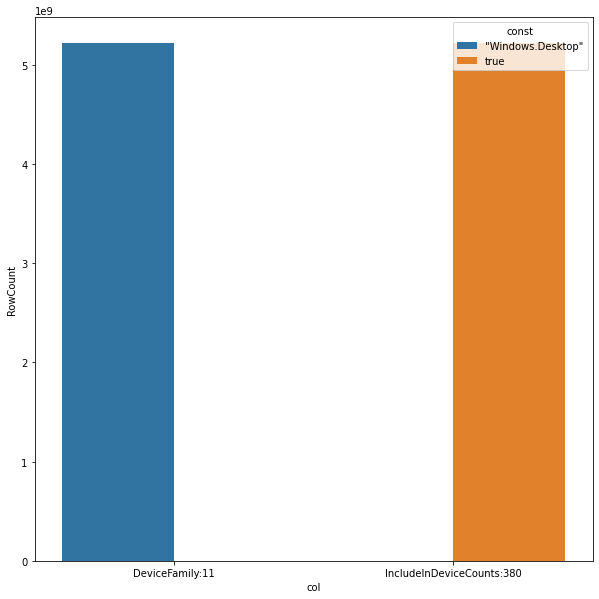

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Device/Census/Consolidated/VX/X/X/X/DeviceCensusConsolidated_VX_X_X_X_X.ss
bool


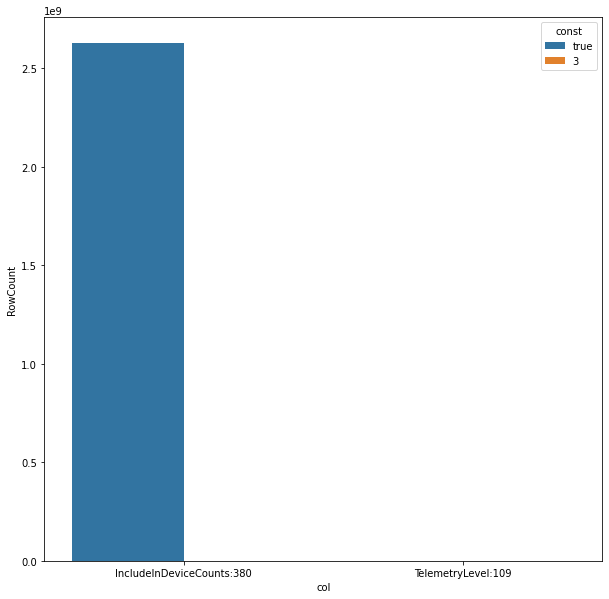

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Device/Census/Daily/VX/X/X/DeviceCensusDaily_VX_X_X_X.ss
bool


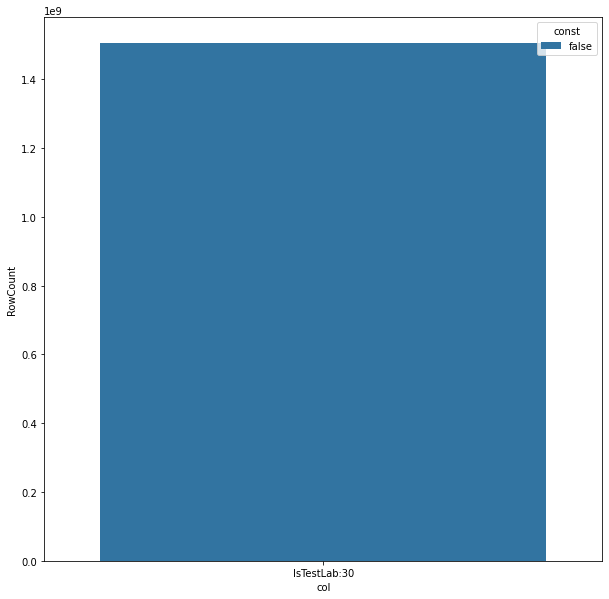

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Subscriptions/Metrics/SubscriptionInstanceMetrics/Daily/X/X/SubscriptionInstanceMetrics_X_X_X.ss
null


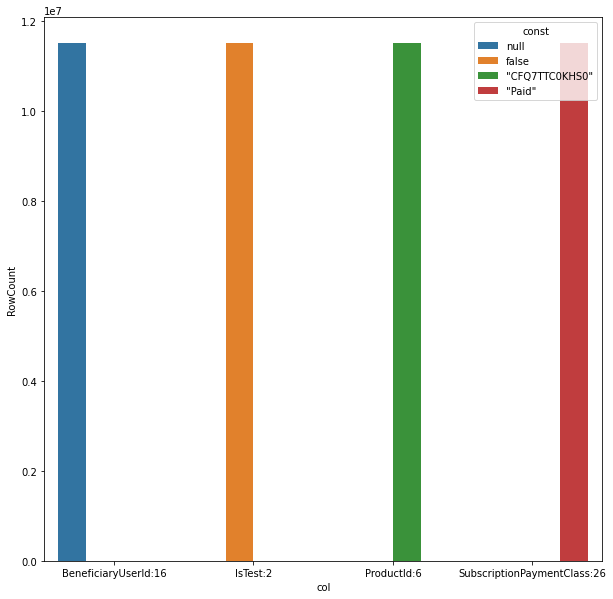

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/Kernel/X/X/X/X/OcaSnapshotResultBaseline_X_X_X_X__X_X_X.ss
null


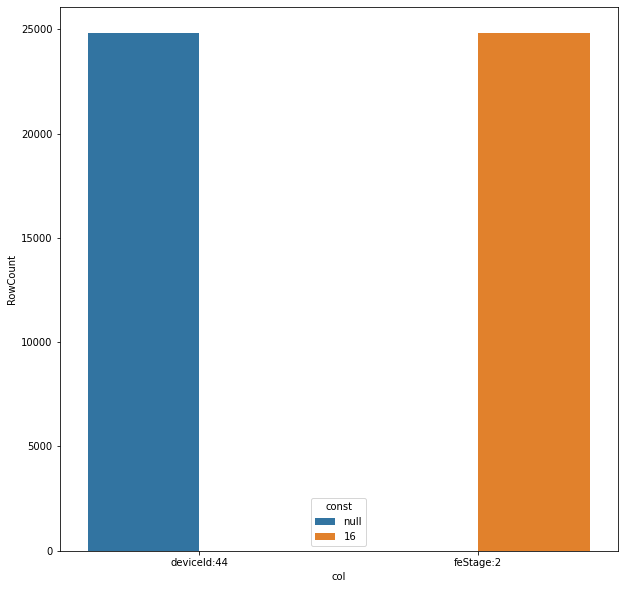

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/Kernel/X/X/X/X/OcaSnapshotResultBaselineWithCab_X_X_X_X__X_X_X.ss
num


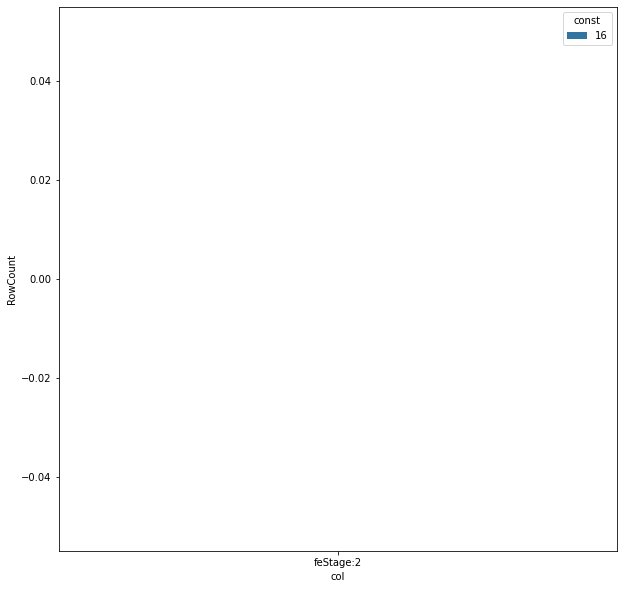

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/HeX/HardwareQuality/Bluetooth/Develop/BluetoothReporting/QuickPair/AllPairingAttemptsWithQPStatus.ss
bool


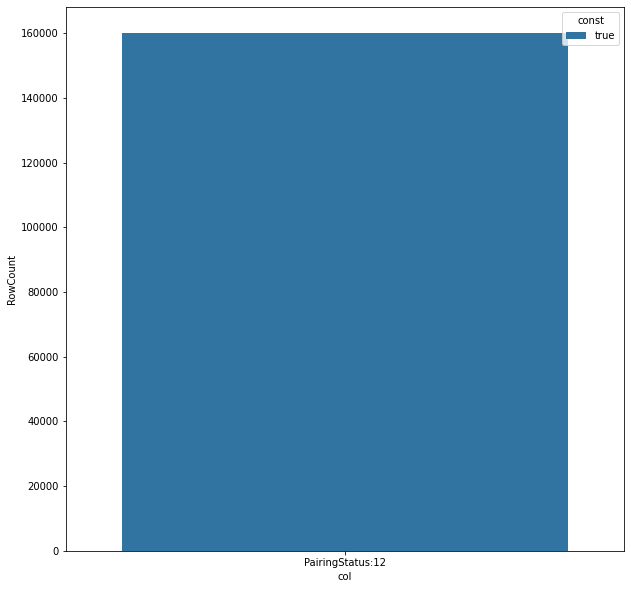

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Mitigation/EventsWithCensus/AuthenticateCabSignatureFailed/vX/X/X/X/AuthenticateCabSignatureFailed_X_X_X_X.ss
bool


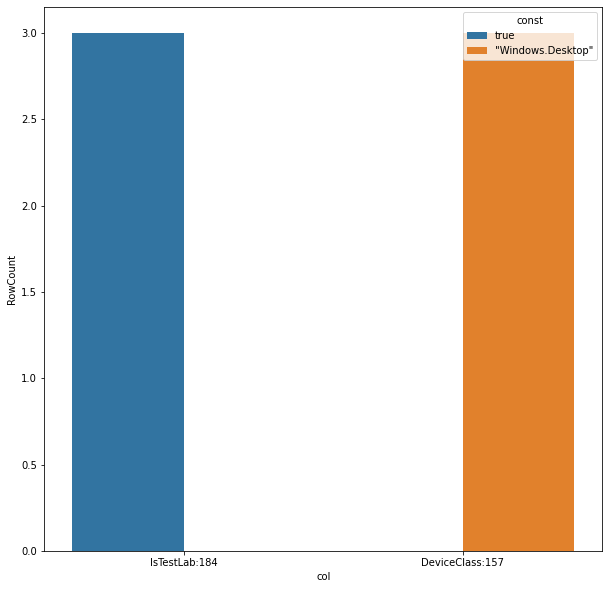

adl://asimov-prod-data-cX.azuredatalakestore.net/local/Purchase/Partner/xbox/fact/purchase/appandgame/vX/X/X/ft_appandgame_orderid-productid-xuid_daily_X_X_X.ss
string


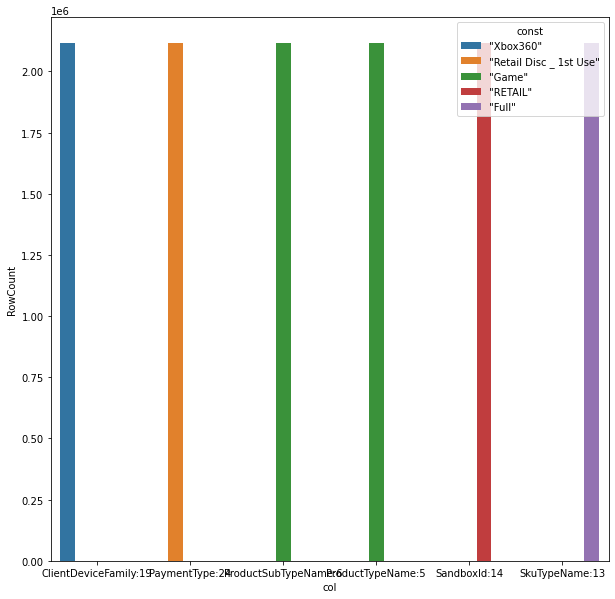

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/XboxLive/Sathish/Churn_Report/Ultimate/Ultimate_SIM_Daily_X.ss
null


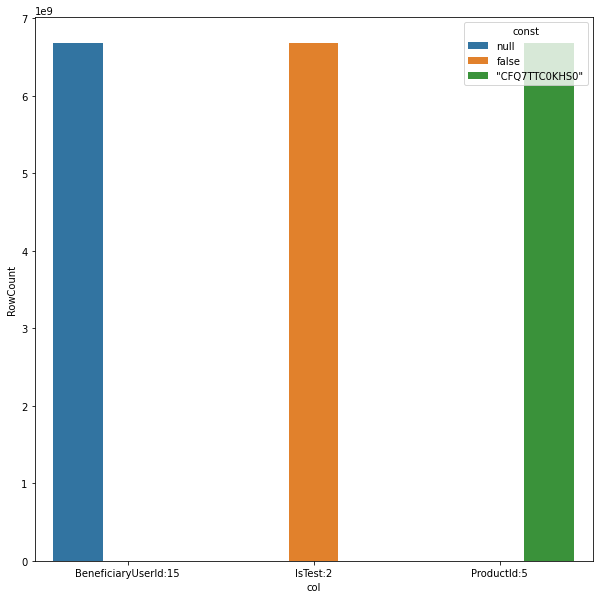

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/XboxLive/Selvam/[Month]/NewDeal/Temp/GP_Base_BF.ss
string


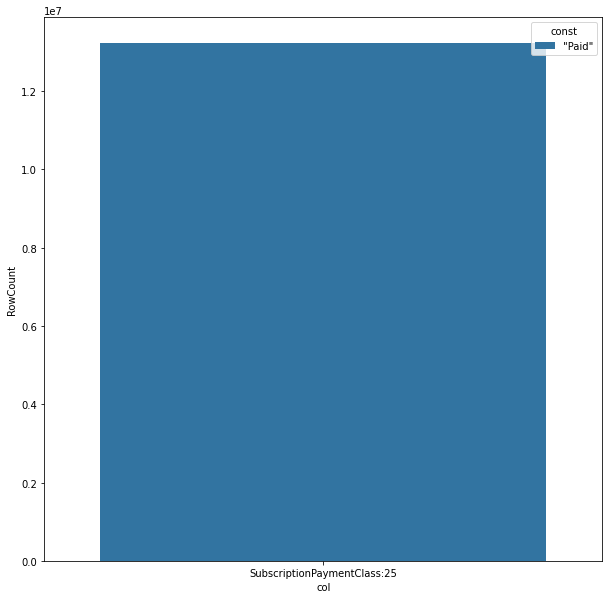

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/XboxLive/Selvam/[Month]/NewDeal/Test/GP_Base.ss
string


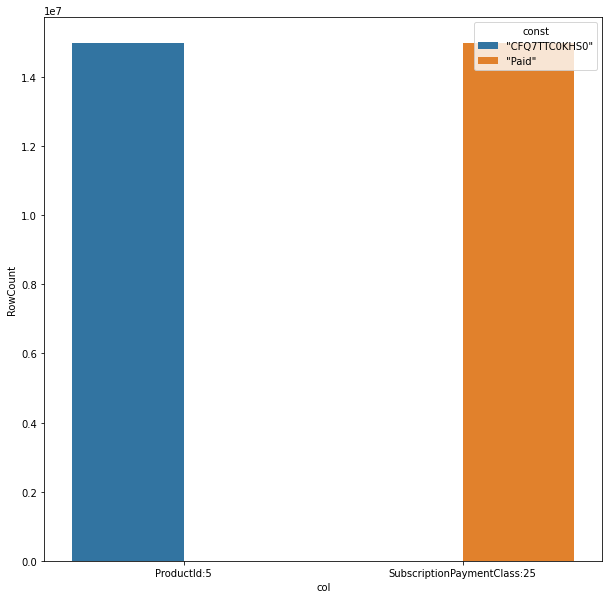

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/XboxLive/Shiva/skt_analysis/base/friendXuids.ss
num


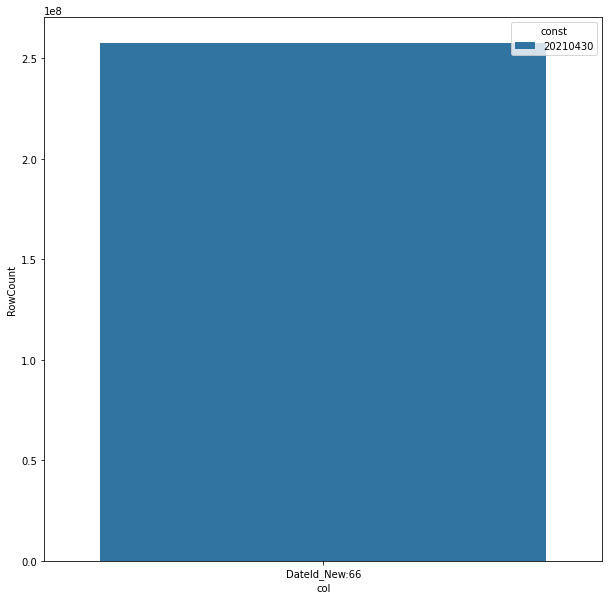

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Mitigation/EventsWithCensus/DeviceState/vX/X/X/X/DeviceState_X_X_X_X.ss
bool


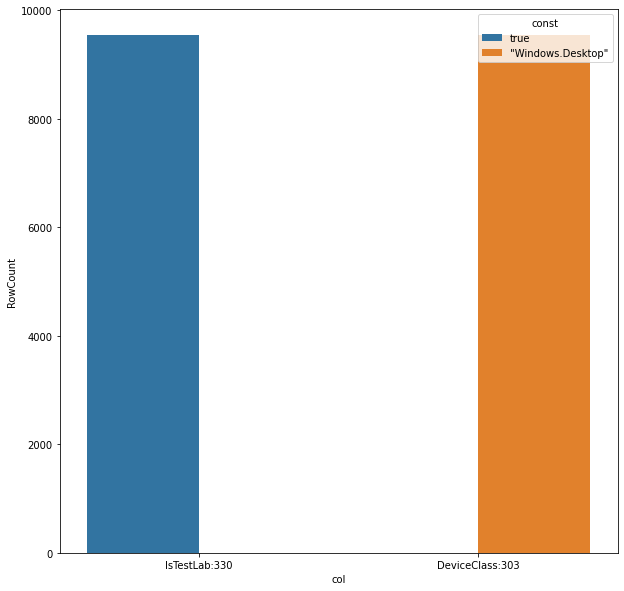

adl://asimov-prod-data-cX.azuredatalakestore.net/local/UserSensitive/Partner/xbox/fact/flight/submissions/vX.X/ft_submissions_contentid-eventtype_snapshot.ss
string


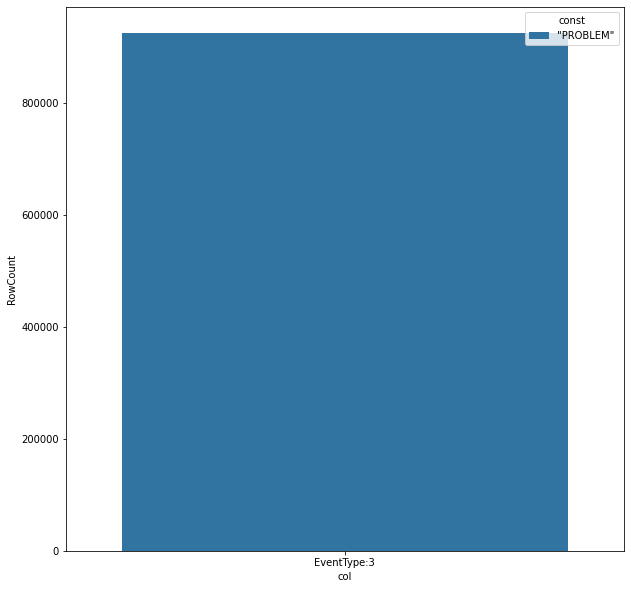

adl://asimov-prod-data-cX.azuredatalakestore.net/local/UserSensitive/Usage/Partner/Processed/WebPlatform/Connectivity/CapabilityChange/X/X/CapabilityChange_X_X_X.ss
num


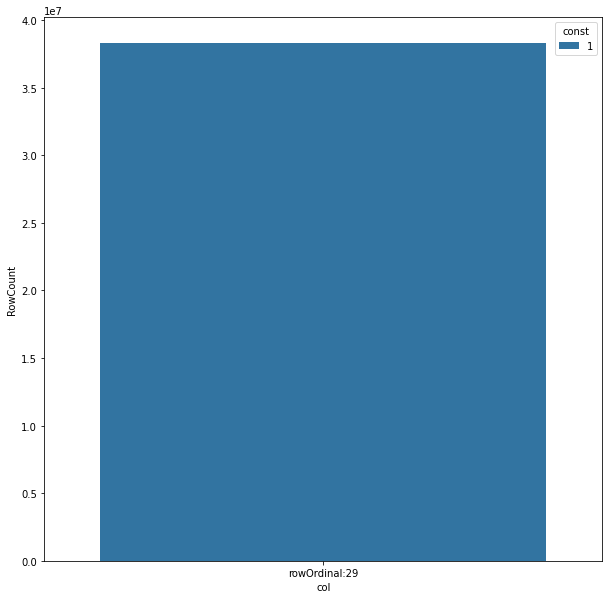

adl://cp-bizops-cX.azuredatalakestore.net/local/BizOpsDataSharing/AzureSubscription/AzureSubscriptionFraudLabel_Complete/AzureSubscriptionFraudLabel_Complete.ss
string


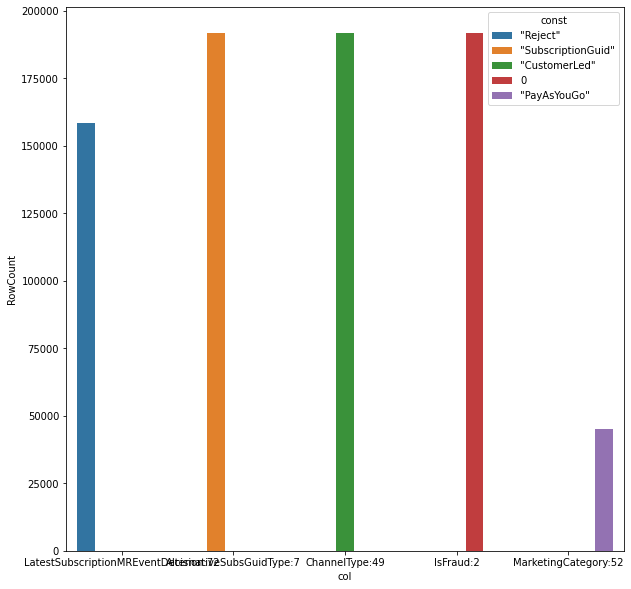

adl://cp-bizops-cX.azuredatalakestore.net/local/RiskOptimization/AzureSubscription/AzureTrustOrg/AzureTrustOrgOrderSummaryFullList.ss
string


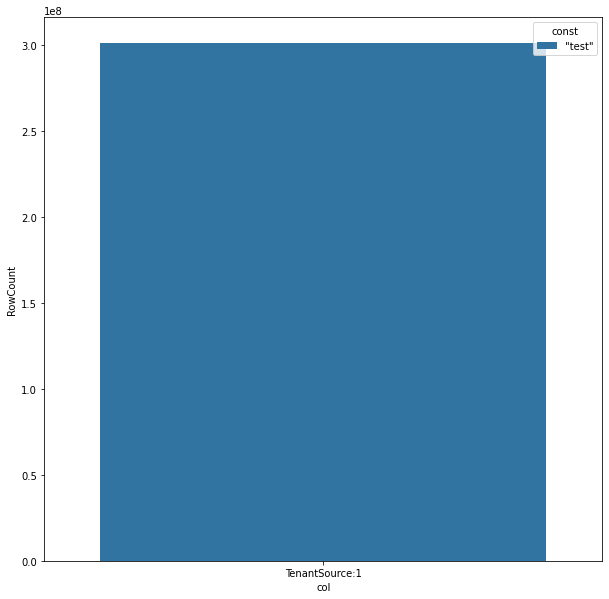

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/XboxLive/Cherishma/X/[Month]/X/NewDealDataAsk/GP_Base.ss
string


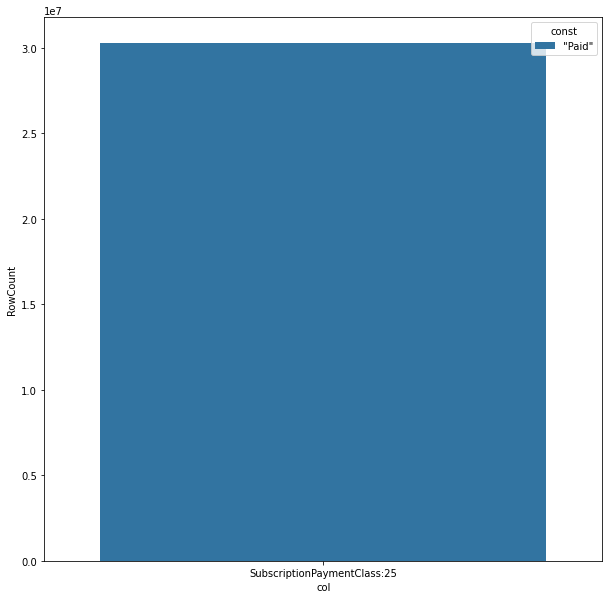

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Staging/Reliability/Reporting/Rollup/UnifiedSchema/UnifiedSchema.Builds.Flighted.ss
string


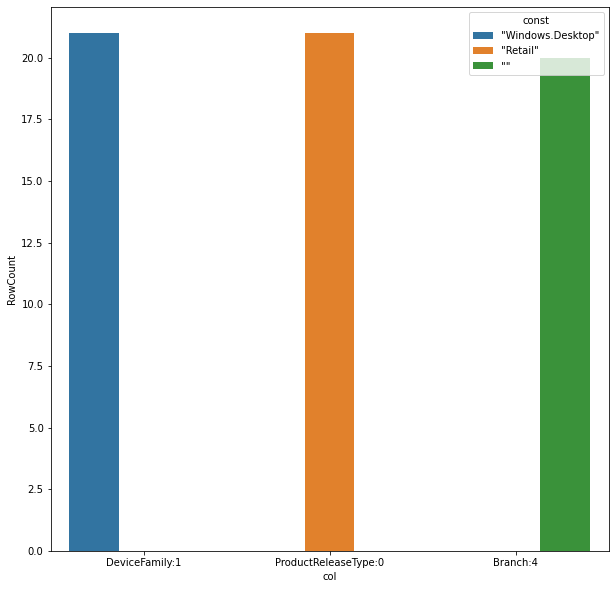

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/SessionFactory/Official/HoloLensLifetime/vX/Supplementary/AllTime/OldPipelineSessions.ss
bool


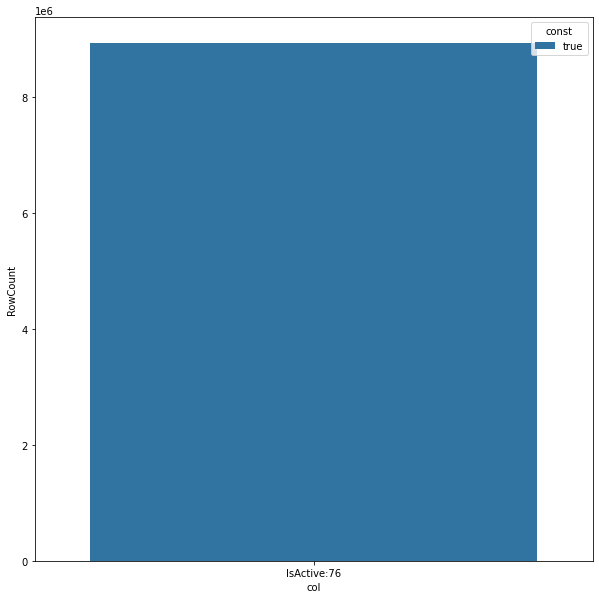

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/SessionFactory/Official/HoloLensLifetime/vX/Supplementary/DataModel/HoloLensProductLatestLifetime_AllLTDCounts.ss
num


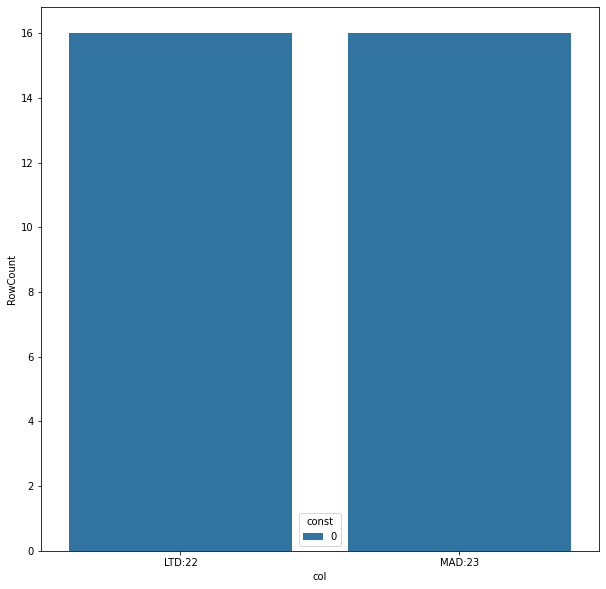

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/SessionFactory/Official/WindowsLogin/vX/_private/Sessions/X/X/X/WindowsLoginSessions_cc_[Date]-X.ss
string


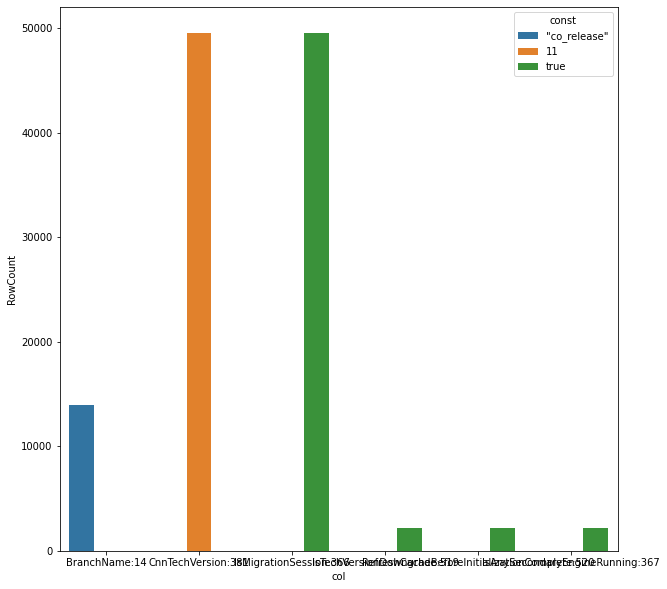

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Shell/AnnoyingPopups/ToastNoiseAnalysis/SVToastNoiseData_WithOOBE_X_X_X.ss
bool


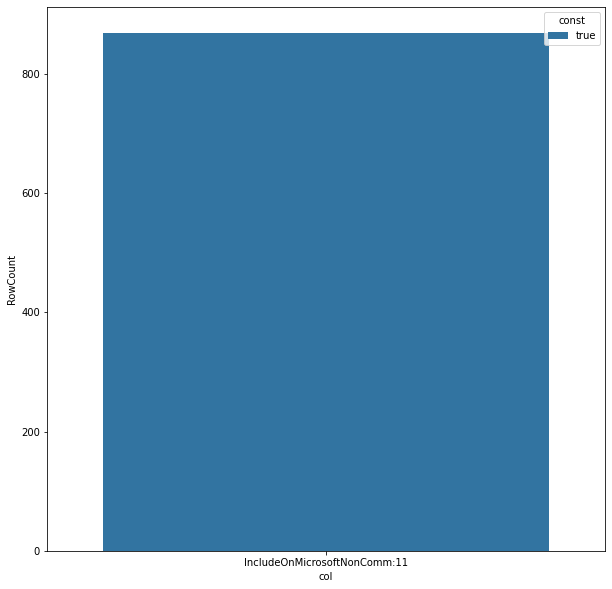

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/Shell/AnnoyingPopups/ToastNoiseAnalysis/ToastNoiseData_withOOBE_X_X_X.ss
bool


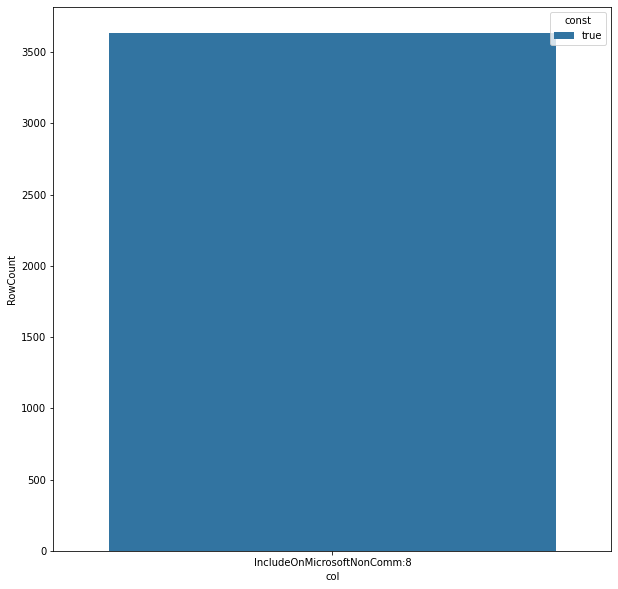

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WSD.Upgrade/INBOX_UNP/VX/AsimovEvents/X/X/RawEventsFull_X.ss
string


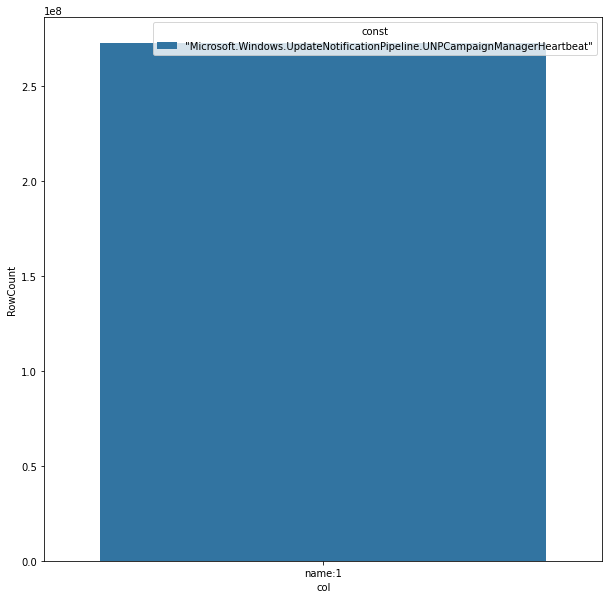

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WSD.Upgrade/asharan/XOOBAnalysis/UpdateComplete_NotWSUS_NotSeeker_Logs_X_X_X.ss
string


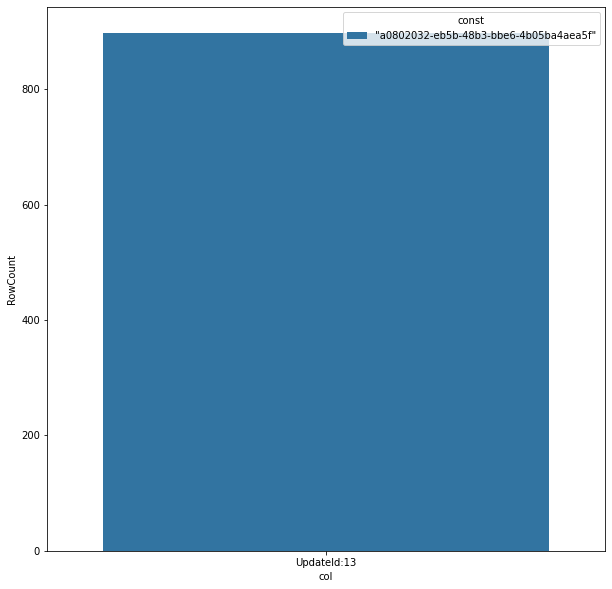

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WSD/WSD.DA.Enterprise/IntelligentRollout/Logging/XHX/DTU_DevicesSelectedForUpgrade.ss
num


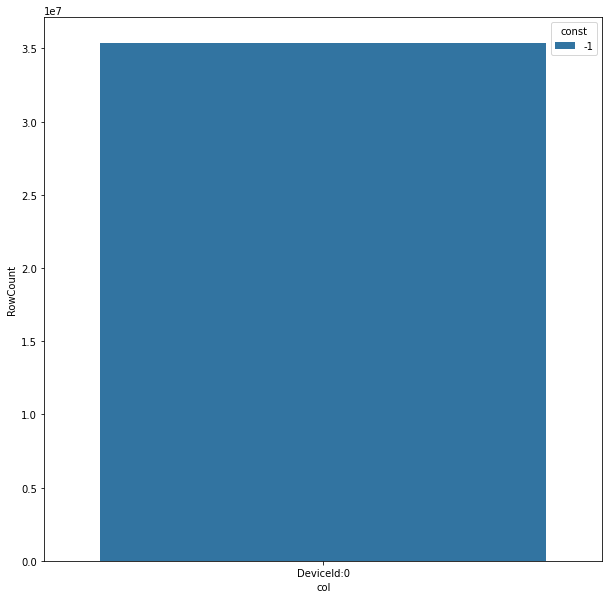

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WindowsClient/DataScience/algala_temp/EQM/NewDevice_OS_X_X_X.ss
string


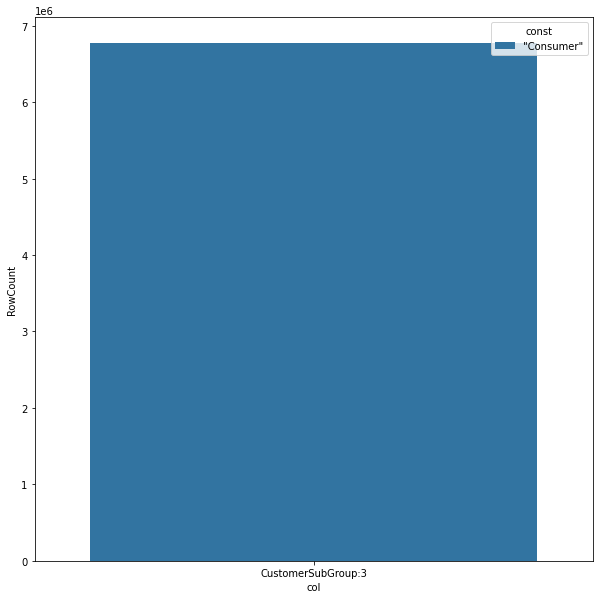

adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WindowsServer/MAD/Heuristics/Consolidated/ServerHeuristics_Consolidated_Census.ss
bool


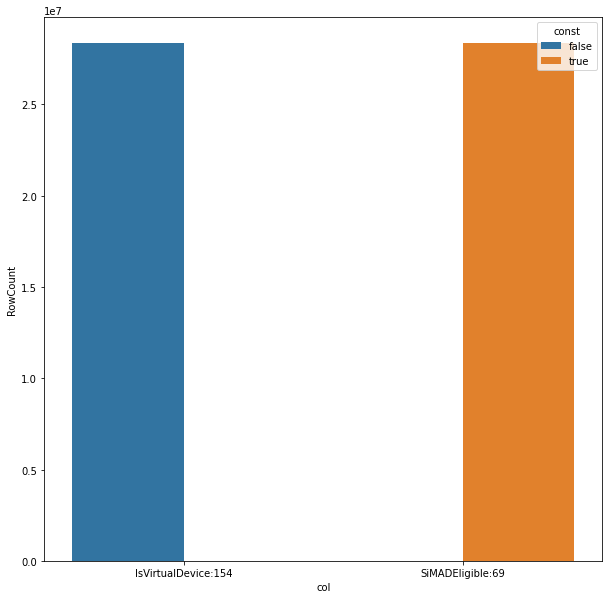

adl://wlsprepex-adhoc-cX.azuredatalakestore.net/local/Data/InteractiveQuery/UrsDb.ss
string


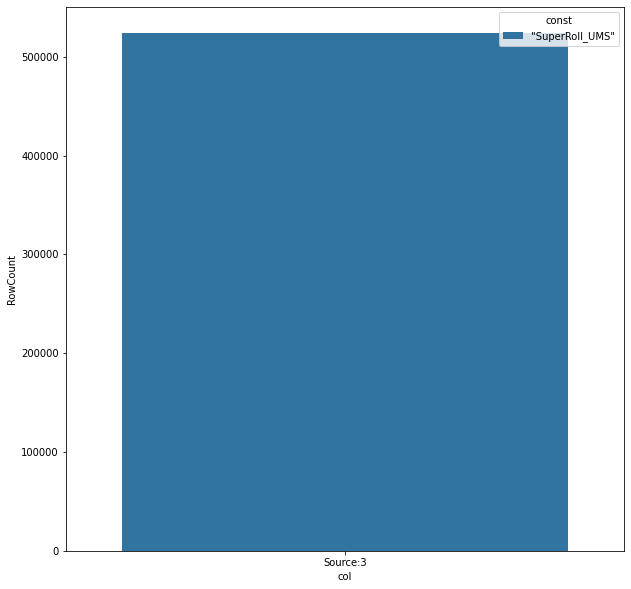

In [54]:
for inp in inpnames:
    print(inp)
    tmpdf = discdf[discdf.input == inp]
    #print(tmpdf["disctype"].values)
    fix, ax = plt.subplots(figsize=(10,10))
    #sns.barplot(data=tmpdf, x="col", y = "Selectivity", hue="const", ax=ax, ci=None)
    print(tmpdf["disctype"].values[0])
    sns.barplot(data=tmpdf, x="col", y = "RowCount", hue="const", ax=ax, ci=None)
    #plt.legend().remove()
    plt.show()